In [1]:
from keras.models import Model
from keras import backend as K
from keras.layers import LSTM, Input, Dense, Activation, Add, Reshape, Lambda, Concatenate, \
                         TimeDistributed, Bidirectional, Masking

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from keras.models import load_model

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from collections import Counter

In [5]:
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import class_weight
from tqdm import tqdm

In [93]:
import numpy as np
np.set_printoptions(precision=3,linewidth=1000,edgeitems=100,suppress=True)
seed = 7
np.random.seed(seed)

In [79]:
docs, links = np.load('X_large.npy'), np.load('Y.npy')
assert len([i for l in links for i in l]) == sum((len(d) for d in docs))

In [85]:
np.where(np.array([len(d) for d in docs]) > 7)

(array([94]),)

Counter({5: 71, 6: 24, 4: 11, 3: 3, 7: 2, 10: 1})


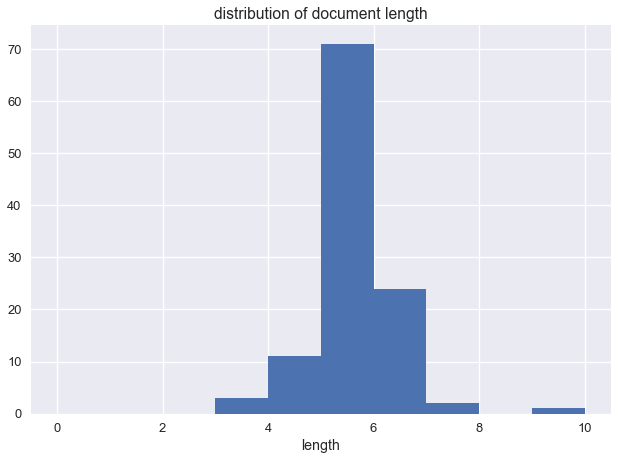

In [81]:
plt.title('distribution of document length')
plt.xlabel('length')
print(Counter([len(d) for d in docs]))
plt.hist([len(d) for d in docs],np.arange(11),);

In [119]:
params

NameError: name 'params' is not defined

Counter({1: 259, 3: 96, 5: 76, 2: 55, 4: 51, 6: 37, 7: 1, 9: 1})


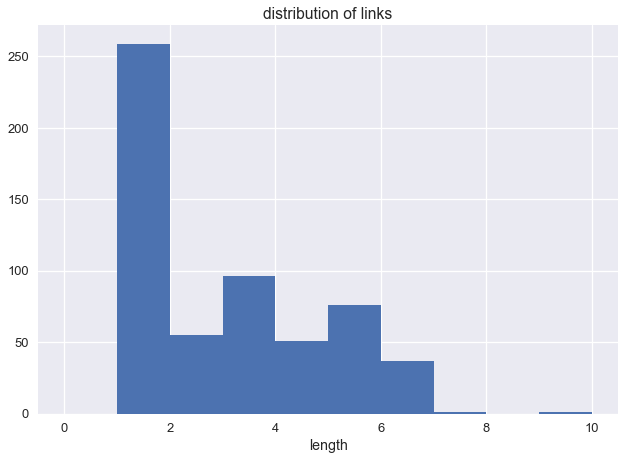

In [82]:
plt.title('distribution of links')
plt.xlabel('length')
print(Counter([i for l in links for i in l]))
plt.hist([i for l in links for i in l],np.arange(11),);

In [110]:
# pad with zeros, truncate longer than 6
X = pad_sequences(docs, dtype=float, truncating='post',padding='post')
print(X.shape)
# convert links 1,1,2 -> [1,0,0,0]
#                        [1,0,0,0]
#                        [0,1,0,0]
#                        [0,0,0,0]
Y = np.array([to_categorical(np.array(y)-1, num_classes=X.shape[1]) for y in links])
Y_ind = [len(y) for y in Y]
Y = pad_sequences(Y, dtype=int, truncating='post', padding='post')

(112, 10, 2641)


In [108]:
Y[0]

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [103]:
X[0]

array([[ 1.   , -0.061,  0.054, -0.183, -0.076, -0.044,  0.065,  0.022, -0.307, -0.068,  2.073, -0.11 , -0.006,  0.045, -0.02 , -0.255, -0.174, -0.149,  1.148, -0.156,  0.057, -0.031,  0.025, -0.06 , -0.107,  0.03 , -0.002, -0.092, -0.093,  0.114, -0.17 ,  0.002,  0.133, -0.089,  0.12 ,  0.005, -0.098,  0.091,  0.144, -0.005,  0.025, -0.042,  0.057, -0.124,  0.016,  0.052,  0.007, -0.073,  0.096, -0.003,  0.022, -0.005,  0.015, -0.055, -0.007, -0.027,  0.06 ,  0.123, -0.134,  0.102, -0.066,  0.021, -0.065, -0.089,  0.095,  0.054, -0.061, -0.045,  0.045,  0.122,  0.083,  0.138,  0.068,  0.348, -0.054,  0.106,  0.094,  0.117, -0.028,  0.006,  0.207,  0.029,  0.065, -0.156,  0.022, -0.008, -0.199,  0.071,  0.052,  0.346,  0.066, -0.171, -0.022,  0.045,  0.121,  0.202, -0.018, -0.078, -0.056, -0.039, ...,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
   

In [84]:
X.shape, Y.shape

((112, 10, 2641), (112, 10, 10))

In [56]:
# X_train, Y_train = X[:96], Y[:96]
X_test, Y_test, Y_test_ind = X[100:], Y[100:], Y_ind[100:]

print(X_test.shape, Y_test.shape)

(12, 10, 2641) (12, 10, 10)


In [29]:
def create_model(seq_len, hidden_size, dropout, masking):
    inp = Input(shape=(seq_len, 2641), name='input')

    if masking:
        mask = Masking(mask_value=0)(inp)
        inputt = TimeDistributed(Dense(hidden_size, activation='sigmoid', kernel_regularizer='l2'), name='FC_input')(mask)
        encoder = Bidirectional(LSTM(hidden_size//2, return_sequences=True, name='encoder', recurrent_dropout=dropout, dropout=dropout))(inputt)
        decoder = LSTM(hidden_size, return_sequences=True, name='decoder', recurrent_dropout=dropout, dropout=dropout)(encoder)
    else:
        inputt = TimeDistributed(Dense(hidden_size, activation='sigmoid', kernel_regularizer='l2'), name='FC_input')(inp)
        encoder = Bidirectional(LSTM(hidden_size//2, return_sequences=True, name='encoder', recurrent_dropout=dropout, dropout=dropout))(inputt)
        decoder = LSTM(hidden_size, return_sequences=True, name='decoder', recurrent_dropout=dropout, dropout=dropout)(encoder)

    typ = TimeDistributed(Dense(hidden_size, use_bias=True, kernel_regularizer='l2'), name='type')(encoder)
        
    # glorot_uniform initializer:
    # uniform([-limit,limit]) where limit = sqrt(6/(in+out))
    # for hidden=512: uniform(-0.07, +0.07)
    E = TimeDistributed(Dense(hidden_size, use_bias=False, kernel_regularizer='l2'), name='E')(encoder)
    D = TimeDistributed(Dense(hidden_size, use_bias=False, kernel_regularizer='l2'), name='D')(decoder)

    DD = Lambda(lambda x: K.repeat_elements(K.expand_dims(x, 2), seq_len, 2))(D)

    add = Add(name='W1E_W2Di')
    tanh = Activation('tanh', name='tanh')

    # glorot_uniform initializer:
    # uniform([-limit,limit]) where limit = sqrt(6/(in+out))
    # for hidden=512: uniform(-0,108, +0,108)
    vt = Dense(1, use_bias=False, kernel_regularizer='l2', name='vT')
    softmax = Activation('softmax', name='softmax')

    attention = add([E,DD])
    attention = tanh(attention)
    attention = vt(attention)
    attention = Lambda(lambda x: K.squeeze(x, -1))(attention)
    attention = softmax(attention)

    model = Model(inputs=inp, outputs=[attention, typ])
    return model

In [64]:
model = create_model(seq_len=6, hidden_size=512, dropout=.9, masking=False)
plot_model(model, 'FC_input')

In [26]:
adam = Adam()
tensorboad = TensorBoard()

In [126]:
fixed_params = dict(hidden_size=512, seq_len=X.shape[1], nb_epoch=4000, batch_size=10, dropout=.9)

paramsearch = [
    dict(c_weights=True,  embedding=False),
    dict(c_weights=False, embedding=False),
]

In [ ]:
for param in paramsearch:
    param.update(fixed_params)

histories = []

for param in paramsearch:
    # pad with zeros, truncate longer than 6
    X = pad_sequences(docs, dtype=float, truncating='post',padding='post', value=param['padding'])

    # convert links 1,1,2 -> [1,0,0]
    #                        [1,0,0]
    #                        [0,1,0]
    Y = [pad_sequences(to_categorical(np.array(y)-1), truncating='post', padding='post', value=param['padding'],maxlen=10) for y in links]
    Y_ind = [len(y) for y in Y]
    Y = pad_sequences(Y, dtype=int, truncating='post', padding='post', value=param['padding'])
        
    histories.append([])
    kfold = ShuffleSplit(n_splits=5, test_size=20, random_state=seed)

    for train, val in tqdm(kfold.split(X[:100])):
        model = create_model(param['seq_len'], param['hidden_size'], param['dropout'], masking=param['masking'])
        model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'],
                      sample_weight_mode="temporal")  

        # class weights
        if param['c_weights']:
            class_num = Y.shape[-1]
            
            class_weights = dict(zip(np.arange(class_num),np.zeros(class_num)))
            labels = Y[train].argmax(2).flatten()
            un_labels = np.unique(labels)
            weights = class_weight.compute_class_weight('balanced', un_labels, labels)
            class_weights.update(zip(un_labels, weights))
            
            sample_weights = np.zeros(Y[train].shape[:2])
            for i in range(class_num):
                sample_weights[Y[train].argmax(2)==i] = class_weights[i]

        print(X[train].shape, X[val].shape)
        history = model.fit(X[train], Y[train], validation_data=(X[val], Y[val]),
                            epochs=param['nb_epoch'], batch_size=param['batch_size'], verbose=2)#, sample_weight=sample_weights)

        histories[-1].append(history)

        scores = model.evaluate(X[val], Y[val], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    # last validation accuracy
    val_acc = [h.history['val_categorical_accuracy'][-1] for h in histories]
    print("%.2f%% (+/- %.2f%%)" % (numpy.mean(val_acc), numpy.std(val_acc)))


0it [00:00, ?it/s]

(80, 10, 2641) (20, 10, 2641)


Train on 80 samples, validate on 20 samples
Epoch 1/4000
 - 7s - loss: 15.3256 - categorical_accuracy: 0.4788 - val_loss: 9.8436 - val_categorical_accuracy: 0.7450
Epoch 2/4000
 - 2s - loss: 6.3587 - categorical_accuracy: 0.7050 - val_loss: 4.0211 - val_categorical_accuracy: 0.7450
Epoch 3/4000
 - 2s - loss: 2.9054 - categorical_accuracy: 0.6713 - val_loss: 2.3265 - val_categorical_accuracy: 0.7450
Epoch 4/4000
 - 2s - loss: 1.8158 - categorical_accuracy: 0.7013 - val_loss: 1.7119 - val_categorical_accuracy: 0.7450
Epoch 5/4000
 - 2s - loss: 1.3904 - categorical_accuracy: 0.6862 - val_loss: 1.2982 - val_categorical_accuracy: 0.7450
Epoch 6/4000
 - 2s - loss: 1.1811 - categorical_accuracy: 0.7062 - val_loss: 1.1865 - val_categorical_accuracy: 0.7450
Epoch 7/4000
 - 2s - loss: 1.0598 - categorical_accuracy: 0.6963 - val_loss: 1.0319 - val_categorical_accuracy: 0.7450
Epoch 8/4000
 - 2s - loss: 1.0402 - categorical_accuracy: 0.7100 - val_loss: 1.0887 - val_categorical_accuracy: 0.7450
Epo

Epoch 69/4000
 - 2s - loss: 0.5840 - categorical_accuracy: 0.6850 - val_loss: 0.8742 - val_categorical_accuracy: 0.6850
Epoch 70/4000
 - 2s - loss: 0.5635 - categorical_accuracy: 0.6737 - val_loss: 0.9250 - val_categorical_accuracy: 0.5800
Epoch 71/4000
 - 2s - loss: 0.5877 - categorical_accuracy: 0.6775 - val_loss: 0.8444 - val_categorical_accuracy: 0.5600
Epoch 72/4000
 - 2s - loss: 0.5823 - categorical_accuracy: 0.6725 - val_loss: 0.9619 - val_categorical_accuracy: 0.5350
Epoch 73/4000
 - 2s - loss: 0.5876 - categorical_accuracy: 0.6788 - val_loss: 0.8776 - val_categorical_accuracy: 0.6400
Epoch 74/4000
 - 2s - loss: 0.5813 - categorical_accuracy: 0.6700 - val_loss: 0.8903 - val_categorical_accuracy: 0.5100
Epoch 75/4000
 - 2s - loss: 0.5837 - categorical_accuracy: 0.6837 - val_loss: 0.8698 - val_categorical_accuracy: 0.6700
Epoch 76/4000
 - 2s - loss: 0.5860 - categorical_accuracy: 0.6675 - val_loss: 0.8857 - val_categorical_accuracy: 0.6850
Epoch 77/4000
 - 2s - loss: 0.6018 - cat

Epoch 137/4000
 - 2s - loss: 0.5422 - categorical_accuracy: 0.6762 - val_loss: 0.9175 - val_categorical_accuracy: 0.5650
Epoch 138/4000
 - 2s - loss: 0.5418 - categorical_accuracy: 0.6800 - val_loss: 0.8987 - val_categorical_accuracy: 0.6350
Epoch 139/4000
 - 2s - loss: 0.5353 - categorical_accuracy: 0.6813 - val_loss: 0.8874 - val_categorical_accuracy: 0.5800
Epoch 140/4000
 - 2s - loss: 0.5336 - categorical_accuracy: 0.6850 - val_loss: 0.9070 - val_categorical_accuracy: 0.6350
Epoch 141/4000
 - 2s - loss: 0.5369 - categorical_accuracy: 0.6850 - val_loss: 0.8787 - val_categorical_accuracy: 0.6850
Epoch 142/4000
 - 2s - loss: 0.5304 - categorical_accuracy: 0.6562 - val_loss: 0.8743 - val_categorical_accuracy: 0.5900
Epoch 143/4000
 - 2s - loss: 0.5528 - categorical_accuracy: 0.6662 - val_loss: 0.8840 - val_categorical_accuracy: 0.6650
Epoch 144/4000
 - 2s - loss: 0.5592 - categorical_accuracy: 0.6787 - val_loss: 0.9179 - val_categorical_accuracy: 0.5600
Epoch 145/4000
 - 2s - loss: 0.5

Epoch 205/4000
 - 2s - loss: 0.5342 - categorical_accuracy: 0.6825 - val_loss: 0.8856 - val_categorical_accuracy: 0.5550
Epoch 206/4000
 - 2s - loss: 0.5298 - categorical_accuracy: 0.6663 - val_loss: 0.8842 - val_categorical_accuracy: 0.6100
Epoch 207/4000
 - 2s - loss: 0.5337 - categorical_accuracy: 0.6525 - val_loss: 0.8680 - val_categorical_accuracy: 0.6250
Epoch 208/4000
 - 2s - loss: 0.5247 - categorical_accuracy: 0.6737 - val_loss: 0.8693 - val_categorical_accuracy: 0.6850
Epoch 209/4000
 - 2s - loss: 0.5235 - categorical_accuracy: 0.6800 - val_loss: 0.9282 - val_categorical_accuracy: 0.5750
Epoch 210/4000
 - 2s - loss: 0.5251 - categorical_accuracy: 0.6663 - val_loss: 0.9554 - val_categorical_accuracy: 0.6000
Epoch 211/4000
 - 2s - loss: 0.5335 - categorical_accuracy: 0.6613 - val_loss: 0.9574 - val_categorical_accuracy: 0.5650
Epoch 212/4000
 - 2s - loss: 0.5331 - categorical_accuracy: 0.6925 - val_loss: 0.8701 - val_categorical_accuracy: 0.6400
Epoch 213/4000
 - 2s - loss: 0.5

Epoch 273/4000
 - 2s - loss: 0.4995 - categorical_accuracy: 0.6625 - val_loss: 0.9067 - val_categorical_accuracy: 0.5700
Epoch 274/4000
 - 2s - loss: 0.5045 - categorical_accuracy: 0.6988 - val_loss: 0.9382 - val_categorical_accuracy: 0.5500
Epoch 275/4000
 - 2s - loss: 0.5016 - categorical_accuracy: 0.6512 - val_loss: 0.9315 - val_categorical_accuracy: 0.5200
Epoch 276/4000
 - 2s - loss: 0.5177 - categorical_accuracy: 0.6663 - val_loss: 0.9421 - val_categorical_accuracy: 0.5900
Epoch 277/4000
 - 2s - loss: 0.5425 - categorical_accuracy: 0.6513 - val_loss: 0.8739 - val_categorical_accuracy: 0.6400
Epoch 278/4000
 - 2s - loss: 0.5352 - categorical_accuracy: 0.6938 - val_loss: 0.8936 - val_categorical_accuracy: 0.6400
Epoch 279/4000
 - 2s - loss: 0.5274 - categorical_accuracy: 0.6512 - val_loss: 0.9082 - val_categorical_accuracy: 0.6650
Epoch 280/4000
 - 2s - loss: 0.5265 - categorical_accuracy: 0.6737 - val_loss: 0.9098 - val_categorical_accuracy: 0.6650
Epoch 281/4000
 - 2s - loss: 0.5

Epoch 341/4000
 - 2s - loss: 0.5378 - categorical_accuracy: 0.6500 - val_loss: 0.8834 - val_categorical_accuracy: 0.6400
Epoch 342/4000
 - 2s - loss: 0.5374 - categorical_accuracy: 0.6812 - val_loss: 0.8795 - val_categorical_accuracy: 0.6850
Epoch 343/4000
 - 2s - loss: 0.5213 - categorical_accuracy: 0.6725 - val_loss: 0.8691 - val_categorical_accuracy: 0.6700
Epoch 344/4000
 - 2s - loss: 0.5125 - categorical_accuracy: 0.6887 - val_loss: 0.9244 - val_categorical_accuracy: 0.5650
Epoch 345/4000
 - 2s - loss: 0.4981 - categorical_accuracy: 0.6575 - val_loss: 0.9197 - val_categorical_accuracy: 0.6400
Epoch 346/4000
 - 2s - loss: 0.5057 - categorical_accuracy: 0.6575 - val_loss: 0.8621 - val_categorical_accuracy: 0.6650
Epoch 347/4000
 - 2s - loss: 0.5044 - categorical_accuracy: 0.6838 - val_loss: 0.9057 - val_categorical_accuracy: 0.6650
Epoch 348/4000
 - 2s - loss: 0.5193 - categorical_accuracy: 0.6763 - val_loss: 0.9437 - val_categorical_accuracy: 0.5750
Epoch 349/4000
 - 2s - loss: 0.5

Epoch 409/4000
 - 2s - loss: 0.5224 - categorical_accuracy: 0.6600 - val_loss: 0.8913 - val_categorical_accuracy: 0.6400
Epoch 410/4000
 - 2s - loss: 0.5104 - categorical_accuracy: 0.6712 - val_loss: 0.9908 - val_categorical_accuracy: 0.5800
Epoch 411/4000
 - 2s - loss: 0.5353 - categorical_accuracy: 0.6562 - val_loss: 0.8577 - val_categorical_accuracy: 0.6850
Epoch 412/4000
 - 2s - loss: 0.5373 - categorical_accuracy: 0.6675 - val_loss: 0.8734 - val_categorical_accuracy: 0.6850
Epoch 413/4000
 - 2s - loss: 0.5264 - categorical_accuracy: 0.6925 - val_loss: 0.9133 - val_categorical_accuracy: 0.5900
Epoch 414/4000
 - 2s - loss: 0.5309 - categorical_accuracy: 0.6725 - val_loss: 0.9972 - val_categorical_accuracy: 0.5900
Epoch 415/4000
 - 2s - loss: 0.5227 - categorical_accuracy: 0.6650 - val_loss: 0.8694 - val_categorical_accuracy: 0.6650
Epoch 416/4000
 - 2s - loss: 0.5216 - categorical_accuracy: 0.6850 - val_loss: 0.9722 - val_categorical_accuracy: 0.5400
Epoch 417/4000
 - 2s - loss: 0.5

Epoch 477/4000
 - 2s - loss: 0.5113 - categorical_accuracy: 0.6725 - val_loss: 0.9986 - val_categorical_accuracy: 0.6250
Epoch 478/4000
 - 2s - loss: 0.5287 - categorical_accuracy: 0.6775 - val_loss: 0.9725 - val_categorical_accuracy: 0.5900
Epoch 479/4000
 - 2s - loss: 0.5242 - categorical_accuracy: 0.6662 - val_loss: 0.9127 - val_categorical_accuracy: 0.6350
Epoch 480/4000
 - 2s - loss: 0.5322 - categorical_accuracy: 0.6750 - val_loss: 0.9837 - val_categorical_accuracy: 0.5900
Epoch 481/4000
 - 2s - loss: 0.5022 - categorical_accuracy: 0.6725 - val_loss: 0.9546 - val_categorical_accuracy: 0.5650
Epoch 482/4000
 - 2s - loss: 0.5143 - categorical_accuracy: 0.6800 - val_loss: 0.9823 - val_categorical_accuracy: 0.5750
Epoch 483/4000
 - 2s - loss: 0.5141 - categorical_accuracy: 0.6725 - val_loss: 0.9959 - val_categorical_accuracy: 0.6400
Epoch 484/4000
 - 2s - loss: 0.5048 - categorical_accuracy: 0.6688 - val_loss: 0.8995 - val_categorical_accuracy: 0.6350
Epoch 485/4000
 - 2s - loss: 0.5

Epoch 545/4000
 - 2s - loss: 0.5260 - categorical_accuracy: 0.6613 - val_loss: 0.9257 - val_categorical_accuracy: 0.6850
Epoch 546/4000
 - 2s - loss: 0.5282 - categorical_accuracy: 0.6763 - val_loss: 0.9801 - val_categorical_accuracy: 0.6100
Epoch 547/4000
 - 2s - loss: 0.5086 - categorical_accuracy: 0.6775 - val_loss: 1.0029 - val_categorical_accuracy: 0.5800
Epoch 548/4000
 - 2s - loss: 0.5064 - categorical_accuracy: 0.6663 - val_loss: 0.9080 - val_categorical_accuracy: 0.6850
Epoch 549/4000
 - 2s - loss: 0.5016 - categorical_accuracy: 0.6763 - val_loss: 0.9444 - val_categorical_accuracy: 0.6000
Epoch 550/4000
 - 2s - loss: 0.5018 - categorical_accuracy: 0.6762 - val_loss: 0.9361 - val_categorical_accuracy: 0.6900
Epoch 551/4000
 - 2s - loss: 0.5232 - categorical_accuracy: 0.6600 - val_loss: 0.9920 - val_categorical_accuracy: 0.6250
Epoch 552/4000
 - 2s - loss: 0.5364 - categorical_accuracy: 0.6775 - val_loss: 0.8966 - val_categorical_accuracy: 0.6550
Epoch 553/4000
 - 2s - loss: 0.5

Epoch 613/4000
 - 2s - loss: 0.5024 - categorical_accuracy: 0.6575 - val_loss: 0.8895 - val_categorical_accuracy: 0.6150
Epoch 614/4000
 - 2s - loss: 0.5032 - categorical_accuracy: 0.6612 - val_loss: 0.9508 - val_categorical_accuracy: 0.6200
Epoch 615/4000
 - 2s - loss: 0.4885 - categorical_accuracy: 0.6800 - val_loss: 0.9220 - val_categorical_accuracy: 0.6200
Epoch 616/4000
 - 2s - loss: 0.4977 - categorical_accuracy: 0.6725 - val_loss: 0.9975 - val_categorical_accuracy: 0.5900
Epoch 617/4000
 - 2s - loss: 0.4807 - categorical_accuracy: 0.6475 - val_loss: 0.9760 - val_categorical_accuracy: 0.5700
Epoch 618/4000
 - 2s - loss: 0.4894 - categorical_accuracy: 0.6675 - val_loss: 0.9316 - val_categorical_accuracy: 0.6400
Epoch 619/4000
 - 2s - loss: 0.5029 - categorical_accuracy: 0.6775 - val_loss: 0.8732 - val_categorical_accuracy: 0.6850
Epoch 620/4000
 - 2s - loss: 0.4945 - categorical_accuracy: 0.6725 - val_loss: 1.0209 - val_categorical_accuracy: 0.5650
Epoch 621/4000
 - 2s - loss: 0.4

Epoch 681/4000
 - 2s - loss: 0.5094 - categorical_accuracy: 0.6600 - val_loss: 1.0459 - val_categorical_accuracy: 0.5400
Epoch 682/4000
 - 2s - loss: 0.4974 - categorical_accuracy: 0.6787 - val_loss: 0.9842 - val_categorical_accuracy: 0.5900
Epoch 683/4000
 - 2s - loss: 0.4964 - categorical_accuracy: 0.6700 - val_loss: 0.9781 - val_categorical_accuracy: 0.5900
Epoch 684/4000
 - 2s - loss: 0.4853 - categorical_accuracy: 0.6925 - val_loss: 0.9471 - val_categorical_accuracy: 0.6650
Epoch 685/4000
 - 2s - loss: 0.4970 - categorical_accuracy: 0.6725 - val_loss: 0.9624 - val_categorical_accuracy: 0.6650
Epoch 686/4000
 - 2s - loss: 0.4916 - categorical_accuracy: 0.6788 - val_loss: 0.9611 - val_categorical_accuracy: 0.6650
Epoch 687/4000
 - 2s - loss: 0.4906 - categorical_accuracy: 0.6875 - val_loss: 1.0349 - val_categorical_accuracy: 0.5150
Epoch 688/4000
 - 2s - loss: 0.4836 - categorical_accuracy: 0.6750 - val_loss: 1.0564 - val_categorical_accuracy: 0.5750
Epoch 689/4000
 - 2s - loss: 0.4

Epoch 749/4000
 - 2s - loss: 0.4891 - categorical_accuracy: 0.6812 - val_loss: 0.9947 - val_categorical_accuracy: 0.5400
Epoch 750/4000
 - 2s - loss: 0.4889 - categorical_accuracy: 0.6700 - val_loss: 0.9595 - val_categorical_accuracy: 0.5900
Epoch 751/4000
 - 2s - loss: 0.4862 - categorical_accuracy: 0.6562 - val_loss: 0.9345 - val_categorical_accuracy: 0.6400
Epoch 752/4000
 - 2s - loss: 0.5001 - categorical_accuracy: 0.6737 - val_loss: 0.9791 - val_categorical_accuracy: 0.5750
Epoch 753/4000
 - 2s - loss: 0.5107 - categorical_accuracy: 0.6650 - val_loss: 0.9837 - val_categorical_accuracy: 0.5450
Epoch 754/4000
 - 2s - loss: 0.5161 - categorical_accuracy: 0.6650 - val_loss: 0.9048 - val_categorical_accuracy: 0.6350
Epoch 755/4000
 - 2s - loss: 0.5134 - categorical_accuracy: 0.6575 - val_loss: 0.9469 - val_categorical_accuracy: 0.5400
Epoch 756/4000
 - 2s - loss: 0.5098 - categorical_accuracy: 0.6837 - val_loss: 0.9154 - val_categorical_accuracy: 0.6850
Epoch 757/4000
 - 2s - loss: 0.4

Epoch 817/4000
 - 2s - loss: 0.4791 - categorical_accuracy: 0.6400 - val_loss: 0.9501 - val_categorical_accuracy: 0.6300
Epoch 818/4000
 - 2s - loss: 0.5015 - categorical_accuracy: 0.6525 - val_loss: 0.8974 - val_categorical_accuracy: 0.6400
Epoch 819/4000
 - 2s - loss: 0.4917 - categorical_accuracy: 0.6838 - val_loss: 0.9369 - val_categorical_accuracy: 0.5550
Epoch 820/4000
 - 2s - loss: 0.4971 - categorical_accuracy: 0.6450 - val_loss: 0.9648 - val_categorical_accuracy: 0.6150
Epoch 821/4000
 - 2s - loss: 0.4976 - categorical_accuracy: 0.6812 - val_loss: 0.9340 - val_categorical_accuracy: 0.5550
Epoch 822/4000
 - 2s - loss: 0.5042 - categorical_accuracy: 0.6600 - val_loss: 0.8833 - val_categorical_accuracy: 0.6650
Epoch 823/4000
 - 2s - loss: 0.4809 - categorical_accuracy: 0.6800 - val_loss: 0.9309 - val_categorical_accuracy: 0.6400
Epoch 824/4000
 - 2s - loss: 0.4811 - categorical_accuracy: 0.6700 - val_loss: 0.9590 - val_categorical_accuracy: 0.6400
Epoch 825/4000
 - 2s - loss: 0.4

Epoch 885/4000
 - 2s - loss: 0.4925 - categorical_accuracy: 0.6650 - val_loss: 0.9486 - val_categorical_accuracy: 0.6000
Epoch 886/4000
 - 2s - loss: 0.4964 - categorical_accuracy: 0.6825 - val_loss: 0.9422 - val_categorical_accuracy: 0.5750
Epoch 887/4000
 - 2s - loss: 0.4910 - categorical_accuracy: 0.6613 - val_loss: 1.0814 - val_categorical_accuracy: 0.5300
Epoch 888/4000
 - 2s - loss: 0.4975 - categorical_accuracy: 0.6812 - val_loss: 1.0265 - val_categorical_accuracy: 0.5900
Epoch 889/4000
 - 2s - loss: 0.4894 - categorical_accuracy: 0.6800 - val_loss: 0.9363 - val_categorical_accuracy: 0.5050
Epoch 890/4000
 - 2s - loss: 0.5300 - categorical_accuracy: 0.6625 - val_loss: 0.9516 - val_categorical_accuracy: 0.6150
Epoch 891/4000
 - 2s - loss: 0.4971 - categorical_accuracy: 0.6762 - val_loss: 1.1143 - val_categorical_accuracy: 0.5000
Epoch 892/4000
 - 2s - loss: 0.4951 - categorical_accuracy: 0.6675 - val_loss: 0.9253 - val_categorical_accuracy: 0.6400
Epoch 893/4000
 - 2s - loss: 0.4

Epoch 953/4000
 - 2s - loss: 0.5046 - categorical_accuracy: 0.6863 - val_loss: 0.9945 - val_categorical_accuracy: 0.6400
Epoch 954/4000
 - 2s - loss: 0.5015 - categorical_accuracy: 0.6638 - val_loss: 0.9558 - val_categorical_accuracy: 0.6850
Epoch 955/4000
 - 2s - loss: 0.5006 - categorical_accuracy: 0.6662 - val_loss: 0.9899 - val_categorical_accuracy: 0.5500
Epoch 956/4000
 - 2s - loss: 0.5014 - categorical_accuracy: 0.6625 - val_loss: 1.1349 - val_categorical_accuracy: 0.5150
Epoch 957/4000
 - 2s - loss: 0.5077 - categorical_accuracy: 0.6812 - val_loss: 0.9149 - val_categorical_accuracy: 0.6400
Epoch 958/4000
 - 2s - loss: 0.5306 - categorical_accuracy: 0.6512 - val_loss: 1.0290 - val_categorical_accuracy: 0.6050
Epoch 959/4000
 - 2s - loss: 0.5184 - categorical_accuracy: 0.6688 - val_loss: 1.0629 - val_categorical_accuracy: 0.6050
Epoch 960/4000
 - 2s - loss: 0.5263 - categorical_accuracy: 0.6925 - val_loss: 0.9577 - val_categorical_accuracy: 0.6500
Epoch 961/4000
 - 2s - loss: 0.5

Epoch 1021/4000
 - 2s - loss: 0.4933 - categorical_accuracy: 0.6700 - val_loss: 0.9016 - val_categorical_accuracy: 0.5900
Epoch 1022/4000
 - 2s - loss: 0.4817 - categorical_accuracy: 0.6863 - val_loss: 1.0182 - val_categorical_accuracy: 0.5850
Epoch 1023/4000
 - 2s - loss: 0.4732 - categorical_accuracy: 0.6675 - val_loss: 1.0643 - val_categorical_accuracy: 0.5300
Epoch 1024/4000
 - 2s - loss: 0.4867 - categorical_accuracy: 0.6875 - val_loss: 0.9415 - val_categorical_accuracy: 0.6850
Epoch 1025/4000
 - 2s - loss: 0.4839 - categorical_accuracy: 0.6550 - val_loss: 0.9958 - val_categorical_accuracy: 0.6400
Epoch 1026/4000
 - 2s - loss: 0.4780 - categorical_accuracy: 0.6875 - val_loss: 1.0123 - val_categorical_accuracy: 0.6850
Epoch 1027/4000
 - 2s - loss: 0.4806 - categorical_accuracy: 0.6850 - val_loss: 1.0803 - val_categorical_accuracy: 0.5900
Epoch 1028/4000
 - 2s - loss: 0.4898 - categorical_accuracy: 0.6613 - val_loss: 1.0585 - val_categorical_accuracy: 0.5550
Epoch 1029/4000
 - 2s - 

Epoch 1089/4000
 - 2s - loss: 0.5094 - categorical_accuracy: 0.6650 - val_loss: 1.0949 - val_categorical_accuracy: 0.5500
Epoch 1090/4000
 - 2s - loss: 0.5104 - categorical_accuracy: 0.6737 - val_loss: 0.9574 - val_categorical_accuracy: 0.6250
Epoch 1091/4000
 - 2s - loss: 0.5133 - categorical_accuracy: 0.6800 - val_loss: 1.0146 - val_categorical_accuracy: 0.5250
Epoch 1092/4000
 - 2s - loss: 0.5042 - categorical_accuracy: 0.6512 - val_loss: 1.0346 - val_categorical_accuracy: 0.5050
Epoch 1093/4000
 - 2s - loss: 0.4933 - categorical_accuracy: 0.6625 - val_loss: 0.9720 - val_categorical_accuracy: 0.5900
Epoch 1094/4000
 - 2s - loss: 0.5015 - categorical_accuracy: 0.6737 - val_loss: 0.9493 - val_categorical_accuracy: 0.5900
Epoch 1095/4000
 - 2s - loss: 0.5031 - categorical_accuracy: 0.6738 - val_loss: 0.8563 - val_categorical_accuracy: 0.5900
Epoch 1096/4000
 - 2s - loss: 0.4914 - categorical_accuracy: 0.6788 - val_loss: 1.0058 - val_categorical_accuracy: 0.6650
Epoch 1097/4000
 - 2s - 

Epoch 1157/4000
 - 2s - loss: 0.4923 - categorical_accuracy: 0.6713 - val_loss: 0.9821 - val_categorical_accuracy: 0.6350
Epoch 1158/4000
 - 2s - loss: 0.4876 - categorical_accuracy: 0.6825 - val_loss: 0.9409 - val_categorical_accuracy: 0.6350
Epoch 1159/4000
 - 2s - loss: 0.4854 - categorical_accuracy: 0.6750 - val_loss: 0.9182 - val_categorical_accuracy: 0.6350
Epoch 1160/4000
 - 2s - loss: 0.4911 - categorical_accuracy: 0.6762 - val_loss: 0.9333 - val_categorical_accuracy: 0.5900
Epoch 1161/4000
 - 2s - loss: 0.5031 - categorical_accuracy: 0.6525 - val_loss: 1.0072 - val_categorical_accuracy: 0.5650
Epoch 1162/4000
 - 2s - loss: 0.4934 - categorical_accuracy: 0.6700 - val_loss: 1.0205 - val_categorical_accuracy: 0.5650
Epoch 1163/4000
 - 2s - loss: 0.5074 - categorical_accuracy: 0.6612 - val_loss: 1.0171 - val_categorical_accuracy: 0.5400
Epoch 1164/4000
 - 2s - loss: 0.5029 - categorical_accuracy: 0.6800 - val_loss: 0.9939 - val_categorical_accuracy: 0.5900
Epoch 1165/4000
 - 2s - 

Epoch 1225/4000
 - 2s - loss: 0.4971 - categorical_accuracy: 0.6737 - val_loss: 1.0569 - val_categorical_accuracy: 0.6000
Epoch 1226/4000
 - 2s - loss: 0.4994 - categorical_accuracy: 0.6437 - val_loss: 0.9984 - val_categorical_accuracy: 0.6650
Epoch 1227/4000
 - 2s - loss: 0.5033 - categorical_accuracy: 0.6700 - val_loss: 0.9638 - val_categorical_accuracy: 0.6400
Epoch 1228/4000
 - 2s - loss: 0.5069 - categorical_accuracy: 0.6700 - val_loss: 0.9607 - val_categorical_accuracy: 0.6850
Epoch 1229/4000
 - 2s - loss: 0.4992 - categorical_accuracy: 0.6650 - val_loss: 1.0732 - val_categorical_accuracy: 0.5150
Epoch 1230/4000
 - 2s - loss: 0.4833 - categorical_accuracy: 0.6538 - val_loss: 1.0557 - val_categorical_accuracy: 0.5300
Epoch 1231/4000
 - 2s - loss: 0.4951 - categorical_accuracy: 0.6850 - val_loss: 0.9662 - val_categorical_accuracy: 0.5800
Epoch 1232/4000
 - 2s - loss: 0.4965 - categorical_accuracy: 0.6762 - val_loss: 0.9451 - val_categorical_accuracy: 0.5550
Epoch 1233/4000
 - 2s - 

Epoch 1293/4000
 - 2s - loss: 0.4936 - categorical_accuracy: 0.6538 - val_loss: 0.9574 - val_categorical_accuracy: 0.6150
Epoch 1294/4000
 - 2s - loss: 0.4943 - categorical_accuracy: 0.6912 - val_loss: 0.8625 - val_categorical_accuracy: 0.6400
Epoch 1295/4000
 - 2s - loss: 0.4963 - categorical_accuracy: 0.6750 - val_loss: 1.0316 - val_categorical_accuracy: 0.5650
Epoch 1296/4000
 - 2s - loss: 0.4912 - categorical_accuracy: 0.6800 - val_loss: 0.9601 - val_categorical_accuracy: 0.5250
Epoch 1297/4000
 - 2s - loss: 0.5203 - categorical_accuracy: 0.6625 - val_loss: 1.0106 - val_categorical_accuracy: 0.5700
Epoch 1298/4000
 - 2s - loss: 0.4946 - categorical_accuracy: 0.6388 - val_loss: 1.0044 - val_categorical_accuracy: 0.5600
Epoch 1299/4000
 - 2s - loss: 0.5107 - categorical_accuracy: 0.6875 - val_loss: 0.8964 - val_categorical_accuracy: 0.6050
Epoch 1300/4000
 - 2s - loss: 0.5131 - categorical_accuracy: 0.6650 - val_loss: 0.9860 - val_categorical_accuracy: 0.5900
Epoch 1301/4000
 - 2s - 

Epoch 1361/4000
 - 2s - loss: 0.5095 - categorical_accuracy: 0.6900 - val_loss: 0.9939 - val_categorical_accuracy: 0.5650
Epoch 1362/4000
 - 2s - loss: 0.4983 - categorical_accuracy: 0.6662 - val_loss: 1.0102 - val_categorical_accuracy: 0.6650
Epoch 1363/4000
 - 2s - loss: 0.4892 - categorical_accuracy: 0.6687 - val_loss: 1.1850 - val_categorical_accuracy: 0.4950
Epoch 1364/4000
 - 2s - loss: 0.5016 - categorical_accuracy: 0.6750 - val_loss: 1.0346 - val_categorical_accuracy: 0.5500
Epoch 1365/4000
 - 2s - loss: 0.5125 - categorical_accuracy: 0.6762 - val_loss: 1.0076 - val_categorical_accuracy: 0.5700
Epoch 1366/4000
 - 2s - loss: 0.5014 - categorical_accuracy: 0.6713 - val_loss: 0.9476 - val_categorical_accuracy: 0.6650
Epoch 1367/4000
 - 2s - loss: 0.4934 - categorical_accuracy: 0.6650 - val_loss: 1.0484 - val_categorical_accuracy: 0.6050
Epoch 1368/4000
 - 2s - loss: 0.4921 - categorical_accuracy: 0.6938 - val_loss: 1.0589 - val_categorical_accuracy: 0.6700
Epoch 1369/4000
 - 2s - 

Epoch 1429/4000
 - 2s - loss: 0.4874 - categorical_accuracy: 0.6563 - val_loss: 1.0568 - val_categorical_accuracy: 0.5400
Epoch 1430/4000
 - 2s - loss: 0.4903 - categorical_accuracy: 0.6738 - val_loss: 0.9962 - val_categorical_accuracy: 0.5400
Epoch 1431/4000
 - 2s - loss: 0.5010 - categorical_accuracy: 0.6725 - val_loss: 1.0058 - val_categorical_accuracy: 0.5900
Epoch 1432/4000
 - 2s - loss: 0.5165 - categorical_accuracy: 0.6662 - val_loss: 0.9917 - val_categorical_accuracy: 0.6400
Epoch 1433/4000
 - 2s - loss: 0.4984 - categorical_accuracy: 0.6800 - val_loss: 0.9921 - val_categorical_accuracy: 0.5500
Epoch 1434/4000
 - 2s - loss: 0.4944 - categorical_accuracy: 0.6575 - val_loss: 0.9419 - val_categorical_accuracy: 0.6650
Epoch 1435/4000
 - 2s - loss: 0.4849 - categorical_accuracy: 0.6750 - val_loss: 1.0864 - val_categorical_accuracy: 0.5400
Epoch 1436/4000
 - 2s - loss: 0.4891 - categorical_accuracy: 0.6762 - val_loss: 0.9364 - val_categorical_accuracy: 0.5400
Epoch 1437/4000
 - 2s - 

Epoch 1497/4000
 - 2s - loss: 0.4913 - categorical_accuracy: 0.6688 - val_loss: 0.9722 - val_categorical_accuracy: 0.5200
Epoch 1498/4000
 - 2s - loss: 0.4954 - categorical_accuracy: 0.6763 - val_loss: 0.9778 - val_categorical_accuracy: 0.5850
Epoch 1499/4000
 - 2s - loss: 0.4996 - categorical_accuracy: 0.6875 - val_loss: 1.0969 - val_categorical_accuracy: 0.5200
Epoch 1500/4000
 - 2s - loss: 0.4980 - categorical_accuracy: 0.6750 - val_loss: 1.1391 - val_categorical_accuracy: 0.5350
Epoch 1501/4000
 - 2s - loss: 0.5102 - categorical_accuracy: 0.6812 - val_loss: 0.9702 - val_categorical_accuracy: 0.6650
Epoch 1502/4000
 - 2s - loss: 0.4978 - categorical_accuracy: 0.6838 - val_loss: 1.1338 - val_categorical_accuracy: 0.4950
Epoch 1503/4000
 - 2s - loss: 0.5006 - categorical_accuracy: 0.6563 - val_loss: 1.0079 - val_categorical_accuracy: 0.5400
Epoch 1504/4000
 - 2s - loss: 0.5002 - categorical_accuracy: 0.6638 - val_loss: 0.9308 - val_categorical_accuracy: 0.6400
Epoch 1505/4000
 - 2s - 

Epoch 1565/4000
 - 2s - loss: 0.4856 - categorical_accuracy: 0.6788 - val_loss: 0.9552 - val_categorical_accuracy: 0.6350
Epoch 1566/4000
 - 2s - loss: 0.5050 - categorical_accuracy: 0.6550 - val_loss: 1.1506 - val_categorical_accuracy: 0.5450
Epoch 1567/4000
 - 2s - loss: 0.5073 - categorical_accuracy: 0.6787 - val_loss: 1.0249 - val_categorical_accuracy: 0.6000
Epoch 1568/4000
 - 2s - loss: 0.4975 - categorical_accuracy: 0.6575 - val_loss: 1.0645 - val_categorical_accuracy: 0.6000
Epoch 1569/4000
 - 2s - loss: 0.4939 - categorical_accuracy: 0.6712 - val_loss: 1.0970 - val_categorical_accuracy: 0.4800
Epoch 1570/4000
 - 2s - loss: 0.5046 - categorical_accuracy: 0.6600 - val_loss: 1.0547 - val_categorical_accuracy: 0.5200
Epoch 1571/4000
 - 2s - loss: 0.4903 - categorical_accuracy: 0.6837 - val_loss: 1.1224 - val_categorical_accuracy: 0.5100
Epoch 1572/4000
 - 2s - loss: 0.4856 - categorical_accuracy: 0.6625 - val_loss: 1.1229 - val_categorical_accuracy: 0.5350
Epoch 1573/4000
 - 2s - 

Epoch 1633/4000
 - 2s - loss: 0.5006 - categorical_accuracy: 0.6950 - val_loss: 1.0743 - val_categorical_accuracy: 0.5400
Epoch 1634/4000
 - 2s - loss: 0.4978 - categorical_accuracy: 0.6475 - val_loss: 1.0832 - val_categorical_accuracy: 0.5650
Epoch 1635/4000
 - 2s - loss: 0.4873 - categorical_accuracy: 0.6637 - val_loss: 1.0841 - val_categorical_accuracy: 0.5900
Epoch 1636/4000
 - 2s - loss: 0.5021 - categorical_accuracy: 0.6800 - val_loss: 0.9894 - val_categorical_accuracy: 0.6500
Epoch 1637/4000
 - 2s - loss: 0.4978 - categorical_accuracy: 0.6863 - val_loss: 1.0225 - val_categorical_accuracy: 0.5050
Epoch 1638/4000
 - 2s - loss: 0.4890 - categorical_accuracy: 0.6688 - val_loss: 1.1328 - val_categorical_accuracy: 0.5750
Epoch 1639/4000
 - 2s - loss: 0.4998 - categorical_accuracy: 0.6938 - val_loss: 1.0709 - val_categorical_accuracy: 0.6200
Epoch 1640/4000
 - 2s - loss: 0.4788 - categorical_accuracy: 0.6763 - val_loss: 0.9998 - val_categorical_accuracy: 0.5450
Epoch 1641/4000
 - 2s - 

Epoch 1701/4000
 - 2s - loss: 0.4983 - categorical_accuracy: 0.6850 - val_loss: 1.0843 - val_categorical_accuracy: 0.5650
Epoch 1702/4000
 - 2s - loss: 0.4944 - categorical_accuracy: 0.6575 - val_loss: 1.1897 - val_categorical_accuracy: 0.5350
Epoch 1703/4000
 - 2s - loss: 0.5002 - categorical_accuracy: 0.6725 - val_loss: 1.0513 - val_categorical_accuracy: 0.5400
Epoch 1704/4000
 - 2s - loss: 0.4977 - categorical_accuracy: 0.6737 - val_loss: 0.9930 - val_categorical_accuracy: 0.6350
Epoch 1705/4000
 - 2s - loss: 0.5030 - categorical_accuracy: 0.6737 - val_loss: 1.0601 - val_categorical_accuracy: 0.6000
Epoch 1706/4000
 - 2s - loss: 0.4908 - categorical_accuracy: 0.6700 - val_loss: 1.0739 - val_categorical_accuracy: 0.6650
Epoch 1707/4000
 - 2s - loss: 0.4985 - categorical_accuracy: 0.6637 - val_loss: 1.0768 - val_categorical_accuracy: 0.5050
Epoch 1708/4000
 - 2s - loss: 0.4889 - categorical_accuracy: 0.6663 - val_loss: 1.1129 - val_categorical_accuracy: 0.5750
Epoch 1709/4000
 - 2s - 

Epoch 1769/4000
 - 2s - loss: 0.4847 - categorical_accuracy: 0.6687 - val_loss: 1.1047 - val_categorical_accuracy: 0.5050
Epoch 1770/4000
 - 2s - loss: 0.4901 - categorical_accuracy: 0.6550 - val_loss: 0.9788 - val_categorical_accuracy: 0.5750
Epoch 1771/4000
 - 2s - loss: 0.5059 - categorical_accuracy: 0.6713 - val_loss: 1.1131 - val_categorical_accuracy: 0.5800
Epoch 1772/4000
 - 2s - loss: 0.4954 - categorical_accuracy: 0.6812 - val_loss: 0.8798 - val_categorical_accuracy: 0.6700
Epoch 1773/4000
 - 2s - loss: 0.4871 - categorical_accuracy: 0.6688 - val_loss: 0.9763 - val_categorical_accuracy: 0.6100
Epoch 1774/4000
 - 2s - loss: 0.5074 - categorical_accuracy: 0.6512 - val_loss: 1.0351 - val_categorical_accuracy: 0.6200
Epoch 1775/4000
 - 2s - loss: 0.4920 - categorical_accuracy: 0.6675 - val_loss: 0.9733 - val_categorical_accuracy: 0.6150
Epoch 1776/4000
 - 2s - loss: 0.4894 - categorical_accuracy: 0.6775 - val_loss: 1.1037 - val_categorical_accuracy: 0.5700
Epoch 1777/4000
 - 2s - 

Epoch 1837/4000
 - 2s - loss: 0.5022 - categorical_accuracy: 0.6750 - val_loss: 0.9880 - val_categorical_accuracy: 0.6400
Epoch 1838/4000
 - 2s - loss: 0.5079 - categorical_accuracy: 0.6738 - val_loss: 0.9956 - val_categorical_accuracy: 0.6050
Epoch 1839/4000
 - 2s - loss: 0.4998 - categorical_accuracy: 0.6700 - val_loss: 1.0573 - val_categorical_accuracy: 0.4950
Epoch 1840/4000
 - 2s - loss: 0.5057 - categorical_accuracy: 0.6650 - val_loss: 0.9618 - val_categorical_accuracy: 0.5400
Epoch 1841/4000
 - 2s - loss: 0.5148 - categorical_accuracy: 0.6700 - val_loss: 1.0281 - val_categorical_accuracy: 0.5400
Epoch 1842/4000
 - 2s - loss: 0.5007 - categorical_accuracy: 0.6788 - val_loss: 0.9497 - val_categorical_accuracy: 0.6350
Epoch 1843/4000
 - 2s - loss: 0.4938 - categorical_accuracy: 0.6962 - val_loss: 1.0471 - val_categorical_accuracy: 0.5600
Epoch 1844/4000
 - 2s - loss: 0.5019 - categorical_accuracy: 0.6612 - val_loss: 0.9425 - val_categorical_accuracy: 0.6850
Epoch 1845/4000
 - 2s - 

Epoch 1905/4000
 - 2s - loss: 0.4803 - categorical_accuracy: 0.6788 - val_loss: 1.0405 - val_categorical_accuracy: 0.5750
Epoch 1906/4000
 - 2s - loss: 0.4884 - categorical_accuracy: 0.6575 - val_loss: 1.0552 - val_categorical_accuracy: 0.5750
Epoch 1907/4000
 - 2s - loss: 0.4942 - categorical_accuracy: 0.6738 - val_loss: 0.9583 - val_categorical_accuracy: 0.6700
Epoch 1908/4000
 - 2s - loss: 0.5099 - categorical_accuracy: 0.6587 - val_loss: 1.0292 - val_categorical_accuracy: 0.6350
Epoch 1909/4000
 - 2s - loss: 0.5050 - categorical_accuracy: 0.6650 - val_loss: 1.0865 - val_categorical_accuracy: 0.5900
Epoch 1910/4000
 - 2s - loss: 0.5054 - categorical_accuracy: 0.6700 - val_loss: 1.0814 - val_categorical_accuracy: 0.5800
Epoch 1911/4000
 - 2s - loss: 0.4944 - categorical_accuracy: 0.6738 - val_loss: 0.9946 - val_categorical_accuracy: 0.6200
Epoch 1912/4000
 - 2s - loss: 0.4868 - categorical_accuracy: 0.6900 - val_loss: 1.0739 - val_categorical_accuracy: 0.6350
Epoch 1913/4000
 - 2s - 

Epoch 1973/4000
 - 2s - loss: 0.4905 - categorical_accuracy: 0.6713 - val_loss: 1.0450 - val_categorical_accuracy: 0.5200
Epoch 1974/4000
 - 2s - loss: 0.5085 - categorical_accuracy: 0.6675 - val_loss: 1.0237 - val_categorical_accuracy: 0.6150
Epoch 1975/4000
 - 2s - loss: 0.4893 - categorical_accuracy: 0.6863 - val_loss: 1.1022 - val_categorical_accuracy: 0.6000
Epoch 1976/4000
 - 2s - loss: 0.4970 - categorical_accuracy: 0.6425 - val_loss: 1.0195 - val_categorical_accuracy: 0.6500
Epoch 1977/4000
 - 2s - loss: 0.4986 - categorical_accuracy: 0.6863 - val_loss: 0.9886 - val_categorical_accuracy: 0.6850
Epoch 1978/4000
 - 2s - loss: 0.5192 - categorical_accuracy: 0.6550 - val_loss: 1.1112 - val_categorical_accuracy: 0.5500
Epoch 1979/4000
 - 2s - loss: 0.5068 - categorical_accuracy: 0.6575 - val_loss: 0.9959 - val_categorical_accuracy: 0.6850
Epoch 1980/4000
 - 2s - loss: 0.4978 - categorical_accuracy: 0.6700 - val_loss: 1.1949 - val_categorical_accuracy: 0.5800
Epoch 1981/4000
 - 2s - 

Epoch 2041/4000
 - 2s - loss: 0.5044 - categorical_accuracy: 0.6675 - val_loss: 1.0075 - val_categorical_accuracy: 0.5900
Epoch 2042/4000
 - 2s - loss: 0.5019 - categorical_accuracy: 0.6563 - val_loss: 1.0038 - val_categorical_accuracy: 0.5650
Epoch 2043/4000
 - 2s - loss: 0.4986 - categorical_accuracy: 0.6675 - val_loss: 0.9415 - val_categorical_accuracy: 0.6900
Epoch 2044/4000
 - 2s - loss: 0.5087 - categorical_accuracy: 0.6775 - val_loss: 1.0314 - val_categorical_accuracy: 0.5900
Epoch 2045/4000
 - 2s - loss: 0.4945 - categorical_accuracy: 0.6825 - val_loss: 0.9989 - val_categorical_accuracy: 0.5900
Epoch 2046/4000
 - 2s - loss: 0.4862 - categorical_accuracy: 0.6700 - val_loss: 1.0895 - val_categorical_accuracy: 0.5900
Epoch 2047/4000
 - 2s - loss: 0.4948 - categorical_accuracy: 0.6650 - val_loss: 1.2558 - val_categorical_accuracy: 0.5900
Epoch 2048/4000
 - 2s - loss: 0.4869 - categorical_accuracy: 0.6775 - val_loss: 0.9514 - val_categorical_accuracy: 0.6500
Epoch 2049/4000
 - 2s - 

Epoch 2109/4000
 - 2s - loss: 0.4887 - categorical_accuracy: 0.6975 - val_loss: 1.0624 - val_categorical_accuracy: 0.5400
Epoch 2110/4000
 - 2s - loss: 0.4852 - categorical_accuracy: 0.6737 - val_loss: 0.9735 - val_categorical_accuracy: 0.5900
Epoch 2111/4000
 - 2s - loss: 0.4949 - categorical_accuracy: 0.6675 - val_loss: 1.0037 - val_categorical_accuracy: 0.5900
Epoch 2112/4000
 - 2s - loss: 0.4823 - categorical_accuracy: 0.6675 - val_loss: 1.0290 - val_categorical_accuracy: 0.5650
Epoch 2113/4000
 - 2s - loss: 0.4861 - categorical_accuracy: 0.6750 - val_loss: 1.0848 - val_categorical_accuracy: 0.5750
Epoch 2114/4000
 - 2s - loss: 0.4952 - categorical_accuracy: 0.6750 - val_loss: 1.0032 - val_categorical_accuracy: 0.5650
Epoch 2115/4000
 - 2s - loss: 0.4971 - categorical_accuracy: 0.6625 - val_loss: 0.9468 - val_categorical_accuracy: 0.5700
Epoch 2116/4000
 - 2s - loss: 0.5005 - categorical_accuracy: 0.6750 - val_loss: 0.9977 - val_categorical_accuracy: 0.5700
Epoch 2117/4000
 - 2s - 

Epoch 2177/4000
 - 2s - loss: 0.4963 - categorical_accuracy: 0.6550 - val_loss: 1.1637 - val_categorical_accuracy: 0.5800
Epoch 2178/4000
 - 2s - loss: 0.4970 - categorical_accuracy: 0.6800 - val_loss: 0.9642 - val_categorical_accuracy: 0.6350
Epoch 2179/4000
 - 2s - loss: 0.5018 - categorical_accuracy: 0.6650 - val_loss: 1.0795 - val_categorical_accuracy: 0.5400
Epoch 2180/4000
 - 2s - loss: 0.4849 - categorical_accuracy: 0.6750 - val_loss: 1.1255 - val_categorical_accuracy: 0.5900
Epoch 2181/4000
 - 2s - loss: 0.4879 - categorical_accuracy: 0.6775 - val_loss: 1.0534 - val_categorical_accuracy: 0.5050
Epoch 2182/4000
 - 2s - loss: 0.4699 - categorical_accuracy: 0.6725 - val_loss: 0.9533 - val_categorical_accuracy: 0.6350
Epoch 2183/4000
 - 2s - loss: 0.4916 - categorical_accuracy: 0.6700 - val_loss: 1.2559 - val_categorical_accuracy: 0.5400
Epoch 2184/4000
 - 2s - loss: 0.5072 - categorical_accuracy: 0.6575 - val_loss: 1.0193 - val_categorical_accuracy: 0.5050
Epoch 2185/4000
 - 2s - 

Epoch 2245/4000
 - 2s - loss: 0.5030 - categorical_accuracy: 0.6787 - val_loss: 1.0668 - val_categorical_accuracy: 0.6200
Epoch 2246/4000
 - 2s - loss: 0.5176 - categorical_accuracy: 0.6413 - val_loss: 1.0921 - val_categorical_accuracy: 0.6500
Epoch 2247/4000
 - 2s - loss: 0.5196 - categorical_accuracy: 0.6638 - val_loss: 1.0590 - val_categorical_accuracy: 0.5750
Epoch 2248/4000
 - 2s - loss: 0.5276 - categorical_accuracy: 0.6887 - val_loss: 1.0047 - val_categorical_accuracy: 0.6250
Epoch 2249/4000
 - 2s - loss: 0.5073 - categorical_accuracy: 0.6763 - val_loss: 1.1342 - val_categorical_accuracy: 0.5900
Epoch 2250/4000
 - 2s - loss: 0.5018 - categorical_accuracy: 0.6913 - val_loss: 1.1241 - val_categorical_accuracy: 0.6050
Epoch 2251/4000
 - 2s - loss: 0.4875 - categorical_accuracy: 0.6625 - val_loss: 0.9835 - val_categorical_accuracy: 0.5750
Epoch 2252/4000
 - 2s - loss: 0.4817 - categorical_accuracy: 0.6738 - val_loss: 1.1211 - val_categorical_accuracy: 0.5550
Epoch 2253/4000
 - 2s - 

Epoch 2313/4000
 - 2s - loss: 0.4982 - categorical_accuracy: 0.6500 - val_loss: 1.0931 - val_categorical_accuracy: 0.5700
Epoch 2314/4000
 - 2s - loss: 0.5004 - categorical_accuracy: 0.6663 - val_loss: 1.0435 - val_categorical_accuracy: 0.6050
Epoch 2315/4000
 - 2s - loss: 0.4966 - categorical_accuracy: 0.6888 - val_loss: 1.1208 - val_categorical_accuracy: 0.6050
Epoch 2316/4000
 - 2s - loss: 0.4943 - categorical_accuracy: 0.6662 - val_loss: 1.0104 - val_categorical_accuracy: 0.5700
Epoch 2317/4000
 - 2s - loss: 0.4842 - categorical_accuracy: 0.6612 - val_loss: 1.0620 - val_categorical_accuracy: 0.5700
Epoch 2318/4000
 - 2s - loss: 0.4792 - categorical_accuracy: 0.6900 - val_loss: 1.1071 - val_categorical_accuracy: 0.5400
Epoch 2319/4000
 - 2s - loss: 0.4653 - categorical_accuracy: 0.6812 - val_loss: 1.0334 - val_categorical_accuracy: 0.5850
Epoch 2320/4000
 - 2s - loss: 0.4737 - categorical_accuracy: 0.6713 - val_loss: 1.0533 - val_categorical_accuracy: 0.6350
Epoch 2321/4000
 - 2s - 

Epoch 2381/4000
 - 2s - loss: 0.4874 - categorical_accuracy: 0.6925 - val_loss: 1.1142 - val_categorical_accuracy: 0.5550
Epoch 2382/4000
 - 2s - loss: 0.4859 - categorical_accuracy: 0.6813 - val_loss: 1.0058 - val_categorical_accuracy: 0.6150
Epoch 2383/4000
 - 2s - loss: 0.4853 - categorical_accuracy: 0.6850 - val_loss: 1.0940 - val_categorical_accuracy: 0.5650
Epoch 2384/4000
 - 2s - loss: 0.4750 - categorical_accuracy: 0.6738 - val_loss: 1.0978 - val_categorical_accuracy: 0.5900
Epoch 2385/4000
 - 2s - loss: 0.4778 - categorical_accuracy: 0.6763 - val_loss: 1.0279 - val_categorical_accuracy: 0.6500
Epoch 2386/4000
 - 2s - loss: 0.4822 - categorical_accuracy: 0.6738 - val_loss: 1.0069 - val_categorical_accuracy: 0.6250
Epoch 2387/4000
 - 2s - loss: 0.5024 - categorical_accuracy: 0.6600 - val_loss: 0.9889 - val_categorical_accuracy: 0.6400
Epoch 2388/4000
 - 2s - loss: 0.5059 - categorical_accuracy: 0.6612 - val_loss: 0.9768 - val_categorical_accuracy: 0.5050
Epoch 2389/4000
 - 2s - 

Epoch 2449/4000
 - 2s - loss: 0.4922 - categorical_accuracy: 0.6925 - val_loss: 0.9974 - val_categorical_accuracy: 0.5050
Epoch 2450/4000
 - 2s - loss: 0.5109 - categorical_accuracy: 0.6613 - val_loss: 1.0014 - val_categorical_accuracy: 0.6000
Epoch 2451/4000
 - 2s - loss: 0.5082 - categorical_accuracy: 0.6800 - val_loss: 1.1371 - val_categorical_accuracy: 0.5250
Epoch 2452/4000
 - 2s - loss: 0.5093 - categorical_accuracy: 0.6475 - val_loss: 1.0304 - val_categorical_accuracy: 0.5900
Epoch 2453/4000
 - 2s - loss: 0.5099 - categorical_accuracy: 0.6600 - val_loss: 1.0726 - val_categorical_accuracy: 0.6350
Epoch 2454/4000
 - 2s - loss: 0.5058 - categorical_accuracy: 0.6637 - val_loss: 1.0030 - val_categorical_accuracy: 0.6400
Epoch 2455/4000
 - 2s - loss: 0.4967 - categorical_accuracy: 0.6675 - val_loss: 1.1339 - val_categorical_accuracy: 0.6400
Epoch 2456/4000
 - 2s - loss: 0.4911 - categorical_accuracy: 0.6788 - val_loss: 1.1287 - val_categorical_accuracy: 0.5400
Epoch 2457/4000
 - 2s - 

Epoch 2517/4000
 - 2s - loss: 0.4983 - categorical_accuracy: 0.6575 - val_loss: 0.9796 - val_categorical_accuracy: 0.6850
Epoch 2518/4000
 - 2s - loss: 0.5145 - categorical_accuracy: 0.6875 - val_loss: 1.0629 - val_categorical_accuracy: 0.5300
Epoch 2519/4000
 - 2s - loss: 0.4930 - categorical_accuracy: 0.6625 - val_loss: 1.0163 - val_categorical_accuracy: 0.5900
Epoch 2520/4000
 - 2s - loss: 0.4950 - categorical_accuracy: 0.6800 - val_loss: 0.9786 - val_categorical_accuracy: 0.5900
Epoch 2521/4000
 - 2s - loss: 0.4824 - categorical_accuracy: 0.6850 - val_loss: 1.0180 - val_categorical_accuracy: 0.5900
Epoch 2522/4000
 - 2s - loss: 0.4940 - categorical_accuracy: 0.6738 - val_loss: 1.0275 - val_categorical_accuracy: 0.6850
Epoch 2523/4000
 - 2s - loss: 0.4777 - categorical_accuracy: 0.6887 - val_loss: 1.1551 - val_categorical_accuracy: 0.5900
Epoch 2524/4000
 - 2s - loss: 0.4867 - categorical_accuracy: 0.6687 - val_loss: 0.9469 - val_categorical_accuracy: 0.6650
Epoch 2525/4000
 - 2s - 

Epoch 2585/4000
 - 2s - loss: 0.5140 - categorical_accuracy: 0.6663 - val_loss: 1.1945 - val_categorical_accuracy: 0.5750
Epoch 2586/4000
 - 2s - loss: 0.4924 - categorical_accuracy: 0.6625 - val_loss: 1.1209 - val_categorical_accuracy: 0.5300
Epoch 2587/4000
 - 2s - loss: 0.4955 - categorical_accuracy: 0.6662 - val_loss: 0.9999 - val_categorical_accuracy: 0.5550
Epoch 2588/4000
 - 2s - loss: 0.4847 - categorical_accuracy: 0.6675 - val_loss: 1.2216 - val_categorical_accuracy: 0.4900
Epoch 2589/4000
 - 2s - loss: 0.5027 - categorical_accuracy: 0.6775 - val_loss: 1.0095 - val_categorical_accuracy: 0.6350
Epoch 2590/4000
 - 2s - loss: 0.5174 - categorical_accuracy: 0.6450 - val_loss: 1.0818 - val_categorical_accuracy: 0.5400
Epoch 2591/4000
 - 2s - loss: 0.5239 - categorical_accuracy: 0.6612 - val_loss: 1.1134 - val_categorical_accuracy: 0.5900
Epoch 2592/4000
 - 2s - loss: 0.4927 - categorical_accuracy: 0.6975 - val_loss: 1.0356 - val_categorical_accuracy: 0.5900
Epoch 2593/4000
 - 2s - 

Epoch 2653/4000
 - 2s - loss: 0.4993 - categorical_accuracy: 0.6725 - val_loss: 1.0264 - val_categorical_accuracy: 0.5900
Epoch 2654/4000
 - 2s - loss: 0.5099 - categorical_accuracy: 0.6550 - val_loss: 1.0608 - val_categorical_accuracy: 0.6400
Epoch 2655/4000
 - 2s - loss: 0.4993 - categorical_accuracy: 0.6925 - val_loss: 1.0617 - val_categorical_accuracy: 0.6400
Epoch 2656/4000
 - 2s - loss: 0.5004 - categorical_accuracy: 0.6675 - val_loss: 1.0104 - val_categorical_accuracy: 0.6150
Epoch 2657/4000
 - 2s - loss: 0.5149 - categorical_accuracy: 0.6550 - val_loss: 1.1069 - val_categorical_accuracy: 0.4850
Epoch 2658/4000
 - 2s - loss: 0.5181 - categorical_accuracy: 0.6575 - val_loss: 1.0558 - val_categorical_accuracy: 0.5800
Epoch 2659/4000
 - 2s - loss: 0.5172 - categorical_accuracy: 0.6675 - val_loss: 1.0782 - val_categorical_accuracy: 0.6300
Epoch 2660/4000
 - 2s - loss: 0.5001 - categorical_accuracy: 0.6850 - val_loss: 1.0570 - val_categorical_accuracy: 0.5550
Epoch 2661/4000
 - 2s - 

Epoch 2721/4000
 - 2s - loss: 0.5169 - categorical_accuracy: 0.6650 - val_loss: 1.0492 - val_categorical_accuracy: 0.5400
Epoch 2722/4000
 - 2s - loss: 0.5015 - categorical_accuracy: 0.6787 - val_loss: 1.0723 - val_categorical_accuracy: 0.5800
Epoch 2723/4000
 - 2s - loss: 0.4898 - categorical_accuracy: 0.6638 - val_loss: 1.0746 - val_categorical_accuracy: 0.5550
Epoch 2724/4000
 - 2s - loss: 0.4953 - categorical_accuracy: 0.6587 - val_loss: 1.0094 - val_categorical_accuracy: 0.5500
Epoch 2725/4000
 - 2s - loss: 0.4791 - categorical_accuracy: 0.6975 - val_loss: 1.0621 - val_categorical_accuracy: 0.5700
Epoch 2726/4000
 - 2s - loss: 0.4784 - categorical_accuracy: 0.6837 - val_loss: 1.1532 - val_categorical_accuracy: 0.5850
Epoch 2727/4000
 - 2s - loss: 0.4770 - categorical_accuracy: 0.6663 - val_loss: 1.0261 - val_categorical_accuracy: 0.6350
Epoch 2728/4000
 - 2s - loss: 0.4751 - categorical_accuracy: 0.6837 - val_loss: 1.0016 - val_categorical_accuracy: 0.6350
Epoch 2729/4000
 - 2s - 

Epoch 2789/4000
 - 2s - loss: 0.5065 - categorical_accuracy: 0.6662 - val_loss: 1.0508 - val_categorical_accuracy: 0.5700
Epoch 2790/4000
 - 2s - loss: 0.5259 - categorical_accuracy: 0.6713 - val_loss: 0.9443 - val_categorical_accuracy: 0.6850
Epoch 2791/4000
 - 2s - loss: 0.5089 - categorical_accuracy: 0.6625 - val_loss: 1.0014 - val_categorical_accuracy: 0.5750
Epoch 2792/4000
 - 2s - loss: 0.4979 - categorical_accuracy: 0.6650 - val_loss: 0.9679 - val_categorical_accuracy: 0.6850
Epoch 2793/4000
 - 2s - loss: 0.4870 - categorical_accuracy: 0.6762 - val_loss: 1.0618 - val_categorical_accuracy: 0.5300
Epoch 2794/4000
 - 2s - loss: 0.5064 - categorical_accuracy: 0.6575 - val_loss: 0.9957 - val_categorical_accuracy: 0.5100
Epoch 2795/4000
 - 2s - loss: 0.4932 - categorical_accuracy: 0.6850 - val_loss: 1.0272 - val_categorical_accuracy: 0.6100
Epoch 2796/4000
 - 2s - loss: 0.5298 - categorical_accuracy: 0.6638 - val_loss: 0.9146 - val_categorical_accuracy: 0.6400
Epoch 2797/4000
 - 2s - 

Epoch 2857/4000
 - 2s - loss: 0.4786 - categorical_accuracy: 0.6613 - val_loss: 0.8919 - val_categorical_accuracy: 0.6400
Epoch 2858/4000
 - 2s - loss: 0.4863 - categorical_accuracy: 0.6725 - val_loss: 1.0851 - val_categorical_accuracy: 0.5550
Epoch 2859/4000
 - 2s - loss: 0.4884 - categorical_accuracy: 0.6737 - val_loss: 1.1075 - val_categorical_accuracy: 0.5450
Epoch 2860/4000
 - 2s - loss: 0.5005 - categorical_accuracy: 0.6750 - val_loss: 0.9508 - val_categorical_accuracy: 0.6350
Epoch 2861/4000
 - 2s - loss: 0.5127 - categorical_accuracy: 0.6800 - val_loss: 1.0604 - val_categorical_accuracy: 0.5900
Epoch 2862/4000
 - 2s - loss: 0.5022 - categorical_accuracy: 0.6813 - val_loss: 1.0788 - val_categorical_accuracy: 0.5900
Epoch 2863/4000
 - 2s - loss: 0.5097 - categorical_accuracy: 0.6650 - val_loss: 0.9832 - val_categorical_accuracy: 0.5900
Epoch 2864/4000
 - 2s - loss: 0.5055 - categorical_accuracy: 0.6675 - val_loss: 1.0692 - val_categorical_accuracy: 0.5900
Epoch 2865/4000
 - 2s - 

Epoch 2925/4000
 - 2s - loss: 0.4942 - categorical_accuracy: 0.6762 - val_loss: 0.9650 - val_categorical_accuracy: 0.5850
Epoch 2926/4000
 - 2s - loss: 0.4987 - categorical_accuracy: 0.6675 - val_loss: 1.1178 - val_categorical_accuracy: 0.5650
Epoch 2927/4000
 - 2s - loss: 0.4882 - categorical_accuracy: 0.6825 - val_loss: 1.0716 - val_categorical_accuracy: 0.6350
Epoch 2928/4000
 - 2s - loss: 0.4862 - categorical_accuracy: 0.6825 - val_loss: 0.9897 - val_categorical_accuracy: 0.6200
Epoch 2929/4000
 - 2s - loss: 0.4820 - categorical_accuracy: 0.6587 - val_loss: 1.1288 - val_categorical_accuracy: 0.5650
Epoch 2930/4000
 - 2s - loss: 0.4891 - categorical_accuracy: 0.6625 - val_loss: 0.9627 - val_categorical_accuracy: 0.6350
Epoch 2931/4000
 - 2s - loss: 0.4981 - categorical_accuracy: 0.6837 - val_loss: 1.1610 - val_categorical_accuracy: 0.5900
Epoch 2932/4000
 - 2s - loss: 0.5054 - categorical_accuracy: 0.6525 - val_loss: 1.0270 - val_categorical_accuracy: 0.6850
Epoch 2933/4000
 - 2s - 

Epoch 2993/4000
 - 2s - loss: 0.4932 - categorical_accuracy: 0.6738 - val_loss: 1.0065 - val_categorical_accuracy: 0.6400
Epoch 2994/4000
 - 2s - loss: 0.4884 - categorical_accuracy: 0.6750 - val_loss: 1.0818 - val_categorical_accuracy: 0.6000
Epoch 2995/4000
 - 2s - loss: 0.5054 - categorical_accuracy: 0.6638 - val_loss: 1.0408 - val_categorical_accuracy: 0.5600
Epoch 2996/4000
 - 2s - loss: 0.5069 - categorical_accuracy: 0.6700 - val_loss: 1.0652 - val_categorical_accuracy: 0.6050
Epoch 2997/4000
 - 2s - loss: 0.4961 - categorical_accuracy: 0.6675 - val_loss: 1.0864 - val_categorical_accuracy: 0.5800
Epoch 2998/4000
 - 2s - loss: 0.5136 - categorical_accuracy: 0.6875 - val_loss: 1.0024 - val_categorical_accuracy: 0.6400
Epoch 2999/4000
 - 2s - loss: 0.4949 - categorical_accuracy: 0.6750 - val_loss: 0.9814 - val_categorical_accuracy: 0.6400
Epoch 3000/4000
 - 2s - loss: 0.5001 - categorical_accuracy: 0.6662 - val_loss: 1.0168 - val_categorical_accuracy: 0.5550
Epoch 3001/4000
 - 2s - 

Epoch 3061/4000
 - 2s - loss: 0.5093 - categorical_accuracy: 0.6500 - val_loss: 1.1050 - val_categorical_accuracy: 0.6550
Epoch 3062/4000
 - 2s - loss: 0.4984 - categorical_accuracy: 0.6825 - val_loss: 1.0770 - val_categorical_accuracy: 0.5100
Epoch 3063/4000
 - 2s - loss: 0.4935 - categorical_accuracy: 0.6662 - val_loss: 1.1833 - val_categorical_accuracy: 0.5100
Epoch 3064/4000
 - 2s - loss: 0.4956 - categorical_accuracy: 0.6500 - val_loss: 1.0631 - val_categorical_accuracy: 0.6200
Epoch 3065/4000
 - 2s - loss: 0.5010 - categorical_accuracy: 0.6600 - val_loss: 1.0438 - val_categorical_accuracy: 0.5250
Epoch 3066/4000
 - 2s - loss: 0.5212 - categorical_accuracy: 0.6713 - val_loss: 1.0605 - val_categorical_accuracy: 0.5250
Epoch 3067/4000
 - 2s - loss: 0.5214 - categorical_accuracy: 0.6787 - val_loss: 0.9118 - val_categorical_accuracy: 0.6850
Epoch 3068/4000
 - 2s - loss: 0.5205 - categorical_accuracy: 0.6675 - val_loss: 1.1715 - val_categorical_accuracy: 0.5400
Epoch 3069/4000
 - 2s - 

Epoch 3129/4000
 - 2s - loss: 0.5057 - categorical_accuracy: 0.6688 - val_loss: 1.0528 - val_categorical_accuracy: 0.6350
Epoch 3130/4000
 - 2s - loss: 0.4911 - categorical_accuracy: 0.6550 - val_loss: 1.0612 - val_categorical_accuracy: 0.5700
Epoch 3131/4000
 - 2s - loss: 0.4887 - categorical_accuracy: 0.6850 - val_loss: 1.0982 - val_categorical_accuracy: 0.6000
Epoch 3132/4000
 - 2s - loss: 0.4899 - categorical_accuracy: 0.6750 - val_loss: 1.0283 - val_categorical_accuracy: 0.5550
Epoch 3133/4000
 - 2s - loss: 0.4850 - categorical_accuracy: 0.6550 - val_loss: 1.1227 - val_categorical_accuracy: 0.5900
Epoch 3134/4000
 - 2s - loss: 0.4911 - categorical_accuracy: 0.6850 - val_loss: 0.9995 - val_categorical_accuracy: 0.5200
Epoch 3135/4000
 - 2s - loss: 0.4906 - categorical_accuracy: 0.6600 - val_loss: 1.1443 - val_categorical_accuracy: 0.5300
Epoch 3136/4000
 - 2s - loss: 0.4970 - categorical_accuracy: 0.6450 - val_loss: 1.0156 - val_categorical_accuracy: 0.6400
Epoch 3137/4000
 - 2s - 

Epoch 3197/4000
 - 2s - loss: 0.4965 - categorical_accuracy: 0.6825 - val_loss: 0.9628 - val_categorical_accuracy: 0.6850
Epoch 3198/4000
 - 2s - loss: 0.5061 - categorical_accuracy: 0.6562 - val_loss: 0.9528 - val_categorical_accuracy: 0.6400
Epoch 3199/4000
 - 2s - loss: 0.4976 - categorical_accuracy: 0.6475 - val_loss: 1.0278 - val_categorical_accuracy: 0.6400
Epoch 3200/4000
 - 2s - loss: 0.4886 - categorical_accuracy: 0.6837 - val_loss: 1.0198 - val_categorical_accuracy: 0.6250
Epoch 3201/4000
 - 2s - loss: 0.4996 - categorical_accuracy: 0.6763 - val_loss: 1.0647 - val_categorical_accuracy: 0.6000
Epoch 3202/4000
 - 2s - loss: 0.4872 - categorical_accuracy: 0.6763 - val_loss: 1.0579 - val_categorical_accuracy: 0.6200
Epoch 3203/4000
 - 2s - loss: 0.4886 - categorical_accuracy: 0.6713 - val_loss: 1.0867 - val_categorical_accuracy: 0.5900
Epoch 3204/4000
 - 2s - loss: 0.4988 - categorical_accuracy: 0.6538 - val_loss: 1.0102 - val_categorical_accuracy: 0.5700
Epoch 3205/4000
 - 2s - 

Epoch 3265/4000
 - 2s - loss: 0.5047 - categorical_accuracy: 0.6775 - val_loss: 0.9652 - val_categorical_accuracy: 0.6650
Epoch 3266/4000
 - 2s - loss: 0.5007 - categorical_accuracy: 0.6750 - val_loss: 1.1744 - val_categorical_accuracy: 0.5550
Epoch 3267/4000
 - 2s - loss: 0.4993 - categorical_accuracy: 0.6587 - val_loss: 1.1154 - val_categorical_accuracy: 0.5700
Epoch 3268/4000
 - 2s - loss: 0.4997 - categorical_accuracy: 0.6725 - val_loss: 1.1870 - val_categorical_accuracy: 0.5600
Epoch 3269/4000
 - 2s - loss: 0.5074 - categorical_accuracy: 0.6863 - val_loss: 1.1048 - val_categorical_accuracy: 0.5450
Epoch 3270/4000
 - 2s - loss: 0.5102 - categorical_accuracy: 0.6612 - val_loss: 1.0320 - val_categorical_accuracy: 0.5900
Epoch 3271/4000
 - 2s - loss: 0.4975 - categorical_accuracy: 0.6750 - val_loss: 1.0431 - val_categorical_accuracy: 0.6150
Epoch 3272/4000
 - 2s - loss: 0.4907 - categorical_accuracy: 0.6738 - val_loss: 1.1364 - val_categorical_accuracy: 0.5100
Epoch 3273/4000
 - 2s - 

Epoch 3333/4000
 - 2s - loss: 0.4936 - categorical_accuracy: 0.6788 - val_loss: 1.0749 - val_categorical_accuracy: 0.5900
Epoch 3334/4000
 - 2s - loss: 0.4850 - categorical_accuracy: 0.6612 - val_loss: 1.1047 - val_categorical_accuracy: 0.5850
Epoch 3335/4000
 - 2s - loss: 0.4869 - categorical_accuracy: 0.6925 - val_loss: 1.0315 - val_categorical_accuracy: 0.5700
Epoch 3336/4000
 - 2s - loss: 0.5060 - categorical_accuracy: 0.6613 - val_loss: 1.0499 - val_categorical_accuracy: 0.6350
Epoch 3337/4000
 - 2s - loss: 0.4900 - categorical_accuracy: 0.6688 - val_loss: 0.9913 - val_categorical_accuracy: 0.6700
Epoch 3338/4000
 - 2s - loss: 0.5030 - categorical_accuracy: 0.6662 - val_loss: 1.0684 - val_categorical_accuracy: 0.5150
Epoch 3339/4000
 - 2s - loss: 0.5025 - categorical_accuracy: 0.6850 - val_loss: 1.0256 - val_categorical_accuracy: 0.5900
Epoch 3340/4000
 - 2s - loss: 0.5146 - categorical_accuracy: 0.6687 - val_loss: 1.0458 - val_categorical_accuracy: 0.6550
Epoch 3341/4000
 - 2s - 

Epoch 3401/4000
 - 2s - loss: 0.4970 - categorical_accuracy: 0.6500 - val_loss: 1.0493 - val_categorical_accuracy: 0.6550
Epoch 3402/4000
 - 2s - loss: 0.4891 - categorical_accuracy: 0.6900 - val_loss: 1.1602 - val_categorical_accuracy: 0.5900
Epoch 3403/4000
 - 2s - loss: 0.4950 - categorical_accuracy: 0.6887 - val_loss: 1.0911 - val_categorical_accuracy: 0.6500
Epoch 3404/4000
 - 2s - loss: 0.4774 - categorical_accuracy: 0.6625 - val_loss: 1.1438 - val_categorical_accuracy: 0.5450
Epoch 3405/4000
 - 2s - loss: 0.4893 - categorical_accuracy: 0.6525 - val_loss: 1.1080 - val_categorical_accuracy: 0.6650
Epoch 3406/4000
 - 2s - loss: 0.5006 - categorical_accuracy: 0.6800 - val_loss: 1.1455 - val_categorical_accuracy: 0.4950
Epoch 3407/4000
 - 2s - loss: 0.4948 - categorical_accuracy: 0.6763 - val_loss: 1.0817 - val_categorical_accuracy: 0.6400
Epoch 3408/4000
 - 2s - loss: 0.5095 - categorical_accuracy: 0.6737 - val_loss: 1.0226 - val_categorical_accuracy: 0.6750
Epoch 3409/4000
 - 2s - 

Epoch 3469/4000
 - 2s - loss: 0.4968 - categorical_accuracy: 0.6688 - val_loss: 1.1225 - val_categorical_accuracy: 0.5300
Epoch 3470/4000
 - 2s - loss: 0.4873 - categorical_accuracy: 0.6737 - val_loss: 1.1227 - val_categorical_accuracy: 0.5700
Epoch 3471/4000
 - 2s - loss: 0.4824 - categorical_accuracy: 0.6625 - val_loss: 1.1590 - val_categorical_accuracy: 0.5050
Epoch 3472/4000
 - 2s - loss: 0.4816 - categorical_accuracy: 0.6838 - val_loss: 1.1496 - val_categorical_accuracy: 0.5400
Epoch 3473/4000
 - 2s - loss: 0.4857 - categorical_accuracy: 0.6587 - val_loss: 1.0902 - val_categorical_accuracy: 0.5000
Epoch 3474/4000
 - 2s - loss: 0.5001 - categorical_accuracy: 0.6550 - val_loss: 1.0643 - val_categorical_accuracy: 0.5800
Epoch 3475/4000
 - 2s - loss: 0.4980 - categorical_accuracy: 0.6850 - val_loss: 1.1393 - val_categorical_accuracy: 0.5100
Epoch 3476/4000
 - 2s - loss: 0.5021 - categorical_accuracy: 0.6675 - val_loss: 0.9875 - val_categorical_accuracy: 0.5400
Epoch 3477/4000
 - 2s - 

Epoch 3537/4000
 - 2s - loss: 0.5033 - categorical_accuracy: 0.6850 - val_loss: 1.0692 - val_categorical_accuracy: 0.5150
Epoch 3538/4000
 - 2s - loss: 0.4938 - categorical_accuracy: 0.6575 - val_loss: 0.9812 - val_categorical_accuracy: 0.6150
Epoch 3539/4000
 - 2s - loss: 0.4890 - categorical_accuracy: 0.6775 - val_loss: 1.1227 - val_categorical_accuracy: 0.6200
Epoch 3540/4000
 - 2s - loss: 0.4817 - categorical_accuracy: 0.6863 - val_loss: 1.0567 - val_categorical_accuracy: 0.6050
Epoch 3541/4000
 - 2s - loss: 0.4930 - categorical_accuracy: 0.6787 - val_loss: 1.0839 - val_categorical_accuracy: 0.5650
Epoch 3542/4000
 - 2s - loss: 0.4854 - categorical_accuracy: 0.6687 - val_loss: 1.0580 - val_categorical_accuracy: 0.6550
Epoch 3543/4000
 - 2s - loss: 0.4894 - categorical_accuracy: 0.6575 - val_loss: 1.1674 - val_categorical_accuracy: 0.5350
Epoch 3544/4000
 - 2s - loss: 0.4880 - categorical_accuracy: 0.6863 - val_loss: 1.1392 - val_categorical_accuracy: 0.5550
Epoch 3545/4000
 - 2s - 

Epoch 3605/4000
 - 2s - loss: 0.5099 - categorical_accuracy: 0.6738 - val_loss: 1.1396 - val_categorical_accuracy: 0.4950
Epoch 3606/4000
 - 2s - loss: 0.4993 - categorical_accuracy: 0.6550 - val_loss: 1.1737 - val_categorical_accuracy: 0.5550
Epoch 3607/4000
 - 2s - loss: 0.4988 - categorical_accuracy: 0.6613 - val_loss: 1.0612 - val_categorical_accuracy: 0.6250
Epoch 3608/4000
 - 2s - loss: 0.4860 - categorical_accuracy: 0.6900 - val_loss: 0.9661 - val_categorical_accuracy: 0.5800
Epoch 3609/4000
 - 2s - loss: 0.4987 - categorical_accuracy: 0.6688 - val_loss: 1.0862 - val_categorical_accuracy: 0.6250
Epoch 3610/4000
 - 2s - loss: 0.4918 - categorical_accuracy: 0.6737 - val_loss: 1.2732 - val_categorical_accuracy: 0.5450
Epoch 3611/4000
 - 2s - loss: 0.4938 - categorical_accuracy: 0.6550 - val_loss: 1.0826 - val_categorical_accuracy: 0.5500
Epoch 3612/4000
 - 2s - loss: 0.5062 - categorical_accuracy: 0.6550 - val_loss: 1.1610 - val_categorical_accuracy: 0.5300
Epoch 3613/4000
 - 2s - 

Epoch 3673/4000
 - 2s - loss: 0.4991 - categorical_accuracy: 0.6812 - val_loss: 1.1135 - val_categorical_accuracy: 0.4900
Epoch 3674/4000
 - 2s - loss: 0.5082 - categorical_accuracy: 0.6725 - val_loss: 1.0908 - val_categorical_accuracy: 0.5750
Epoch 3675/4000
 - 2s - loss: 0.5128 - categorical_accuracy: 0.6688 - val_loss: 1.0241 - val_categorical_accuracy: 0.5900
Epoch 3676/4000
 - 2s - loss: 0.4854 - categorical_accuracy: 0.6650 - val_loss: 1.0566 - val_categorical_accuracy: 0.5900
Epoch 3677/4000
 - 2s - loss: 0.5014 - categorical_accuracy: 0.6662 - val_loss: 1.0172 - val_categorical_accuracy: 0.5900
Epoch 3678/4000
 - 2s - loss: 0.4890 - categorical_accuracy: 0.6662 - val_loss: 1.1181 - val_categorical_accuracy: 0.5150
Epoch 3679/4000
 - 2s - loss: 0.4960 - categorical_accuracy: 0.6675 - val_loss: 1.1560 - val_categorical_accuracy: 0.5300
Epoch 3680/4000
 - 2s - loss: 0.4940 - categorical_accuracy: 0.6613 - val_loss: 1.0064 - val_categorical_accuracy: 0.5400
Epoch 3681/4000
 - 2s - 

Epoch 3741/4000
 - 2s - loss: 0.5041 - categorical_accuracy: 0.6512 - val_loss: 0.9543 - val_categorical_accuracy: 0.6350
Epoch 3742/4000
 - 2s - loss: 0.5024 - categorical_accuracy: 0.6600 - val_loss: 1.1325 - val_categorical_accuracy: 0.5400
Epoch 3743/4000
 - 2s - loss: 0.5191 - categorical_accuracy: 0.6900 - val_loss: 1.0178 - val_categorical_accuracy: 0.5850
Epoch 3744/4000
 - 2s - loss: 0.4955 - categorical_accuracy: 0.6638 - val_loss: 1.1111 - val_categorical_accuracy: 0.5400
Epoch 3745/4000
 - 2s - loss: 0.5125 - categorical_accuracy: 0.6438 - val_loss: 1.0433 - val_categorical_accuracy: 0.6850
Epoch 3746/4000
 - 2s - loss: 0.5149 - categorical_accuracy: 0.6800 - val_loss: 0.8911 - val_categorical_accuracy: 0.6850
Epoch 3747/4000
 - 2s - loss: 0.5201 - categorical_accuracy: 0.6850 - val_loss: 1.0181 - val_categorical_accuracy: 0.6400
Epoch 3748/4000
 - 2s - loss: 0.5026 - categorical_accuracy: 0.6375 - val_loss: 1.0984 - val_categorical_accuracy: 0.6400
Epoch 3749/4000
 - 2s - 

Epoch 3809/4000
 - 2s - loss: 0.5199 - categorical_accuracy: 0.6775 - val_loss: 1.0795 - val_categorical_accuracy: 0.5600
Epoch 3810/4000
 - 2s - loss: 0.5056 - categorical_accuracy: 0.6712 - val_loss: 1.2156 - val_categorical_accuracy: 0.5250
Epoch 3811/4000
 - 2s - loss: 0.4969 - categorical_accuracy: 0.6687 - val_loss: 1.2035 - val_categorical_accuracy: 0.5550
Epoch 3812/4000
 - 2s - loss: 0.4980 - categorical_accuracy: 0.6638 - val_loss: 0.9879 - val_categorical_accuracy: 0.6350
Epoch 3813/4000
 - 2s - loss: 0.5252 - categorical_accuracy: 0.6700 - val_loss: 0.9699 - val_categorical_accuracy: 0.6350
Epoch 3814/4000
 - 2s - loss: 0.5144 - categorical_accuracy: 0.6787 - val_loss: 1.1608 - val_categorical_accuracy: 0.5800
Epoch 3815/4000
 - 2s - loss: 0.5288 - categorical_accuracy: 0.6825 - val_loss: 1.0184 - val_categorical_accuracy: 0.6000
Epoch 3816/4000
 - 2s - loss: 0.5186 - categorical_accuracy: 0.6425 - val_loss: 0.9901 - val_categorical_accuracy: 0.6500
Epoch 3817/4000
 - 2s - 

Epoch 3877/4000
 - 2s - loss: 0.4860 - categorical_accuracy: 0.6275 - val_loss: 1.0539 - val_categorical_accuracy: 0.5650
Epoch 3878/4000
 - 2s - loss: 0.4877 - categorical_accuracy: 0.6788 - val_loss: 1.0784 - val_categorical_accuracy: 0.5100
Epoch 3879/4000
 - 2s - loss: 0.4931 - categorical_accuracy: 0.6762 - val_loss: 1.1058 - val_categorical_accuracy: 0.4950
Epoch 3880/4000
 - 2s - loss: 0.4797 - categorical_accuracy: 0.6825 - val_loss: 1.1308 - val_categorical_accuracy: 0.4900
Epoch 3881/4000
 - 2s - loss: 0.4774 - categorical_accuracy: 0.6650 - val_loss: 0.9799 - val_categorical_accuracy: 0.6400
Epoch 3882/4000
 - 2s - loss: 0.4697 - categorical_accuracy: 0.6738 - val_loss: 1.0832 - val_categorical_accuracy: 0.5300
Epoch 3883/4000
 - 2s - loss: 0.4767 - categorical_accuracy: 0.6650 - val_loss: 1.1178 - val_categorical_accuracy: 0.5700
Epoch 3884/4000
 - 2s - loss: 0.4866 - categorical_accuracy: 0.6475 - val_loss: 1.1714 - val_categorical_accuracy: 0.5400
Epoch 3885/4000
 - 2s - 

Epoch 3945/4000
 - 2s - loss: 0.4988 - categorical_accuracy: 0.6438 - val_loss: 1.0731 - val_categorical_accuracy: 0.6400
Epoch 3946/4000
 - 2s - loss: 0.5057 - categorical_accuracy: 0.6838 - val_loss: 1.0037 - val_categorical_accuracy: 0.5900
Epoch 3947/4000
 - 2s - loss: 0.4985 - categorical_accuracy: 0.6987 - val_loss: 1.0500 - val_categorical_accuracy: 0.5700
Epoch 3948/4000
 - 2s - loss: 0.4940 - categorical_accuracy: 0.6500 - val_loss: 1.1038 - val_categorical_accuracy: 0.5600
Epoch 3949/4000
 - 2s - loss: 0.4979 - categorical_accuracy: 0.6588 - val_loss: 1.0389 - val_categorical_accuracy: 0.5500
Epoch 3950/4000
 - 2s - loss: 0.5183 - categorical_accuracy: 0.6525 - val_loss: 1.0330 - val_categorical_accuracy: 0.5900
Epoch 3951/4000
 - 2s - loss: 0.5173 - categorical_accuracy: 0.6887 - val_loss: 0.9074 - val_categorical_accuracy: 0.6400
Epoch 3952/4000
 - 2s - loss: 0.5320 - categorical_accuracy: 0.6925 - val_loss: 1.0754 - val_categorical_accuracy: 0.5450
Epoch 3953/4000
 - 2s - 

1it [1:52:39, 6759.07s/it]

categorical_accuracy: 49.50%
(80, 10, 2641) (20, 10, 2641)
Train on 80 samples, validate on 20 samples
Epoch 1/4000
 - 9s - loss: 10.9589 - categorical_accuracy: 0.6075 - val_loss: 4.4455 - val_categorical_accuracy: 0.6300
Epoch 2/4000
 - 2s - loss: 3.1572 - categorical_accuracy: 0.6500 - val_loss: 3.0651 - val_categorical_accuracy: 0.6300
Epoch 3/4000
 - 2s - loss: 2.4643 - categorical_accuracy: 0.7150 - val_loss: 2.4266 - val_categorical_accuracy: 0.6300
Epoch 4/4000
 - 2s - loss: 1.8061 - categorical_accuracy: 0.7388 - val_loss: 1.9991 - val_categorical_accuracy: 0.6300
Epoch 5/4000
 - 2s - loss: 1.3941 - categorical_accuracy: 0.7388 - val_loss: 1.4287 - val_categorical_accuracy: 0.6300
Epoch 6/4000
 - 2s - loss: 1.2572 - categorical_accuracy: 0.6950 - val_loss: 1.5432 - val_categorical_accuracy: 0.6300
Epoch 7/4000
 - 2s - loss: 1.1710 - categorical_accuracy: 0.7388 - val_loss: 1.2686 - val_categorical_accuracy: 0.6300
Epoch 8/4000
 - 2s - loss: 1.1045 - categorical_accuracy: 0.736

Epoch 69/4000
 - 2s - loss: 0.6521 - categorical_accuracy: 0.6800 - val_loss: 1.2769 - val_categorical_accuracy: 0.5550
Epoch 70/4000
 - 2s - loss: 0.6563 - categorical_accuracy: 0.7000 - val_loss: 1.3469 - val_categorical_accuracy: 0.5750
Epoch 71/4000
 - 2s - loss: 0.6456 - categorical_accuracy: 0.7000 - val_loss: 1.2328 - val_categorical_accuracy: 0.5200
Epoch 72/4000
 - 2s - loss: 0.6400 - categorical_accuracy: 0.7037 - val_loss: 1.2335 - val_categorical_accuracy: 0.5700
Epoch 73/4000
 - 2s - loss: 0.6480 - categorical_accuracy: 0.6888 - val_loss: 1.2809 - val_categorical_accuracy: 0.5750
Epoch 74/4000
 - 2s - loss: 0.6421 - categorical_accuracy: 0.6900 - val_loss: 1.3164 - val_categorical_accuracy: 0.5750
Epoch 75/4000
 - 2s - loss: 0.6362 - categorical_accuracy: 0.6913 - val_loss: 1.2276 - val_categorical_accuracy: 0.5750
Epoch 76/4000
 - 2s - loss: 0.6232 - categorical_accuracy: 0.7125 - val_loss: 1.2520 - val_categorical_accuracy: 0.5700
Epoch 77/4000
 - 2s - loss: 0.6083 - cat

Epoch 137/4000
 - 2s - loss: 0.5786 - categorical_accuracy: 0.6775 - val_loss: 1.2880 - val_categorical_accuracy: 0.5600
Epoch 138/4000
 - 2s - loss: 0.5754 - categorical_accuracy: 0.7013 - val_loss: 1.3477 - val_categorical_accuracy: 0.5750
Epoch 139/4000
 - 2s - loss: 0.5708 - categorical_accuracy: 0.6913 - val_loss: 1.2451 - val_categorical_accuracy: 0.5750
Epoch 140/4000
 - 2s - loss: 0.5659 - categorical_accuracy: 0.6763 - val_loss: 1.2780 - val_categorical_accuracy: 0.5750
Epoch 141/4000
 - 2s - loss: 0.5492 - categorical_accuracy: 0.7075 - val_loss: 1.2519 - val_categorical_accuracy: 0.5750
Epoch 142/4000
 - 2s - loss: 0.5616 - categorical_accuracy: 0.6975 - val_loss: 1.2328 - val_categorical_accuracy: 0.5750
Epoch 143/4000
 - 2s - loss: 0.5565 - categorical_accuracy: 0.7087 - val_loss: 1.3161 - val_categorical_accuracy: 0.5700
Epoch 144/4000
 - 2s - loss: 0.5812 - categorical_accuracy: 0.6988 - val_loss: 1.2368 - val_categorical_accuracy: 0.5350
Epoch 145/4000
 - 2s - loss: 0.5

Epoch 205/4000
 - 2s - loss: 0.5453 - categorical_accuracy: 0.6713 - val_loss: 1.2465 - val_categorical_accuracy: 0.5700
Epoch 206/4000
 - 2s - loss: 0.5428 - categorical_accuracy: 0.6925 - val_loss: 1.2916 - val_categorical_accuracy: 0.5700
Epoch 207/4000
 - 2s - loss: 0.5311 - categorical_accuracy: 0.7075 - val_loss: 1.2918 - val_categorical_accuracy: 0.5750
Epoch 208/4000
 - 2s - loss: 0.5261 - categorical_accuracy: 0.6950 - val_loss: 1.2665 - val_categorical_accuracy: 0.5750
Epoch 209/4000
 - 2s - loss: 0.5313 - categorical_accuracy: 0.6900 - val_loss: 1.2490 - val_categorical_accuracy: 0.5700
Epoch 210/4000
 - 2s - loss: 0.5358 - categorical_accuracy: 0.7062 - val_loss: 1.3611 - val_categorical_accuracy: 0.5700
Epoch 211/4000
 - 2s - loss: 0.5340 - categorical_accuracy: 0.7025 - val_loss: 1.3353 - val_categorical_accuracy: 0.5700
Epoch 212/4000
 - 2s - loss: 0.5277 - categorical_accuracy: 0.6887 - val_loss: 1.3647 - val_categorical_accuracy: 0.5700
Epoch 213/4000
 - 2s - loss: 0.5

Epoch 273/4000
 - 2s - loss: 0.5275 - categorical_accuracy: 0.6912 - val_loss: 1.2607 - val_categorical_accuracy: 0.5700
Epoch 274/4000
 - 2s - loss: 0.5189 - categorical_accuracy: 0.7062 - val_loss: 1.2029 - val_categorical_accuracy: 0.5700
Epoch 275/4000
 - 2s - loss: 0.5135 - categorical_accuracy: 0.6825 - val_loss: 1.3673 - val_categorical_accuracy: 0.5750
Epoch 276/4000
 - 2s - loss: 0.5238 - categorical_accuracy: 0.7013 - val_loss: 1.3589 - val_categorical_accuracy: 0.5750
Epoch 277/4000
 - 2s - loss: 0.5419 - categorical_accuracy: 0.7025 - val_loss: 1.2834 - val_categorical_accuracy: 0.5750
Epoch 278/4000
 - 2s - loss: 0.5310 - categorical_accuracy: 0.7200 - val_loss: 1.3201 - val_categorical_accuracy: 0.5550
Epoch 279/4000
 - 2s - loss: 0.5220 - categorical_accuracy: 0.6938 - val_loss: 1.3009 - val_categorical_accuracy: 0.5700
Epoch 280/4000
 - 2s - loss: 0.5233 - categorical_accuracy: 0.6850 - val_loss: 1.2559 - val_categorical_accuracy: 0.5750
Epoch 281/4000
 - 2s - loss: 0.5

Epoch 341/4000
 - 2s - loss: 0.5070 - categorical_accuracy: 0.7075 - val_loss: 1.2832 - val_categorical_accuracy: 0.5700
Epoch 342/4000
 - 2s - loss: 0.5053 - categorical_accuracy: 0.6950 - val_loss: 1.3573 - val_categorical_accuracy: 0.5750
Epoch 343/4000
 - 2s - loss: 0.5081 - categorical_accuracy: 0.7000 - val_loss: 1.3006 - val_categorical_accuracy: 0.5550
Epoch 344/4000
 - 2s - loss: 0.5037 - categorical_accuracy: 0.6962 - val_loss: 1.3314 - val_categorical_accuracy: 0.5750
Epoch 345/4000
 - 2s - loss: 0.4971 - categorical_accuracy: 0.6912 - val_loss: 1.3156 - val_categorical_accuracy: 0.5250
Epoch 346/4000
 - 2s - loss: 0.4932 - categorical_accuracy: 0.6863 - val_loss: 1.3142 - val_categorical_accuracy: 0.5750
Epoch 347/4000
 - 2s - loss: 0.4892 - categorical_accuracy: 0.7200 - val_loss: 1.3777 - val_categorical_accuracy: 0.5250
Epoch 348/4000
 - 2s - loss: 0.5049 - categorical_accuracy: 0.6700 - val_loss: 1.4089 - val_categorical_accuracy: 0.4800
Epoch 349/4000
 - 2s - loss: 0.4

Epoch 409/4000
 - 2s - loss: 0.4903 - categorical_accuracy: 0.6912 - val_loss: 1.2948 - val_categorical_accuracy: 0.5750
Epoch 410/4000
 - 2s - loss: 0.5027 - categorical_accuracy: 0.6825 - val_loss: 1.2825 - val_categorical_accuracy: 0.5700
Epoch 411/4000
 - 2s - loss: 0.4924 - categorical_accuracy: 0.7113 - val_loss: 1.2676 - val_categorical_accuracy: 0.5700
Epoch 412/4000
 - 2s - loss: 0.4943 - categorical_accuracy: 0.6800 - val_loss: 1.2855 - val_categorical_accuracy: 0.5700
Epoch 413/4000
 - 2s - loss: 0.4974 - categorical_accuracy: 0.6762 - val_loss: 1.3667 - val_categorical_accuracy: 0.5750
Epoch 414/4000
 - 2s - loss: 0.4983 - categorical_accuracy: 0.7125 - val_loss: 1.2212 - val_categorical_accuracy: 0.5700
Epoch 415/4000
 - 2s - loss: 0.5008 - categorical_accuracy: 0.7100 - val_loss: 1.3305 - val_categorical_accuracy: 0.5300
Epoch 416/4000
 - 2s - loss: 0.4887 - categorical_accuracy: 0.6775 - val_loss: 1.3539 - val_categorical_accuracy: 0.5550
Epoch 417/4000
 - 2s - loss: 0.5

Epoch 477/4000
 - 2s - loss: 0.5047 - categorical_accuracy: 0.6963 - val_loss: 1.4327 - val_categorical_accuracy: 0.5750
Epoch 478/4000
 - 2s - loss: 0.5053 - categorical_accuracy: 0.6975 - val_loss: 1.3606 - val_categorical_accuracy: 0.5700
Epoch 479/4000
 - 2s - loss: 0.5030 - categorical_accuracy: 0.6925 - val_loss: 1.3405 - val_categorical_accuracy: 0.5700
Epoch 480/4000
 - 2s - loss: 0.4919 - categorical_accuracy: 0.6900 - val_loss: 1.2630 - val_categorical_accuracy: 0.4900
Epoch 481/4000
 - 2s - loss: 0.4895 - categorical_accuracy: 0.6887 - val_loss: 1.3478 - val_categorical_accuracy: 0.5600
Epoch 482/4000
 - 2s - loss: 0.4935 - categorical_accuracy: 0.6887 - val_loss: 1.3254 - val_categorical_accuracy: 0.5750
Epoch 483/4000
 - 2s - loss: 0.5138 - categorical_accuracy: 0.7062 - val_loss: 1.3108 - val_categorical_accuracy: 0.5750
Epoch 484/4000
 - 2s - loss: 0.5081 - categorical_accuracy: 0.7025 - val_loss: 1.5081 - val_categorical_accuracy: 0.5750
Epoch 485/4000
 - 2s - loss: 0.4

Epoch 545/4000
 - 2s - loss: 0.5013 - categorical_accuracy: 0.7000 - val_loss: 1.2943 - val_categorical_accuracy: 0.5700
Epoch 546/4000
 - 2s - loss: 0.5019 - categorical_accuracy: 0.7113 - val_loss: 1.3788 - val_categorical_accuracy: 0.5700
Epoch 547/4000
 - 2s - loss: 0.5058 - categorical_accuracy: 0.6775 - val_loss: 1.2844 - val_categorical_accuracy: 0.5700
Epoch 548/4000
 - 2s - loss: 0.5051 - categorical_accuracy: 0.6888 - val_loss: 1.4277 - val_categorical_accuracy: 0.5700
Epoch 549/4000
 - 2s - loss: 0.4930 - categorical_accuracy: 0.7100 - val_loss: 1.2293 - val_categorical_accuracy: 0.5700
Epoch 550/4000
 - 2s - loss: 0.5015 - categorical_accuracy: 0.7038 - val_loss: 1.2068 - val_categorical_accuracy: 0.5700
Epoch 551/4000
 - 2s - loss: 0.4823 - categorical_accuracy: 0.7063 - val_loss: 1.4055 - val_categorical_accuracy: 0.5700
Epoch 552/4000
 - 2s - loss: 0.4771 - categorical_accuracy: 0.6912 - val_loss: 1.2697 - val_categorical_accuracy: 0.5550
Epoch 553/4000
 - 2s - loss: 0.4

Epoch 613/4000
 - 2s - loss: 0.4943 - categorical_accuracy: 0.7075 - val_loss: 1.3665 - val_categorical_accuracy: 0.5750
Epoch 614/4000
 - 2s - loss: 0.4946 - categorical_accuracy: 0.6925 - val_loss: 1.2405 - val_categorical_accuracy: 0.5700
Epoch 615/4000
 - 2s - loss: 0.4941 - categorical_accuracy: 0.7000 - val_loss: 1.3458 - val_categorical_accuracy: 0.5700
Epoch 616/4000
 - 2s - loss: 0.4822 - categorical_accuracy: 0.6975 - val_loss: 1.2290 - val_categorical_accuracy: 0.5750
Epoch 617/4000
 - 2s - loss: 0.4849 - categorical_accuracy: 0.6950 - val_loss: 1.3940 - val_categorical_accuracy: 0.5700
Epoch 618/4000
 - 2s - loss: 0.4856 - categorical_accuracy: 0.6925 - val_loss: 1.3783 - val_categorical_accuracy: 0.5700
Epoch 619/4000
 - 2s - loss: 0.4957 - categorical_accuracy: 0.7050 - val_loss: 1.3584 - val_categorical_accuracy: 0.5550
Epoch 620/4000
 - 2s - loss: 0.5085 - categorical_accuracy: 0.6887 - val_loss: 1.3363 - val_categorical_accuracy: 0.5200
Epoch 621/4000
 - 2s - loss: 0.5

Epoch 681/4000
 - 2s - loss: 0.4744 - categorical_accuracy: 0.6988 - val_loss: 1.3658 - val_categorical_accuracy: 0.5700
Epoch 682/4000
 - 2s - loss: 0.4707 - categorical_accuracy: 0.6838 - val_loss: 1.3705 - val_categorical_accuracy: 0.5700
Epoch 683/4000
 - 2s - loss: 0.4598 - categorical_accuracy: 0.7075 - val_loss: 1.3414 - val_categorical_accuracy: 0.5700
Epoch 684/4000
 - 2s - loss: 0.4741 - categorical_accuracy: 0.7100 - val_loss: 1.2912 - val_categorical_accuracy: 0.5700
Epoch 685/4000
 - 2s - loss: 0.4693 - categorical_accuracy: 0.6900 - val_loss: 1.4651 - val_categorical_accuracy: 0.5750
Epoch 686/4000
 - 2s - loss: 0.4826 - categorical_accuracy: 0.7062 - val_loss: 1.3014 - val_categorical_accuracy: 0.5400
Epoch 687/4000
 - 2s - loss: 0.4843 - categorical_accuracy: 0.6963 - val_loss: 1.2752 - val_categorical_accuracy: 0.5750
Epoch 688/4000
 - 2s - loss: 0.4648 - categorical_accuracy: 0.6950 - val_loss: 1.4165 - val_categorical_accuracy: 0.5700
Epoch 689/4000
 - 2s - loss: 0.4

Epoch 749/4000
 - 2s - loss: 0.4724 - categorical_accuracy: 0.6800 - val_loss: 1.5145 - val_categorical_accuracy: 0.5400
Epoch 750/4000
 - 2s - loss: 0.4716 - categorical_accuracy: 0.7113 - val_loss: 1.3416 - val_categorical_accuracy: 0.5750
Epoch 751/4000
 - 2s - loss: 0.4692 - categorical_accuracy: 0.6988 - val_loss: 1.3439 - val_categorical_accuracy: 0.5700
Epoch 752/4000
 - 2s - loss: 0.4794 - categorical_accuracy: 0.7000 - val_loss: 1.4074 - val_categorical_accuracy: 0.5750
Epoch 753/4000
 - 2s - loss: 0.4662 - categorical_accuracy: 0.6950 - val_loss: 1.2817 - val_categorical_accuracy: 0.5750
Epoch 754/4000
 - 2s - loss: 0.4941 - categorical_accuracy: 0.6750 - val_loss: 1.3333 - val_categorical_accuracy: 0.5750
Epoch 755/4000
 - 2s - loss: 0.5107 - categorical_accuracy: 0.7025 - val_loss: 1.3126 - val_categorical_accuracy: 0.5550
Epoch 756/4000
 - 2s - loss: 0.5046 - categorical_accuracy: 0.6912 - val_loss: 1.2154 - val_categorical_accuracy: 0.5750
Epoch 757/4000
 - 2s - loss: 0.5

Epoch 817/4000
 - 2s - loss: 0.4747 - categorical_accuracy: 0.7050 - val_loss: 1.2470 - val_categorical_accuracy: 0.5700
Epoch 818/4000
 - 2s - loss: 0.4734 - categorical_accuracy: 0.6912 - val_loss: 1.3975 - val_categorical_accuracy: 0.5700
Epoch 819/4000
 - 2s - loss: 0.4705 - categorical_accuracy: 0.6900 - val_loss: 1.3402 - val_categorical_accuracy: 0.5700
Epoch 820/4000
 - 2s - loss: 0.4951 - categorical_accuracy: 0.7050 - val_loss: 1.3435 - val_categorical_accuracy: 0.5750
Epoch 821/4000
 - 2s - loss: 0.4947 - categorical_accuracy: 0.7000 - val_loss: 1.3830 - val_categorical_accuracy: 0.4800
Epoch 822/4000
 - 2s - loss: 0.5163 - categorical_accuracy: 0.6625 - val_loss: 1.3262 - val_categorical_accuracy: 0.5700
Epoch 823/4000
 - 2s - loss: 0.4993 - categorical_accuracy: 0.6925 - val_loss: 1.3147 - val_categorical_accuracy: 0.5700
Epoch 824/4000
 - 2s - loss: 0.4980 - categorical_accuracy: 0.7100 - val_loss: 1.1984 - val_categorical_accuracy: 0.5550
Epoch 825/4000
 - 2s - loss: 0.4

Epoch 885/4000
 - 2s - loss: 0.4837 - categorical_accuracy: 0.6900 - val_loss: 1.4066 - val_categorical_accuracy: 0.5550
Epoch 886/4000
 - 2s - loss: 0.5118 - categorical_accuracy: 0.6850 - val_loss: 1.3176 - val_categorical_accuracy: 0.5750
Epoch 887/4000
 - 2s - loss: 0.5240 - categorical_accuracy: 0.6888 - val_loss: 1.3190 - val_categorical_accuracy: 0.5550
Epoch 888/4000
 - 2s - loss: 0.5363 - categorical_accuracy: 0.6775 - val_loss: 1.4461 - val_categorical_accuracy: 0.5700
Epoch 889/4000
 - 2s - loss: 0.5028 - categorical_accuracy: 0.6975 - val_loss: 1.4143 - val_categorical_accuracy: 0.5700
Epoch 890/4000
 - 2s - loss: 0.4930 - categorical_accuracy: 0.6987 - val_loss: 1.3433 - val_categorical_accuracy: 0.5700
Epoch 891/4000
 - 2s - loss: 0.4768 - categorical_accuracy: 0.7062 - val_loss: 1.4334 - val_categorical_accuracy: 0.5700
Epoch 892/4000
 - 2s - loss: 0.4744 - categorical_accuracy: 0.7088 - val_loss: 1.4109 - val_categorical_accuracy: 0.5250
Epoch 893/4000
 - 2s - loss: 0.4

Epoch 953/4000
 - 2s - loss: 0.4844 - categorical_accuracy: 0.6700 - val_loss: 1.5609 - val_categorical_accuracy: 0.5700
Epoch 954/4000
 - 2s - loss: 0.4932 - categorical_accuracy: 0.6950 - val_loss: 1.5035 - val_categorical_accuracy: 0.5200
Epoch 955/4000
 - 2s - loss: 0.4923 - categorical_accuracy: 0.6950 - val_loss: 1.2916 - val_categorical_accuracy: 0.5700
Epoch 956/4000
 - 2s - loss: 0.4910 - categorical_accuracy: 0.6950 - val_loss: 1.4819 - val_categorical_accuracy: 0.5700
Epoch 957/4000
 - 2s - loss: 0.4878 - categorical_accuracy: 0.7087 - val_loss: 1.3542 - val_categorical_accuracy: 0.5750
Epoch 958/4000
 - 2s - loss: 0.4824 - categorical_accuracy: 0.6938 - val_loss: 1.4250 - val_categorical_accuracy: 0.5550
Epoch 959/4000
 - 2s - loss: 0.4787 - categorical_accuracy: 0.6888 - val_loss: 1.3230 - val_categorical_accuracy: 0.5700
Epoch 960/4000
 - 2s - loss: 0.4654 - categorical_accuracy: 0.6950 - val_loss: 1.3484 - val_categorical_accuracy: 0.5750
Epoch 961/4000
 - 2s - loss: 0.4

Epoch 1021/4000
 - 2s - loss: 0.4858 - categorical_accuracy: 0.6950 - val_loss: 1.3660 - val_categorical_accuracy: 0.5750
Epoch 1022/4000
 - 2s - loss: 0.4850 - categorical_accuracy: 0.6963 - val_loss: 1.3727 - val_categorical_accuracy: 0.5700
Epoch 1023/4000
 - 2s - loss: 0.4992 - categorical_accuracy: 0.6850 - val_loss: 1.3041 - val_categorical_accuracy: 0.5700
Epoch 1024/4000
 - 2s - loss: 0.4836 - categorical_accuracy: 0.7050 - val_loss: 1.3506 - val_categorical_accuracy: 0.5200
Epoch 1025/4000
 - 2s - loss: 0.4705 - categorical_accuracy: 0.6912 - val_loss: 1.3659 - val_categorical_accuracy: 0.5700
Epoch 1026/4000
 - 2s - loss: 0.4636 - categorical_accuracy: 0.7000 - val_loss: 1.3693 - val_categorical_accuracy: 0.5700
Epoch 1027/4000
 - 2s - loss: 0.4565 - categorical_accuracy: 0.6987 - val_loss: 1.3084 - val_categorical_accuracy: 0.5550
Epoch 1028/4000
 - 2s - loss: 0.4823 - categorical_accuracy: 0.7075 - val_loss: 1.3983 - val_categorical_accuracy: 0.5550
Epoch 1029/4000
 - 2s - 

Epoch 1089/4000
 - 2s - loss: 0.4750 - categorical_accuracy: 0.6950 - val_loss: 1.4292 - val_categorical_accuracy: 0.5700
Epoch 1090/4000
 - 2s - loss: 0.4610 - categorical_accuracy: 0.7037 - val_loss: 1.3705 - val_categorical_accuracy: 0.5700
Epoch 1091/4000
 - 2s - loss: 0.4802 - categorical_accuracy: 0.6613 - val_loss: 1.3737 - val_categorical_accuracy: 0.5200
Epoch 1092/4000
 - 2s - loss: 0.4803 - categorical_accuracy: 0.7000 - val_loss: 1.4827 - val_categorical_accuracy: 0.5700
Epoch 1093/4000
 - 2s - loss: 0.4718 - categorical_accuracy: 0.7188 - val_loss: 1.2926 - val_categorical_accuracy: 0.5700
Epoch 1094/4000
 - 2s - loss: 0.4837 - categorical_accuracy: 0.6825 - val_loss: 1.5328 - val_categorical_accuracy: 0.5700
Epoch 1095/4000
 - 2s - loss: 0.4709 - categorical_accuracy: 0.7025 - val_loss: 1.4007 - val_categorical_accuracy: 0.5700
Epoch 1096/4000
 - 2s - loss: 0.4984 - categorical_accuracy: 0.6725 - val_loss: 1.3832 - val_categorical_accuracy: 0.5700
Epoch 1097/4000
 - 2s - 

Epoch 1157/4000
 - 2s - loss: 0.4720 - categorical_accuracy: 0.7000 - val_loss: 1.3703 - val_categorical_accuracy: 0.5750
Epoch 1158/4000
 - 2s - loss: 0.4918 - categorical_accuracy: 0.6887 - val_loss: 1.2801 - val_categorical_accuracy: 0.5400
Epoch 1159/4000
 - 2s - loss: 0.4839 - categorical_accuracy: 0.6900 - val_loss: 1.3142 - val_categorical_accuracy: 0.5700
Epoch 1160/4000
 - 2s - loss: 0.4725 - categorical_accuracy: 0.6988 - val_loss: 1.3813 - val_categorical_accuracy: 0.5700
Epoch 1161/4000
 - 2s - loss: 0.4687 - categorical_accuracy: 0.6987 - val_loss: 1.3232 - val_categorical_accuracy: 0.5700
Epoch 1162/4000
 - 2s - loss: 0.4683 - categorical_accuracy: 0.6938 - val_loss: 1.3511 - val_categorical_accuracy: 0.5700
Epoch 1163/4000
 - 2s - loss: 0.4665 - categorical_accuracy: 0.6912 - val_loss: 1.4080 - val_categorical_accuracy: 0.5700
Epoch 1164/4000
 - 2s - loss: 0.4745 - categorical_accuracy: 0.7075 - val_loss: 1.4802 - val_categorical_accuracy: 0.5750
Epoch 1165/4000
 - 2s - 

Epoch 1225/4000
 - 2s - loss: 0.4883 - categorical_accuracy: 0.6775 - val_loss: 1.5093 - val_categorical_accuracy: 0.5700
Epoch 1226/4000
 - 2s - loss: 0.4863 - categorical_accuracy: 0.7037 - val_loss: 1.3625 - val_categorical_accuracy: 0.5700
Epoch 1227/4000
 - 2s - loss: 0.4787 - categorical_accuracy: 0.6963 - val_loss: 1.3409 - val_categorical_accuracy: 0.5750
Epoch 1228/4000
 - 2s - loss: 0.4686 - categorical_accuracy: 0.6912 - val_loss: 1.3942 - val_categorical_accuracy: 0.5600
Epoch 1229/4000
 - 2s - loss: 0.4785 - categorical_accuracy: 0.6912 - val_loss: 1.3303 - val_categorical_accuracy: 0.5600
Epoch 1230/4000
 - 2s - loss: 0.4746 - categorical_accuracy: 0.6900 - val_loss: 1.4420 - val_categorical_accuracy: 0.5200
Epoch 1231/4000
 - 2s - loss: 0.4891 - categorical_accuracy: 0.6863 - val_loss: 1.4338 - val_categorical_accuracy: 0.5700
Epoch 1232/4000
 - 2s - loss: 0.4817 - categorical_accuracy: 0.6888 - val_loss: 1.4055 - val_categorical_accuracy: 0.5700
Epoch 1233/4000
 - 2s - 

Epoch 1293/4000
 - 2s - loss: 0.4691 - categorical_accuracy: 0.7075 - val_loss: 1.4266 - val_categorical_accuracy: 0.5250
Epoch 1294/4000
 - 2s - loss: 0.4677 - categorical_accuracy: 0.6813 - val_loss: 1.4985 - val_categorical_accuracy: 0.5750
Epoch 1295/4000
 - 2s - loss: 0.4796 - categorical_accuracy: 0.6900 - val_loss: 1.3750 - val_categorical_accuracy: 0.5700
Epoch 1296/4000
 - 2s - loss: 0.4872 - categorical_accuracy: 0.7025 - val_loss: 1.4294 - val_categorical_accuracy: 0.5700
Epoch 1297/4000
 - 2s - loss: 0.4937 - categorical_accuracy: 0.7063 - val_loss: 1.4104 - val_categorical_accuracy: 0.5750
Epoch 1298/4000
 - 2s - loss: 0.4971 - categorical_accuracy: 0.6863 - val_loss: 1.2534 - val_categorical_accuracy: 0.5700
Epoch 1299/4000
 - 2s - loss: 0.4862 - categorical_accuracy: 0.6925 - val_loss: 1.4827 - val_categorical_accuracy: 0.5700
Epoch 1300/4000
 - 2s - loss: 0.4723 - categorical_accuracy: 0.6912 - val_loss: 1.4445 - val_categorical_accuracy: 0.5250
Epoch 1301/4000
 - 2s - 

Epoch 1361/4000
 - 2s - loss: 0.4969 - categorical_accuracy: 0.6762 - val_loss: 1.4150 - val_categorical_accuracy: 0.5750
Epoch 1362/4000
 - 2s - loss: 0.4872 - categorical_accuracy: 0.7050 - val_loss: 1.3684 - val_categorical_accuracy: 0.5700
Epoch 1363/4000
 - 2s - loss: 0.4894 - categorical_accuracy: 0.7112 - val_loss: 1.3912 - val_categorical_accuracy: 0.5750
Epoch 1364/4000
 - 2s - loss: 0.4958 - categorical_accuracy: 0.6775 - val_loss: 1.4494 - val_categorical_accuracy: 0.5250
Epoch 1365/4000
 - 2s - loss: 0.4799 - categorical_accuracy: 0.6662 - val_loss: 1.4896 - val_categorical_accuracy: 0.5700
Epoch 1366/4000
 - 2s - loss: 0.4891 - categorical_accuracy: 0.6987 - val_loss: 1.3417 - val_categorical_accuracy: 0.5750
Epoch 1367/4000
 - 2s - loss: 0.4893 - categorical_accuracy: 0.7012 - val_loss: 1.5179 - val_categorical_accuracy: 0.5600
Epoch 1368/4000
 - 2s - loss: 0.4850 - categorical_accuracy: 0.7062 - val_loss: 1.5709 - val_categorical_accuracy: 0.5750
Epoch 1369/4000
 - 2s - 

Epoch 1429/4000
 - 2s - loss: 0.4705 - categorical_accuracy: 0.6888 - val_loss: 1.4258 - val_categorical_accuracy: 0.5700
Epoch 1430/4000
 - 2s - loss: 0.4662 - categorical_accuracy: 0.6750 - val_loss: 1.4776 - val_categorical_accuracy: 0.5750
Epoch 1431/4000
 - 2s - loss: 0.4697 - categorical_accuracy: 0.7062 - val_loss: 1.4866 - val_categorical_accuracy: 0.5700
Epoch 1432/4000
 - 2s - loss: 0.4661 - categorical_accuracy: 0.7075 - val_loss: 1.3244 - val_categorical_accuracy: 0.5700
Epoch 1433/4000
 - 2s - loss: 0.4748 - categorical_accuracy: 0.6688 - val_loss: 1.5749 - val_categorical_accuracy: 0.5700
Epoch 1434/4000
 - 2s - loss: 0.4716 - categorical_accuracy: 0.7050 - val_loss: 1.3904 - val_categorical_accuracy: 0.5200
Epoch 1435/4000
 - 2s - loss: 0.4817 - categorical_accuracy: 0.6987 - val_loss: 1.3888 - val_categorical_accuracy: 0.5250
Epoch 1436/4000
 - 2s - loss: 0.4824 - categorical_accuracy: 0.6875 - val_loss: 1.5912 - val_categorical_accuracy: 0.5700
Epoch 1437/4000
 - 2s - 

Epoch 1497/4000
 - 2s - loss: 0.4734 - categorical_accuracy: 0.7025 - val_loss: 1.4332 - val_categorical_accuracy: 0.5200
Epoch 1498/4000
 - 2s - loss: 0.4575 - categorical_accuracy: 0.6875 - val_loss: 1.3775 - val_categorical_accuracy: 0.5200
Epoch 1499/4000
 - 2s - loss: 0.4761 - categorical_accuracy: 0.7025 - val_loss: 1.3368 - val_categorical_accuracy: 0.5200
Epoch 1500/4000
 - 2s - loss: 0.4676 - categorical_accuracy: 0.6737 - val_loss: 1.3319 - val_categorical_accuracy: 0.5750
Epoch 1501/4000
 - 2s - loss: 0.4751 - categorical_accuracy: 0.6925 - val_loss: 1.5252 - val_categorical_accuracy: 0.5750
Epoch 1502/4000
 - 2s - loss: 0.4766 - categorical_accuracy: 0.7100 - val_loss: 1.3231 - val_categorical_accuracy: 0.5750
Epoch 1503/4000
 - 2s - loss: 0.4858 - categorical_accuracy: 0.6938 - val_loss: 1.3710 - val_categorical_accuracy: 0.5750
Epoch 1504/4000
 - 2s - loss: 0.4828 - categorical_accuracy: 0.7050 - val_loss: 1.3390 - val_categorical_accuracy: 0.5700
Epoch 1505/4000
 - 2s - 

Epoch 1565/4000
 - 2s - loss: 0.4685 - categorical_accuracy: 0.6625 - val_loss: 1.5475 - val_categorical_accuracy: 0.5750
Epoch 1566/4000
 - 2s - loss: 0.4668 - categorical_accuracy: 0.7012 - val_loss: 1.4355 - val_categorical_accuracy: 0.5750
Epoch 1567/4000
 - 2s - loss: 0.4831 - categorical_accuracy: 0.6875 - val_loss: 1.3860 - val_categorical_accuracy: 0.5550
Epoch 1568/4000
 - 2s - loss: 0.4770 - categorical_accuracy: 0.6762 - val_loss: 1.4918 - val_categorical_accuracy: 0.5700
Epoch 1569/4000
 - 2s - loss: 0.4749 - categorical_accuracy: 0.7062 - val_loss: 1.3669 - val_categorical_accuracy: 0.5700
Epoch 1570/4000
 - 2s - loss: 0.4764 - categorical_accuracy: 0.6963 - val_loss: 1.3258 - val_categorical_accuracy: 0.5700
Epoch 1571/4000
 - 2s - loss: 0.4565 - categorical_accuracy: 0.6750 - val_loss: 1.4926 - val_categorical_accuracy: 0.5700
Epoch 1572/4000
 - 2s - loss: 0.4641 - categorical_accuracy: 0.6812 - val_loss: 1.3893 - val_categorical_accuracy: 0.5700
Epoch 1573/4000
 - 2s - 

Epoch 1633/4000
 - 2s - loss: 0.4521 - categorical_accuracy: 0.6875 - val_loss: 1.5160 - val_categorical_accuracy: 0.5750
Epoch 1634/4000
 - 2s - loss: 0.4505 - categorical_accuracy: 0.6950 - val_loss: 1.5380 - val_categorical_accuracy: 0.5750
Epoch 1635/4000
 - 2s - loss: 0.4593 - categorical_accuracy: 0.6863 - val_loss: 1.3980 - val_categorical_accuracy: 0.5750
Epoch 1636/4000
 - 2s - loss: 0.4805 - categorical_accuracy: 0.7037 - val_loss: 1.3921 - val_categorical_accuracy: 0.5700
Epoch 1637/4000
 - 2s - loss: 0.4786 - categorical_accuracy: 0.6925 - val_loss: 1.5562 - val_categorical_accuracy: 0.5750
Epoch 1638/4000
 - 2s - loss: 0.4917 - categorical_accuracy: 0.6987 - val_loss: 1.3679 - val_categorical_accuracy: 0.5750
Epoch 1639/4000
 - 2s - loss: 0.4970 - categorical_accuracy: 0.7062 - val_loss: 1.4575 - val_categorical_accuracy: 0.5750
Epoch 1640/4000
 - 2s - loss: 0.4848 - categorical_accuracy: 0.6875 - val_loss: 1.4229 - val_categorical_accuracy: 0.5700
Epoch 1641/4000
 - 2s - 

Epoch 1701/4000
 - 2s - loss: 0.4647 - categorical_accuracy: 0.7088 - val_loss: 1.6229 - val_categorical_accuracy: 0.5750
Epoch 1702/4000
 - 2s - loss: 0.4592 - categorical_accuracy: 0.6725 - val_loss: 1.5484 - val_categorical_accuracy: 0.5750
Epoch 1703/4000
 - 2s - loss: 0.4765 - categorical_accuracy: 0.6762 - val_loss: 1.4631 - val_categorical_accuracy: 0.5750
Epoch 1704/4000
 - 2s - loss: 0.4671 - categorical_accuracy: 0.6837 - val_loss: 1.4787 - val_categorical_accuracy: 0.5750
Epoch 1705/4000
 - 2s - loss: 0.4717 - categorical_accuracy: 0.6850 - val_loss: 1.6009 - val_categorical_accuracy: 0.5750
Epoch 1706/4000
 - 2s - loss: 0.4916 - categorical_accuracy: 0.7087 - val_loss: 1.4074 - val_categorical_accuracy: 0.5750
Epoch 1707/4000
 - 2s - loss: 0.4738 - categorical_accuracy: 0.6888 - val_loss: 1.6304 - val_categorical_accuracy: 0.5750
Epoch 1708/4000
 - 2s - loss: 0.4849 - categorical_accuracy: 0.6962 - val_loss: 1.5578 - val_categorical_accuracy: 0.5550
Epoch 1709/4000
 - 2s - 

Epoch 1769/4000
 - 2s - loss: 0.4901 - categorical_accuracy: 0.7050 - val_loss: 1.2994 - val_categorical_accuracy: 0.5700
Epoch 1770/4000
 - 2s - loss: 0.4846 - categorical_accuracy: 0.6750 - val_loss: 1.4940 - val_categorical_accuracy: 0.5700
Epoch 1771/4000
 - 2s - loss: 0.4845 - categorical_accuracy: 0.6863 - val_loss: 1.3133 - val_categorical_accuracy: 0.5750
Epoch 1772/4000
 - 2s - loss: 0.4801 - categorical_accuracy: 0.7200 - val_loss: 1.3745 - val_categorical_accuracy: 0.5700
Epoch 1773/4000
 - 2s - loss: 0.4693 - categorical_accuracy: 0.6937 - val_loss: 1.4537 - val_categorical_accuracy: 0.5700
Epoch 1774/4000
 - 2s - loss: 0.4891 - categorical_accuracy: 0.6887 - val_loss: 1.4926 - val_categorical_accuracy: 0.5750
Epoch 1775/4000
 - 2s - loss: 0.4857 - categorical_accuracy: 0.6875 - val_loss: 1.4331 - val_categorical_accuracy: 0.5700
Epoch 1776/4000
 - 2s - loss: 0.4911 - categorical_accuracy: 0.6838 - val_loss: 1.3855 - val_categorical_accuracy: 0.5750
Epoch 1777/4000
 - 2s - 

Epoch 1837/4000
 - 2s - loss: 0.4655 - categorical_accuracy: 0.6750 - val_loss: 1.3799 - val_categorical_accuracy: 0.5750
Epoch 1838/4000
 - 2s - loss: 0.4775 - categorical_accuracy: 0.6950 - val_loss: 1.3933 - val_categorical_accuracy: 0.5550
Epoch 1839/4000
 - 2s - loss: 0.4801 - categorical_accuracy: 0.7112 - val_loss: 1.4162 - val_categorical_accuracy: 0.5700
Epoch 1840/4000
 - 2s - loss: 0.4708 - categorical_accuracy: 0.6988 - val_loss: 1.6194 - val_categorical_accuracy: 0.5700
Epoch 1841/4000
 - 2s - loss: 0.4671 - categorical_accuracy: 0.6750 - val_loss: 1.5886 - val_categorical_accuracy: 0.5750
Epoch 1842/4000
 - 2s - loss: 0.4815 - categorical_accuracy: 0.6975 - val_loss: 1.4894 - val_categorical_accuracy: 0.5550
Epoch 1843/4000
 - 2s - loss: 0.4890 - categorical_accuracy: 0.6987 - val_loss: 1.3635 - val_categorical_accuracy: 0.5600
Epoch 1844/4000
 - 2s - loss: 0.4930 - categorical_accuracy: 0.7025 - val_loss: 1.4400 - val_categorical_accuracy: 0.5600
Epoch 1845/4000
 - 2s - 

Epoch 1905/4000
 - 2s - loss: 0.4815 - categorical_accuracy: 0.6887 - val_loss: 1.3848 - val_categorical_accuracy: 0.5750
Epoch 1906/4000
 - 2s - loss: 0.4814 - categorical_accuracy: 0.7025 - val_loss: 1.3846 - val_categorical_accuracy: 0.5700
Epoch 1907/4000
 - 2s - loss: 0.4769 - categorical_accuracy: 0.7088 - val_loss: 1.4670 - val_categorical_accuracy: 0.5700
Epoch 1908/4000
 - 2s - loss: 0.4823 - categorical_accuracy: 0.6963 - val_loss: 1.4547 - val_categorical_accuracy: 0.5750
Epoch 1909/4000
 - 2s - loss: 0.4781 - categorical_accuracy: 0.7062 - val_loss: 1.5765 - val_categorical_accuracy: 0.5550
Epoch 1910/4000
 - 2s - loss: 0.4741 - categorical_accuracy: 0.6787 - val_loss: 1.3904 - val_categorical_accuracy: 0.5700
Epoch 1911/4000
 - 2s - loss: 0.4836 - categorical_accuracy: 0.6800 - val_loss: 1.5090 - val_categorical_accuracy: 0.5700
Epoch 1912/4000
 - 2s - loss: 0.4822 - categorical_accuracy: 0.6838 - val_loss: 1.4614 - val_categorical_accuracy: 0.5700
Epoch 1913/4000
 - 2s - 

Epoch 1973/4000
 - 2s - loss: 0.4996 - categorical_accuracy: 0.7013 - val_loss: 1.5698 - val_categorical_accuracy: 0.5700
Epoch 1974/4000
 - 2s - loss: 0.4807 - categorical_accuracy: 0.6938 - val_loss: 1.2794 - val_categorical_accuracy: 0.5750
Epoch 1975/4000
 - 2s - loss: 0.4826 - categorical_accuracy: 0.6925 - val_loss: 1.6074 - val_categorical_accuracy: 0.5700
Epoch 1976/4000
 - 2s - loss: 0.4802 - categorical_accuracy: 0.6900 - val_loss: 1.3518 - val_categorical_accuracy: 0.5750
Epoch 1977/4000
 - 2s - loss: 0.4793 - categorical_accuracy: 0.6938 - val_loss: 1.4518 - val_categorical_accuracy: 0.5750
Epoch 1978/4000
 - 2s - loss: 0.4757 - categorical_accuracy: 0.6975 - val_loss: 1.6287 - val_categorical_accuracy: 0.5750
Epoch 1979/4000
 - 2s - loss: 0.4777 - categorical_accuracy: 0.6950 - val_loss: 1.5404 - val_categorical_accuracy: 0.5750
Epoch 1980/4000
 - 2s - loss: 0.4655 - categorical_accuracy: 0.6775 - val_loss: 1.4758 - val_categorical_accuracy: 0.5750
Epoch 1981/4000
 - 2s - 

Epoch 2041/4000
 - 2s - loss: 0.4852 - categorical_accuracy: 0.6913 - val_loss: 1.4725 - val_categorical_accuracy: 0.5700
Epoch 2042/4000
 - 2s - loss: 0.4952 - categorical_accuracy: 0.6937 - val_loss: 1.3430 - val_categorical_accuracy: 0.5700
Epoch 2043/4000
 - 2s - loss: 0.4926 - categorical_accuracy: 0.6988 - val_loss: 1.5189 - val_categorical_accuracy: 0.5700
Epoch 2044/4000
 - 2s - loss: 0.4807 - categorical_accuracy: 0.6737 - val_loss: 1.4208 - val_categorical_accuracy: 0.5550
Epoch 2045/4000
 - 2s - loss: 0.4737 - categorical_accuracy: 0.6950 - val_loss: 1.4583 - val_categorical_accuracy: 0.5750
Epoch 2046/4000
 - 2s - loss: 0.4701 - categorical_accuracy: 0.7025 - val_loss: 1.5808 - val_categorical_accuracy: 0.5750
Epoch 2047/4000
 - 2s - loss: 0.4515 - categorical_accuracy: 0.7000 - val_loss: 1.4203 - val_categorical_accuracy: 0.5750
Epoch 2048/4000
 - 2s - loss: 0.4625 - categorical_accuracy: 0.6912 - val_loss: 1.4789 - val_categorical_accuracy: 0.5750
Epoch 2049/4000
 - 2s - 

Epoch 2109/4000
 - 2s - loss: 0.4769 - categorical_accuracy: 0.6975 - val_loss: 1.5557 - val_categorical_accuracy: 0.5550
Epoch 2110/4000
 - 2s - loss: 0.4718 - categorical_accuracy: 0.6763 - val_loss: 1.4317 - val_categorical_accuracy: 0.5550
Epoch 2111/4000
 - 2s - loss: 0.4773 - categorical_accuracy: 0.6962 - val_loss: 1.4434 - val_categorical_accuracy: 0.5700
Epoch 2112/4000
 - 2s - loss: 0.4715 - categorical_accuracy: 0.7025 - val_loss: 1.4411 - val_categorical_accuracy: 0.5700
Epoch 2113/4000
 - 2s - loss: 0.4887 - categorical_accuracy: 0.6938 - val_loss: 1.5651 - val_categorical_accuracy: 0.5700
Epoch 2114/4000
 - 2s - loss: 0.4933 - categorical_accuracy: 0.6988 - val_loss: 1.4195 - val_categorical_accuracy: 0.5750
Epoch 2115/4000
 - 2s - loss: 0.4793 - categorical_accuracy: 0.7200 - val_loss: 1.5234 - val_categorical_accuracy: 0.5750
Epoch 2116/4000
 - 2s - loss: 0.4823 - categorical_accuracy: 0.6825 - val_loss: 1.5460 - val_categorical_accuracy: 0.5750
Epoch 2117/4000
 - 2s - 

Epoch 2177/4000
 - 2s - loss: 0.4610 - categorical_accuracy: 0.7088 - val_loss: 1.5243 - val_categorical_accuracy: 0.5700
Epoch 2178/4000
 - 2s - loss: 0.4570 - categorical_accuracy: 0.7000 - val_loss: 1.4793 - val_categorical_accuracy: 0.5750
Epoch 2179/4000
 - 2s - loss: 0.4585 - categorical_accuracy: 0.6863 - val_loss: 1.4439 - val_categorical_accuracy: 0.5750
Epoch 2180/4000
 - 2s - loss: 0.4575 - categorical_accuracy: 0.6900 - val_loss: 1.4289 - val_categorical_accuracy: 0.5200
Epoch 2181/4000
 - 2s - loss: 0.4600 - categorical_accuracy: 0.6988 - val_loss: 1.4091 - val_categorical_accuracy: 0.5700
Epoch 2182/4000
 - 2s - loss: 0.4561 - categorical_accuracy: 0.7075 - val_loss: 1.3672 - val_categorical_accuracy: 0.5700
Epoch 2183/4000
 - 2s - loss: 0.4723 - categorical_accuracy: 0.6850 - val_loss: 1.4668 - val_categorical_accuracy: 0.5700
Epoch 2184/4000
 - 2s - loss: 0.4705 - categorical_accuracy: 0.6900 - val_loss: 1.3636 - val_categorical_accuracy: 0.5550
Epoch 2185/4000
 - 2s - 

Epoch 2245/4000
 - 2s - loss: 0.4622 - categorical_accuracy: 0.7000 - val_loss: 1.5297 - val_categorical_accuracy: 0.5550
Epoch 2246/4000
 - 2s - loss: 0.4750 - categorical_accuracy: 0.6900 - val_loss: 1.4442 - val_categorical_accuracy: 0.5250
Epoch 2247/4000
 - 2s - loss: 0.4634 - categorical_accuracy: 0.6700 - val_loss: 1.6017 - val_categorical_accuracy: 0.5700
Epoch 2248/4000
 - 2s - loss: 0.4771 - categorical_accuracy: 0.6900 - val_loss: 1.5254 - val_categorical_accuracy: 0.5700
Epoch 2249/4000
 - 2s - loss: 0.4727 - categorical_accuracy: 0.7113 - val_loss: 1.4756 - val_categorical_accuracy: 0.5700
Epoch 2250/4000
 - 2s - loss: 0.4598 - categorical_accuracy: 0.6837 - val_loss: 1.5146 - val_categorical_accuracy: 0.5700
Epoch 2251/4000
 - 2s - loss: 0.4655 - categorical_accuracy: 0.7050 - val_loss: 1.3860 - val_categorical_accuracy: 0.5700
Epoch 2252/4000
 - 2s - loss: 0.4599 - categorical_accuracy: 0.6788 - val_loss: 1.4353 - val_categorical_accuracy: 0.5700
Epoch 2253/4000
 - 2s - 

Epoch 2313/4000
 - 2s - loss: 0.4509 - categorical_accuracy: 0.6962 - val_loss: 1.3462 - val_categorical_accuracy: 0.5550
Epoch 2314/4000
 - 2s - loss: 0.4562 - categorical_accuracy: 0.7112 - val_loss: 1.5151 - val_categorical_accuracy: 0.5600
Epoch 2315/4000
 - 2s - loss: 0.4768 - categorical_accuracy: 0.6887 - val_loss: 1.4776 - val_categorical_accuracy: 0.5550
Epoch 2316/4000
 - 2s - loss: 0.4727 - categorical_accuracy: 0.6863 - val_loss: 1.5141 - val_categorical_accuracy: 0.5700
Epoch 2317/4000
 - 2s - loss: 0.4900 - categorical_accuracy: 0.7075 - val_loss: 1.6093 - val_categorical_accuracy: 0.5200
Epoch 2318/4000
 - 2s - loss: 0.4777 - categorical_accuracy: 0.6987 - val_loss: 1.5980 - val_categorical_accuracy: 0.5700
Epoch 2319/4000
 - 2s - loss: 0.4814 - categorical_accuracy: 0.6713 - val_loss: 1.6162 - val_categorical_accuracy: 0.5700
Epoch 2320/4000
 - 2s - loss: 0.4914 - categorical_accuracy: 0.7012 - val_loss: 1.6636 - val_categorical_accuracy: 0.5750
Epoch 2321/4000
 - 2s - 

Epoch 2381/4000
 - 2s - loss: 0.4653 - categorical_accuracy: 0.7013 - val_loss: 1.4567 - val_categorical_accuracy: 0.5550
Epoch 2382/4000
 - 2s - loss: 0.4629 - categorical_accuracy: 0.7025 - val_loss: 1.3954 - val_categorical_accuracy: 0.5550
Epoch 2383/4000
 - 2s - loss: 0.4584 - categorical_accuracy: 0.6925 - val_loss: 1.3406 - val_categorical_accuracy: 0.5700
Epoch 2384/4000
 - 2s - loss: 0.4573 - categorical_accuracy: 0.6763 - val_loss: 1.5029 - val_categorical_accuracy: 0.5550
Epoch 2385/4000
 - 2s - loss: 0.4490 - categorical_accuracy: 0.7100 - val_loss: 1.4125 - val_categorical_accuracy: 0.5750
Epoch 2386/4000
 - 2s - loss: 0.4576 - categorical_accuracy: 0.7025 - val_loss: 1.3842 - val_categorical_accuracy: 0.5750
Epoch 2387/4000
 - 2s - loss: 0.4617 - categorical_accuracy: 0.7050 - val_loss: 1.4163 - val_categorical_accuracy: 0.5700
Epoch 2388/4000
 - 2s - loss: 0.4914 - categorical_accuracy: 0.6737 - val_loss: 1.2524 - val_categorical_accuracy: 0.5750
Epoch 2389/4000
 - 2s - 

Epoch 2449/4000
 - 2s - loss: 0.4535 - categorical_accuracy: 0.6950 - val_loss: 1.4479 - val_categorical_accuracy: 0.5700
Epoch 2450/4000
 - 2s - loss: 0.4535 - categorical_accuracy: 0.6625 - val_loss: 1.5282 - val_categorical_accuracy: 0.5750
Epoch 2451/4000
 - 2s - loss: 0.4723 - categorical_accuracy: 0.6900 - val_loss: 1.2715 - val_categorical_accuracy: 0.5050
Epoch 2452/4000
 - 2s - loss: 0.4826 - categorical_accuracy: 0.6750 - val_loss: 1.4375 - val_categorical_accuracy: 0.5050
Epoch 2453/4000
 - 2s - loss: 0.4786 - categorical_accuracy: 0.6950 - val_loss: 1.6179 - val_categorical_accuracy: 0.5700
Epoch 2454/4000
 - 2s - loss: 0.4874 - categorical_accuracy: 0.7037 - val_loss: 1.3173 - val_categorical_accuracy: 0.5550
Epoch 2455/4000
 - 2s - loss: 0.4853 - categorical_accuracy: 0.6575 - val_loss: 1.5172 - val_categorical_accuracy: 0.5700
Epoch 2456/4000
 - 2s - loss: 0.4869 - categorical_accuracy: 0.6838 - val_loss: 1.5643 - val_categorical_accuracy: 0.5750
Epoch 2457/4000
 - 2s - 

Epoch 2517/4000
 - 2s - loss: 0.4756 - categorical_accuracy: 0.7100 - val_loss: 1.5031 - val_categorical_accuracy: 0.5700
Epoch 2518/4000
 - 2s - loss: 0.4830 - categorical_accuracy: 0.6812 - val_loss: 1.3879 - val_categorical_accuracy: 0.5250
Epoch 2519/4000
 - 2s - loss: 0.4911 - categorical_accuracy: 0.6925 - val_loss: 1.3659 - val_categorical_accuracy: 0.5750
Epoch 2520/4000
 - 2s - loss: 0.4870 - categorical_accuracy: 0.6950 - val_loss: 1.3971 - val_categorical_accuracy: 0.5700
Epoch 2521/4000
 - 2s - loss: 0.4793 - categorical_accuracy: 0.6925 - val_loss: 1.3632 - val_categorical_accuracy: 0.5750
Epoch 2522/4000
 - 2s - loss: 0.4772 - categorical_accuracy: 0.6850 - val_loss: 1.4736 - val_categorical_accuracy: 0.5700
Epoch 2523/4000
 - 2s - loss: 0.4654 - categorical_accuracy: 0.6725 - val_loss: 1.3691 - val_categorical_accuracy: 0.5700
Epoch 2524/4000
 - 2s - loss: 0.4764 - categorical_accuracy: 0.6963 - val_loss: 1.2978 - val_categorical_accuracy: 0.5750
Epoch 2525/4000
 - 2s - 

Epoch 2585/4000
 - 2s - loss: 0.4904 - categorical_accuracy: 0.7113 - val_loss: 1.3000 - val_categorical_accuracy: 0.5700
Epoch 2586/4000
 - 2s - loss: 0.4809 - categorical_accuracy: 0.6738 - val_loss: 1.3685 - val_categorical_accuracy: 0.5700
Epoch 2587/4000
 - 2s - loss: 0.4866 - categorical_accuracy: 0.6838 - val_loss: 1.3372 - val_categorical_accuracy: 0.5750
Epoch 2588/4000
 - 2s - loss: 0.4752 - categorical_accuracy: 0.7050 - val_loss: 1.5418 - val_categorical_accuracy: 0.5750
Epoch 2589/4000
 - 2s - loss: 0.4530 - categorical_accuracy: 0.7000 - val_loss: 1.3999 - val_categorical_accuracy: 0.5750
Epoch 2590/4000
 - 2s - loss: 0.4712 - categorical_accuracy: 0.6725 - val_loss: 1.3810 - val_categorical_accuracy: 0.5750
Epoch 2591/4000
 - 2s - loss: 0.4683 - categorical_accuracy: 0.6887 - val_loss: 1.4053 - val_categorical_accuracy: 0.5700
Epoch 2592/4000
 - 2s - loss: 0.4705 - categorical_accuracy: 0.7037 - val_loss: 1.3877 - val_categorical_accuracy: 0.5700
Epoch 2593/4000
 - 2s - 

Epoch 2653/4000
 - 2s - loss: 0.4756 - categorical_accuracy: 0.7125 - val_loss: 1.5042 - val_categorical_accuracy: 0.5750
Epoch 2654/4000
 - 2s - loss: 0.4898 - categorical_accuracy: 0.6875 - val_loss: 1.4085 - val_categorical_accuracy: 0.5750
Epoch 2655/4000
 - 2s - loss: 0.5031 - categorical_accuracy: 0.7112 - val_loss: 1.5123 - val_categorical_accuracy: 0.5700
Epoch 2656/4000
 - 2s - loss: 0.5183 - categorical_accuracy: 0.6688 - val_loss: 1.3327 - val_categorical_accuracy: 0.5750
Epoch 2657/4000
 - 2s - loss: 0.4865 - categorical_accuracy: 0.6962 - val_loss: 1.5258 - val_categorical_accuracy: 0.5750
Epoch 2658/4000
 - 2s - loss: 0.4982 - categorical_accuracy: 0.7062 - val_loss: 1.4618 - val_categorical_accuracy: 0.5700
Epoch 2659/4000
 - 2s - loss: 0.4751 - categorical_accuracy: 0.7138 - val_loss: 1.4471 - val_categorical_accuracy: 0.5700
Epoch 2660/4000
 - 2s - loss: 0.4792 - categorical_accuracy: 0.6750 - val_loss: 1.4882 - val_categorical_accuracy: 0.5750
Epoch 2661/4000
 - 2s - 

Epoch 2721/4000
 - 2s - loss: 0.4604 - categorical_accuracy: 0.7225 - val_loss: 1.4386 - val_categorical_accuracy: 0.5550
Epoch 2722/4000
 - 2s - loss: 0.4684 - categorical_accuracy: 0.6875 - val_loss: 1.4573 - val_categorical_accuracy: 0.5750
Epoch 2723/4000
 - 2s - loss: 0.4572 - categorical_accuracy: 0.7012 - val_loss: 1.4944 - val_categorical_accuracy: 0.5700
Epoch 2724/4000
 - 2s - loss: 0.4789 - categorical_accuracy: 0.6750 - val_loss: 1.4653 - val_categorical_accuracy: 0.5700
Epoch 2725/4000
 - 2s - loss: 0.4633 - categorical_accuracy: 0.6975 - val_loss: 1.5734 - val_categorical_accuracy: 0.5700
Epoch 2726/4000
 - 2s - loss: 0.4659 - categorical_accuracy: 0.7000 - val_loss: 1.6519 - val_categorical_accuracy: 0.5700
Epoch 2727/4000
 - 2s - loss: 0.4518 - categorical_accuracy: 0.6925 - val_loss: 1.6535 - val_categorical_accuracy: 0.5750
Epoch 2728/4000
 - 2s - loss: 0.4415 - categorical_accuracy: 0.6975 - val_loss: 1.7212 - val_categorical_accuracy: 0.5750
Epoch 2729/4000
 - 2s - 

Epoch 2789/4000
 - 2s - loss: 0.4765 - categorical_accuracy: 0.6888 - val_loss: 1.4138 - val_categorical_accuracy: 0.5750
Epoch 2790/4000
 - 2s - loss: 0.4838 - categorical_accuracy: 0.7025 - val_loss: 1.4662 - val_categorical_accuracy: 0.5750
Epoch 2791/4000
 - 2s - loss: 0.4859 - categorical_accuracy: 0.6938 - val_loss: 1.5435 - val_categorical_accuracy: 0.5700
Epoch 2792/4000
 - 2s - loss: 0.4871 - categorical_accuracy: 0.7013 - val_loss: 1.3551 - val_categorical_accuracy: 0.5750
Epoch 2793/4000
 - 2s - loss: 0.4853 - categorical_accuracy: 0.7050 - val_loss: 1.4583 - val_categorical_accuracy: 0.5750
Epoch 2794/4000
 - 2s - loss: 0.4734 - categorical_accuracy: 0.6812 - val_loss: 1.5496 - val_categorical_accuracy: 0.5750
Epoch 2795/4000
 - 2s - loss: 0.4696 - categorical_accuracy: 0.6962 - val_loss: 1.3777 - val_categorical_accuracy: 0.5750
Epoch 2796/4000
 - 2s - loss: 0.4569 - categorical_accuracy: 0.6650 - val_loss: 1.4774 - val_categorical_accuracy: 0.5700
Epoch 2797/4000
 - 2s - 

Epoch 2857/4000
 - 2s - loss: 0.4840 - categorical_accuracy: 0.6875 - val_loss: 1.5463 - val_categorical_accuracy: 0.5750
Epoch 2858/4000
 - 2s - loss: 0.4657 - categorical_accuracy: 0.7150 - val_loss: 1.3161 - val_categorical_accuracy: 0.5550
Epoch 2859/4000
 - 2s - loss: 0.4649 - categorical_accuracy: 0.6875 - val_loss: 1.3832 - val_categorical_accuracy: 0.5550
Epoch 2860/4000
 - 2s - loss: 0.4744 - categorical_accuracy: 0.6850 - val_loss: 1.4559 - val_categorical_accuracy: 0.5700
Epoch 2861/4000
 - 2s - loss: 0.4641 - categorical_accuracy: 0.6975 - val_loss: 1.5075 - val_categorical_accuracy: 0.5700
Epoch 2862/4000
 - 2s - loss: 0.4585 - categorical_accuracy: 0.6825 - val_loss: 1.4572 - val_categorical_accuracy: 0.5700
Epoch 2863/4000
 - 2s - loss: 0.4606 - categorical_accuracy: 0.6950 - val_loss: 1.4242 - val_categorical_accuracy: 0.5700
Epoch 2864/4000
 - 2s - loss: 0.4753 - categorical_accuracy: 0.6700 - val_loss: 1.3887 - val_categorical_accuracy: 0.5700
Epoch 2865/4000
 - 2s - 

Epoch 2925/4000
 - 2s - loss: 0.4709 - categorical_accuracy: 0.7000 - val_loss: 1.4675 - val_categorical_accuracy: 0.5700
Epoch 2926/4000
 - 2s - loss: 0.4599 - categorical_accuracy: 0.6975 - val_loss: 1.4421 - val_categorical_accuracy: 0.5700
Epoch 2927/4000
 - 2s - loss: 0.4589 - categorical_accuracy: 0.7025 - val_loss: 1.4025 - val_categorical_accuracy: 0.5750
Epoch 2928/4000
 - 2s - loss: 0.4577 - categorical_accuracy: 0.6950 - val_loss: 1.5650 - val_categorical_accuracy: 0.5700
Epoch 2929/4000
 - 2s - loss: 0.4666 - categorical_accuracy: 0.6887 - val_loss: 1.5305 - val_categorical_accuracy: 0.5750
Epoch 2930/4000
 - 2s - loss: 0.4561 - categorical_accuracy: 0.7075 - val_loss: 1.3326 - val_categorical_accuracy: 0.5750
Epoch 2931/4000
 - 2s - loss: 0.4687 - categorical_accuracy: 0.6737 - val_loss: 1.4520 - val_categorical_accuracy: 0.5700
Epoch 2932/4000
 - 2s - loss: 0.4676 - categorical_accuracy: 0.7175 - val_loss: 1.2697 - val_categorical_accuracy: 0.5750
Epoch 2933/4000
 - 2s - 

Epoch 2993/4000
 - 2s - loss: 0.4709 - categorical_accuracy: 0.6875 - val_loss: 1.6172 - val_categorical_accuracy: 0.5550
Epoch 2994/4000
 - 2s - loss: 0.4734 - categorical_accuracy: 0.6900 - val_loss: 1.4565 - val_categorical_accuracy: 0.5700
Epoch 2995/4000
 - 2s - loss: 0.4630 - categorical_accuracy: 0.7050 - val_loss: 1.3849 - val_categorical_accuracy: 0.5550
Epoch 2996/4000
 - 2s - loss: 0.4803 - categorical_accuracy: 0.6825 - val_loss: 1.3719 - val_categorical_accuracy: 0.5700
Epoch 2997/4000
 - 2s - loss: 0.4721 - categorical_accuracy: 0.6850 - val_loss: 1.4838 - val_categorical_accuracy: 0.5700
Epoch 2998/4000
 - 2s - loss: 0.4736 - categorical_accuracy: 0.7050 - val_loss: 1.4054 - val_categorical_accuracy: 0.5700
Epoch 2999/4000
 - 2s - loss: 0.4686 - categorical_accuracy: 0.7038 - val_loss: 1.4600 - val_categorical_accuracy: 0.5700
Epoch 3000/4000
 - 2s - loss: 0.4552 - categorical_accuracy: 0.7037 - val_loss: 1.4240 - val_categorical_accuracy: 0.5250
Epoch 3001/4000
 - 2s - 

Epoch 3061/4000
 - 2s - loss: 0.4665 - categorical_accuracy: 0.6763 - val_loss: 1.6143 - val_categorical_accuracy: 0.5700
Epoch 3062/4000
 - 2s - loss: 0.4892 - categorical_accuracy: 0.7050 - val_loss: 1.8195 - val_categorical_accuracy: 0.5700
Epoch 3063/4000
 - 2s - loss: 0.4762 - categorical_accuracy: 0.6925 - val_loss: 1.6005 - val_categorical_accuracy: 0.5700
Epoch 3064/4000
 - 2s - loss: 0.4854 - categorical_accuracy: 0.6937 - val_loss: 1.5770 - val_categorical_accuracy: 0.5700
Epoch 3065/4000
 - 2s - loss: 0.4761 - categorical_accuracy: 0.6863 - val_loss: 1.5954 - val_categorical_accuracy: 0.5700
Epoch 3066/4000
 - 2s - loss: 0.4541 - categorical_accuracy: 0.6975 - val_loss: 1.5377 - val_categorical_accuracy: 0.5750
Epoch 3067/4000
 - 2s - loss: 0.4625 - categorical_accuracy: 0.7038 - val_loss: 1.7220 - val_categorical_accuracy: 0.5700
Epoch 3068/4000
 - 2s - loss: 0.4528 - categorical_accuracy: 0.6850 - val_loss: 1.6909 - val_categorical_accuracy: 0.5750
Epoch 3069/4000
 - 2s - 

Epoch 3129/4000
 - 2s - loss: 0.4822 - categorical_accuracy: 0.6962 - val_loss: 1.4455 - val_categorical_accuracy: 0.5700
Epoch 3130/4000
 - 2s - loss: 0.4937 - categorical_accuracy: 0.6838 - val_loss: 1.4547 - val_categorical_accuracy: 0.5700
Epoch 3131/4000
 - 2s - loss: 0.4720 - categorical_accuracy: 0.7000 - val_loss: 1.5176 - val_categorical_accuracy: 0.5700
Epoch 3132/4000
 - 2s - loss: 0.4813 - categorical_accuracy: 0.7025 - val_loss: 1.4073 - val_categorical_accuracy: 0.5750
Epoch 3133/4000
 - 2s - loss: 0.4798 - categorical_accuracy: 0.6987 - val_loss: 1.5282 - val_categorical_accuracy: 0.5550
Epoch 3134/4000
 - 2s - loss: 0.4666 - categorical_accuracy: 0.6950 - val_loss: 1.6862 - val_categorical_accuracy: 0.5700
Epoch 3135/4000
 - 2s - loss: 0.4623 - categorical_accuracy: 0.7038 - val_loss: 1.5667 - val_categorical_accuracy: 0.5700
Epoch 3136/4000
 - 2s - loss: 0.4609 - categorical_accuracy: 0.7075 - val_loss: 1.4292 - val_categorical_accuracy: 0.5700
Epoch 3137/4000
 - 2s - 

Epoch 3197/4000
 - 2s - loss: 0.4590 - categorical_accuracy: 0.6862 - val_loss: 1.4667 - val_categorical_accuracy: 0.5700
Epoch 3198/4000
 - 2s - loss: 0.4778 - categorical_accuracy: 0.7000 - val_loss: 1.3663 - val_categorical_accuracy: 0.5750
Epoch 3199/4000
 - 2s - loss: 0.4951 - categorical_accuracy: 0.6763 - val_loss: 1.4866 - val_categorical_accuracy: 0.5400
Epoch 3200/4000
 - 2s - loss: 0.4881 - categorical_accuracy: 0.7063 - val_loss: 1.3959 - val_categorical_accuracy: 0.5700
Epoch 3201/4000
 - 2s - loss: 0.4778 - categorical_accuracy: 0.6800 - val_loss: 1.4942 - val_categorical_accuracy: 0.5700
Epoch 3202/4000
 - 2s - loss: 0.4853 - categorical_accuracy: 0.6938 - val_loss: 1.5775 - val_categorical_accuracy: 0.5200
Epoch 3203/4000
 - 2s - loss: 0.4854 - categorical_accuracy: 0.6925 - val_loss: 1.5021 - val_categorical_accuracy: 0.5550
Epoch 3204/4000
 - 2s - loss: 0.4812 - categorical_accuracy: 0.6925 - val_loss: 1.4552 - val_categorical_accuracy: 0.5750
Epoch 3205/4000
 - 2s - 

Epoch 3265/4000
 - 2s - loss: 0.4584 - categorical_accuracy: 0.6962 - val_loss: 1.5056 - val_categorical_accuracy: 0.5700
Epoch 3266/4000
 - 2s - loss: 0.4604 - categorical_accuracy: 0.6900 - val_loss: 1.4774 - val_categorical_accuracy: 0.5750
Epoch 3267/4000
 - 2s - loss: 0.4540 - categorical_accuracy: 0.6813 - val_loss: 1.6009 - val_categorical_accuracy: 0.5750
Epoch 3268/4000
 - 2s - loss: 0.4622 - categorical_accuracy: 0.7037 - val_loss: 1.6658 - val_categorical_accuracy: 0.5700
Epoch 3269/4000
 - 2s - loss: 0.4718 - categorical_accuracy: 0.6912 - val_loss: 1.5724 - val_categorical_accuracy: 0.5700
Epoch 3270/4000
 - 2s - loss: 0.4598 - categorical_accuracy: 0.6825 - val_loss: 1.4854 - val_categorical_accuracy: 0.5750
Epoch 3271/4000
 - 2s - loss: 0.4631 - categorical_accuracy: 0.7087 - val_loss: 1.5917 - val_categorical_accuracy: 0.5750
Epoch 3272/4000
 - 2s - loss: 0.4757 - categorical_accuracy: 0.6863 - val_loss: 1.3187 - val_categorical_accuracy: 0.5700
Epoch 3273/4000
 - 2s - 

Epoch 3333/4000
 - 2s - loss: 0.4674 - categorical_accuracy: 0.7000 - val_loss: 1.5227 - val_categorical_accuracy: 0.5750
Epoch 3334/4000
 - 2s - loss: 0.4609 - categorical_accuracy: 0.6962 - val_loss: 1.4938 - val_categorical_accuracy: 0.5750
Epoch 3335/4000
 - 2s - loss: 0.4738 - categorical_accuracy: 0.6900 - val_loss: 1.5742 - val_categorical_accuracy: 0.5750
Epoch 3336/4000
 - 2s - loss: 0.4723 - categorical_accuracy: 0.6750 - val_loss: 1.5877 - val_categorical_accuracy: 0.5700
Epoch 3337/4000
 - 2s - loss: 0.4835 - categorical_accuracy: 0.7075 - val_loss: 1.5649 - val_categorical_accuracy: 0.5750
Epoch 3338/4000
 - 2s - loss: 0.4769 - categorical_accuracy: 0.7038 - val_loss: 1.5528 - val_categorical_accuracy: 0.5750
Epoch 3339/4000
 - 2s - loss: 0.4702 - categorical_accuracy: 0.6925 - val_loss: 1.4911 - val_categorical_accuracy: 0.5750
Epoch 3340/4000
 - 2s - loss: 0.4822 - categorical_accuracy: 0.6875 - val_loss: 1.4791 - val_categorical_accuracy: 0.5700
Epoch 3341/4000
 - 2s - 

Epoch 3401/4000
 - 2s - loss: 0.4680 - categorical_accuracy: 0.7063 - val_loss: 1.3605 - val_categorical_accuracy: 0.5750
Epoch 3402/4000
 - 2s - loss: 0.4852 - categorical_accuracy: 0.6662 - val_loss: 1.5308 - val_categorical_accuracy: 0.5700
Epoch 3403/4000
 - 2s - loss: 0.4892 - categorical_accuracy: 0.6900 - val_loss: 1.5840 - val_categorical_accuracy: 0.5600
Epoch 3404/4000
 - 2s - loss: 0.4975 - categorical_accuracy: 0.6862 - val_loss: 1.4251 - val_categorical_accuracy: 0.5750
Epoch 3405/4000
 - 2s - loss: 0.4721 - categorical_accuracy: 0.7050 - val_loss: 1.3960 - val_categorical_accuracy: 0.5750
Epoch 3406/4000
 - 2s - loss: 0.4682 - categorical_accuracy: 0.7063 - val_loss: 1.5017 - val_categorical_accuracy: 0.5750
Epoch 3407/4000
 - 2s - loss: 0.4628 - categorical_accuracy: 0.7037 - val_loss: 1.5807 - val_categorical_accuracy: 0.5400
Epoch 3408/4000
 - 2s - loss: 0.4641 - categorical_accuracy: 0.6775 - val_loss: 1.5900 - val_categorical_accuracy: 0.5750
Epoch 3409/4000
 - 2s - 

Epoch 3469/4000
 - 2s - loss: 0.4648 - categorical_accuracy: 0.7112 - val_loss: 1.5601 - val_categorical_accuracy: 0.5700
Epoch 3470/4000
 - 2s - loss: 0.4678 - categorical_accuracy: 0.6762 - val_loss: 1.5372 - val_categorical_accuracy: 0.5700
Epoch 3471/4000
 - 2s - loss: 0.4765 - categorical_accuracy: 0.6950 - val_loss: 1.4326 - val_categorical_accuracy: 0.5750
Epoch 3472/4000
 - 2s - loss: 0.4731 - categorical_accuracy: 0.7063 - val_loss: 1.4161 - val_categorical_accuracy: 0.5550
Epoch 3473/4000
 - 2s - loss: 0.5013 - categorical_accuracy: 0.7100 - val_loss: 1.4378 - val_categorical_accuracy: 0.5600
Epoch 3474/4000
 - 2s - loss: 0.4933 - categorical_accuracy: 0.6625 - val_loss: 1.5387 - val_categorical_accuracy: 0.5750
Epoch 3475/4000
 - 2s - loss: 0.4914 - categorical_accuracy: 0.6987 - val_loss: 1.4991 - val_categorical_accuracy: 0.5700
Epoch 3476/4000
 - 2s - loss: 0.4923 - categorical_accuracy: 0.6788 - val_loss: 1.5010 - val_categorical_accuracy: 0.5750
Epoch 3477/4000
 - 2s - 

Epoch 3537/4000
 - 2s - loss: 0.4722 - categorical_accuracy: 0.6625 - val_loss: 1.4955 - val_categorical_accuracy: 0.5700
Epoch 3538/4000
 - 2s - loss: 0.4824 - categorical_accuracy: 0.7075 - val_loss: 1.5191 - val_categorical_accuracy: 0.5700
Epoch 3539/4000
 - 2s - loss: 0.4823 - categorical_accuracy: 0.6838 - val_loss: 1.3737 - val_categorical_accuracy: 0.5700
Epoch 3540/4000
 - 2s - loss: 0.4822 - categorical_accuracy: 0.6900 - val_loss: 1.5791 - val_categorical_accuracy: 0.5750
Epoch 3541/4000
 - 2s - loss: 0.4854 - categorical_accuracy: 0.6962 - val_loss: 1.3715 - val_categorical_accuracy: 0.5750
Epoch 3542/4000
 - 2s - loss: 0.4821 - categorical_accuracy: 0.7100 - val_loss: 1.4780 - val_categorical_accuracy: 0.5550
Epoch 3543/4000
 - 2s - loss: 0.4946 - categorical_accuracy: 0.6737 - val_loss: 1.6065 - val_categorical_accuracy: 0.5550
Epoch 3544/4000
 - 2s - loss: 0.4801 - categorical_accuracy: 0.6975 - val_loss: 1.5621 - val_categorical_accuracy: 0.5700
Epoch 3545/4000
 - 2s - 

Epoch 3605/4000
 - 2s - loss: 0.4745 - categorical_accuracy: 0.7125 - val_loss: 1.3583 - val_categorical_accuracy: 0.5750
Epoch 3606/4000
 - 2s - loss: 0.4918 - categorical_accuracy: 0.7000 - val_loss: 1.4115 - val_categorical_accuracy: 0.5700
Epoch 3607/4000
 - 2s - loss: 0.4919 - categorical_accuracy: 0.6987 - val_loss: 1.4354 - val_categorical_accuracy: 0.5200
Epoch 3608/4000
 - 2s - loss: 0.4929 - categorical_accuracy: 0.7013 - val_loss: 1.4127 - val_categorical_accuracy: 0.5200
Epoch 3609/4000
 - 2s - loss: 0.4733 - categorical_accuracy: 0.6988 - val_loss: 1.7010 - val_categorical_accuracy: 0.5200
Epoch 3610/4000
 - 2s - loss: 0.4830 - categorical_accuracy: 0.6675 - val_loss: 1.5609 - val_categorical_accuracy: 0.5700
Epoch 3611/4000
 - 2s - loss: 0.4921 - categorical_accuracy: 0.6962 - val_loss: 1.5012 - val_categorical_accuracy: 0.5750
Epoch 3612/4000
 - 2s - loss: 0.4856 - categorical_accuracy: 0.6938 - val_loss: 1.6139 - val_categorical_accuracy: 0.5700
Epoch 3613/4000
 - 2s - 

Epoch 3673/4000
 - 2s - loss: 0.4557 - categorical_accuracy: 0.6887 - val_loss: 1.6474 - val_categorical_accuracy: 0.5700
Epoch 3674/4000
 - 2s - loss: 0.4498 - categorical_accuracy: 0.6950 - val_loss: 1.6044 - val_categorical_accuracy: 0.5600
Epoch 3675/4000
 - 2s - loss: 0.4627 - categorical_accuracy: 0.6750 - val_loss: 1.4964 - val_categorical_accuracy: 0.5700
Epoch 3676/4000
 - 2s - loss: 0.4529 - categorical_accuracy: 0.6737 - val_loss: 1.6534 - val_categorical_accuracy: 0.5700
Epoch 3677/4000
 - 2s - loss: 0.4691 - categorical_accuracy: 0.7050 - val_loss: 1.5451 - val_categorical_accuracy: 0.5750
Epoch 3678/4000
 - 2s - loss: 0.4535 - categorical_accuracy: 0.6900 - val_loss: 1.4811 - val_categorical_accuracy: 0.5750
Epoch 3679/4000
 - 2s - loss: 0.4523 - categorical_accuracy: 0.6900 - val_loss: 1.5711 - val_categorical_accuracy: 0.5700
Epoch 3680/4000
 - 2s - loss: 0.4619 - categorical_accuracy: 0.7113 - val_loss: 1.4091 - val_categorical_accuracy: 0.5550
Epoch 3681/4000
 - 2s - 

Epoch 3741/4000
 - 2s - loss: 0.4627 - categorical_accuracy: 0.6900 - val_loss: 1.5028 - val_categorical_accuracy: 0.5750
Epoch 3742/4000
 - 2s - loss: 0.4658 - categorical_accuracy: 0.6900 - val_loss: 1.5555 - val_categorical_accuracy: 0.5750
Epoch 3743/4000
 - 2s - loss: 0.4754 - categorical_accuracy: 0.7012 - val_loss: 1.4941 - val_categorical_accuracy: 0.5750
Epoch 3744/4000
 - 2s - loss: 0.4734 - categorical_accuracy: 0.6900 - val_loss: 1.4801 - val_categorical_accuracy: 0.5700
Epoch 3745/4000
 - 2s - loss: 0.4822 - categorical_accuracy: 0.6750 - val_loss: 1.5328 - val_categorical_accuracy: 0.5550
Epoch 3746/4000
 - 2s - loss: 0.4785 - categorical_accuracy: 0.6925 - val_loss: 1.5122 - val_categorical_accuracy: 0.5700
Epoch 3747/4000
 - 2s - loss: 0.4947 - categorical_accuracy: 0.7037 - val_loss: 1.3931 - val_categorical_accuracy: 0.5700
Epoch 3748/4000
 - 2s - loss: 0.4869 - categorical_accuracy: 0.7138 - val_loss: 1.6383 - val_categorical_accuracy: 0.5750
Epoch 3749/4000
 - 2s - 

Epoch 3809/4000
 - 2s - loss: 0.4913 - categorical_accuracy: 0.6850 - val_loss: 1.3184 - val_categorical_accuracy: 0.5600
Epoch 3810/4000
 - 2s - loss: 0.4718 - categorical_accuracy: 0.7062 - val_loss: 1.5843 - val_categorical_accuracy: 0.5550
Epoch 3811/4000
 - 2s - loss: 0.4693 - categorical_accuracy: 0.6975 - val_loss: 1.5510 - val_categorical_accuracy: 0.5550
Epoch 3812/4000
 - 2s - loss: 0.4543 - categorical_accuracy: 0.6787 - val_loss: 1.6215 - val_categorical_accuracy: 0.5700
Epoch 3813/4000
 - 2s - loss: 0.4624 - categorical_accuracy: 0.7112 - val_loss: 1.6594 - val_categorical_accuracy: 0.5700
Epoch 3814/4000
 - 2s - loss: 0.4743 - categorical_accuracy: 0.6775 - val_loss: 1.5584 - val_categorical_accuracy: 0.5700
Epoch 3815/4000
 - 2s - loss: 0.4733 - categorical_accuracy: 0.7113 - val_loss: 1.5001 - val_categorical_accuracy: 0.5550
Epoch 3816/4000
 - 2s - loss: 0.4569 - categorical_accuracy: 0.6900 - val_loss: 1.4452 - val_categorical_accuracy: 0.5750
Epoch 3817/4000
 - 2s - 

Epoch 3877/4000
 - 2s - loss: 0.4593 - categorical_accuracy: 0.6987 - val_loss: 1.6733 - val_categorical_accuracy: 0.5700
Epoch 3878/4000
 - 2s - loss: 0.4634 - categorical_accuracy: 0.7075 - val_loss: 1.5036 - val_categorical_accuracy: 0.5700
Epoch 3879/4000
 - 2s - loss: 0.4581 - categorical_accuracy: 0.6863 - val_loss: 1.5598 - val_categorical_accuracy: 0.5700
Epoch 3880/4000
 - 2s - loss: 0.4670 - categorical_accuracy: 0.6825 - val_loss: 1.4565 - val_categorical_accuracy: 0.5550
Epoch 3881/4000
 - 2s - loss: 0.4761 - categorical_accuracy: 0.6762 - val_loss: 1.5137 - val_categorical_accuracy: 0.5250
Epoch 3882/4000
 - 2s - loss: 0.4722 - categorical_accuracy: 0.6775 - val_loss: 1.5635 - val_categorical_accuracy: 0.5200
Epoch 3883/4000
 - 2s - loss: 0.4740 - categorical_accuracy: 0.6725 - val_loss: 1.3904 - val_categorical_accuracy: 0.5700
Epoch 3884/4000
 - 2s - loss: 0.4717 - categorical_accuracy: 0.6962 - val_loss: 1.3591 - val_categorical_accuracy: 0.5700
Epoch 3885/4000
 - 2s - 

Epoch 3945/4000
 - 2s - loss: 0.4621 - categorical_accuracy: 0.7000 - val_loss: 1.5743 - val_categorical_accuracy: 0.5700
Epoch 3946/4000
 - 2s - loss: 0.4681 - categorical_accuracy: 0.6825 - val_loss: 1.7112 - val_categorical_accuracy: 0.5750
Epoch 3947/4000
 - 2s - loss: 0.4756 - categorical_accuracy: 0.7050 - val_loss: 1.5535 - val_categorical_accuracy: 0.5750
Epoch 3948/4000
 - 2s - loss: 0.4659 - categorical_accuracy: 0.7100 - val_loss: 1.4318 - val_categorical_accuracy: 0.5700
Epoch 3949/4000
 - 2s - loss: 0.4647 - categorical_accuracy: 0.6850 - val_loss: 1.6467 - val_categorical_accuracy: 0.5750
Epoch 3950/4000
 - 2s - loss: 0.4588 - categorical_accuracy: 0.6988 - val_loss: 1.4193 - val_categorical_accuracy: 0.5700
Epoch 3951/4000
 - 2s - loss: 0.4629 - categorical_accuracy: 0.6863 - val_loss: 1.4757 - val_categorical_accuracy: 0.5700
Epoch 3952/4000
 - 2s - loss: 0.4601 - categorical_accuracy: 0.6987 - val_loss: 1.5856 - val_categorical_accuracy: 0.5750
Epoch 3953/4000
 - 2s - 

2it [3:44:11, 6739.10s/it]

categorical_accuracy: 57.50%
(80, 10, 2641) (20, 10, 2641)
Train on 80 samples, validate on 20 samples
Epoch 1/4000
 - 11s - loss: 11.0141 - categorical_accuracy: 0.5650 - val_loss: 3.6628 - val_categorical_accuracy: 0.7400
Epoch 2/4000
 - 2s - loss: 3.2984 - categorical_accuracy: 0.5862 - val_loss: 3.0432 - val_categorical_accuracy: 0.7400
Epoch 3/4000
 - 2s - loss: 2.5475 - categorical_accuracy: 0.6863 - val_loss: 1.9939 - val_categorical_accuracy: 0.7400
Epoch 4/4000
 - 2s - loss: 1.8091 - categorical_accuracy: 0.6987 - val_loss: 1.4528 - val_categorical_accuracy: 0.7400
Epoch 5/4000
 - 2s - loss: 1.3852 - categorical_accuracy: 0.6912 - val_loss: 1.2345 - val_categorical_accuracy: 0.7400
Epoch 6/4000
 - 2s - loss: 1.2166 - categorical_accuracy: 0.6975 - val_loss: 1.1272 - val_categorical_accuracy: 0.7400
Epoch 7/4000
 - 2s - loss: 1.1834 - categorical_accuracy: 0.6812 - val_loss: 1.0873 - val_categorical_accuracy: 0.7400
Epoch 8/4000
 - 2s - loss: 1.1308 - categorical_accuracy: 0.68

Epoch 69/4000
 - 2s - loss: 0.6702 - categorical_accuracy: 0.6850 - val_loss: 1.1803 - val_categorical_accuracy: 0.6250
Epoch 70/4000
 - 2s - loss: 0.6535 - categorical_accuracy: 0.6800 - val_loss: 1.2064 - val_categorical_accuracy: 0.6400
Epoch 71/4000
 - 2s - loss: 0.6631 - categorical_accuracy: 0.6850 - val_loss: 1.1709 - val_categorical_accuracy: 0.6400
Epoch 72/4000
 - 2s - loss: 0.6606 - categorical_accuracy: 0.6813 - val_loss: 1.1468 - val_categorical_accuracy: 0.5550
Epoch 73/4000
 - 2s - loss: 0.6428 - categorical_accuracy: 0.6725 - val_loss: 1.2421 - val_categorical_accuracy: 0.5250
Epoch 74/4000
 - 2s - loss: 0.6630 - categorical_accuracy: 0.6538 - val_loss: 1.1772 - val_categorical_accuracy: 0.5950
Epoch 75/4000
 - 2s - loss: 0.6641 - categorical_accuracy: 0.6638 - val_loss: 1.1443 - val_categorical_accuracy: 0.6250
Epoch 76/4000
 - 2s - loss: 0.6683 - categorical_accuracy: 0.6875 - val_loss: 1.1414 - val_categorical_accuracy: 0.6250
Epoch 77/4000
 - 2s - loss: 0.6479 - cat

Epoch 137/4000
 - 2s - loss: 0.5650 - categorical_accuracy: 0.6775 - val_loss: 1.1168 - val_categorical_accuracy: 0.5950
Epoch 138/4000
 - 2s - loss: 0.5602 - categorical_accuracy: 0.6938 - val_loss: 1.1645 - val_categorical_accuracy: 0.5950
Epoch 139/4000
 - 2s - loss: 0.5744 - categorical_accuracy: 0.6825 - val_loss: 1.1919 - val_categorical_accuracy: 0.5950
Epoch 140/4000
 - 2s - loss: 0.5689 - categorical_accuracy: 0.6600 - val_loss: 1.1222 - val_categorical_accuracy: 0.6250
Epoch 141/4000
 - 2s - loss: 0.5756 - categorical_accuracy: 0.6837 - val_loss: 1.0882 - val_categorical_accuracy: 0.6250
Epoch 142/4000
 - 2s - loss: 0.5732 - categorical_accuracy: 0.6787 - val_loss: 1.1028 - val_categorical_accuracy: 0.5950
Epoch 143/4000
 - 2s - loss: 0.5886 - categorical_accuracy: 0.6762 - val_loss: 1.1763 - val_categorical_accuracy: 0.6250
Epoch 144/4000
 - 2s - loss: 0.5869 - categorical_accuracy: 0.6762 - val_loss: 1.1618 - val_categorical_accuracy: 0.5950
Epoch 145/4000
 - 2s - loss: 0.5

Epoch 205/4000
 - 2s - loss: 0.5323 - categorical_accuracy: 0.6787 - val_loss: 1.1345 - val_categorical_accuracy: 0.5950
Epoch 206/4000
 - 2s - loss: 0.5414 - categorical_accuracy: 0.6750 - val_loss: 1.2456 - val_categorical_accuracy: 0.6200
Epoch 207/4000
 - 2s - loss: 0.5519 - categorical_accuracy: 0.6687 - val_loss: 1.0846 - val_categorical_accuracy: 0.6700
Epoch 208/4000
 - 2s - loss: 0.5533 - categorical_accuracy: 0.6913 - val_loss: 1.0950 - val_categorical_accuracy: 0.6250
Epoch 209/4000
 - 2s - loss: 0.5585 - categorical_accuracy: 0.6725 - val_loss: 1.2038 - val_categorical_accuracy: 0.6400
Epoch 210/4000
 - 2s - loss: 0.5560 - categorical_accuracy: 0.6725 - val_loss: 1.1319 - val_categorical_accuracy: 0.5950
Epoch 211/4000
 - 2s - loss: 0.5538 - categorical_accuracy: 0.6662 - val_loss: 1.2201 - val_categorical_accuracy: 0.5950
Epoch 212/4000
 - 2s - loss: 0.5556 - categorical_accuracy: 0.6838 - val_loss: 1.1887 - val_categorical_accuracy: 0.5950
Epoch 213/4000
 - 2s - loss: 0.5

Epoch 273/4000
 - 2s - loss: 0.5226 - categorical_accuracy: 0.6725 - val_loss: 1.1833 - val_categorical_accuracy: 0.5950
Epoch 274/4000
 - 2s - loss: 0.5200 - categorical_accuracy: 0.6913 - val_loss: 1.1621 - val_categorical_accuracy: 0.5950
Epoch 275/4000
 - 2s - loss: 0.5184 - categorical_accuracy: 0.6812 - val_loss: 1.2036 - val_categorical_accuracy: 0.5950
Epoch 276/4000
 - 2s - loss: 0.5289 - categorical_accuracy: 0.6638 - val_loss: 1.1511 - val_categorical_accuracy: 0.5950
Epoch 277/4000
 - 2s - loss: 0.5221 - categorical_accuracy: 0.6787 - val_loss: 1.1262 - val_categorical_accuracy: 0.5950
Epoch 278/4000
 - 2s - loss: 0.5287 - categorical_accuracy: 0.6837 - val_loss: 1.1930 - val_categorical_accuracy: 0.5950
Epoch 279/4000
 - 2s - loss: 0.5155 - categorical_accuracy: 0.6638 - val_loss: 1.2164 - val_categorical_accuracy: 0.5950
Epoch 280/4000
 - 2s - loss: 0.5153 - categorical_accuracy: 0.6788 - val_loss: 1.1514 - val_categorical_accuracy: 0.6400
Epoch 281/4000
 - 2s - loss: 0.5

Epoch 341/4000
 - 2s - loss: 0.5112 - categorical_accuracy: 0.6663 - val_loss: 1.1518 - val_categorical_accuracy: 0.6200
Epoch 342/4000
 - 2s - loss: 0.5081 - categorical_accuracy: 0.6825 - val_loss: 1.1966 - val_categorical_accuracy: 0.5950
Epoch 343/4000
 - 2s - loss: 0.5098 - categorical_accuracy: 0.6750 - val_loss: 1.1302 - val_categorical_accuracy: 0.5950
Epoch 344/4000
 - 2s - loss: 0.5112 - categorical_accuracy: 0.6763 - val_loss: 1.1100 - val_categorical_accuracy: 0.6400
Epoch 345/4000
 - 2s - loss: 0.5117 - categorical_accuracy: 0.6825 - val_loss: 1.1958 - val_categorical_accuracy: 0.6400
Epoch 346/4000
 - 2s - loss: 0.4999 - categorical_accuracy: 0.6850 - val_loss: 1.2005 - val_categorical_accuracy: 0.5950
Epoch 347/4000
 - 2s - loss: 0.4991 - categorical_accuracy: 0.6737 - val_loss: 1.1985 - val_categorical_accuracy: 0.5950
Epoch 348/4000
 - 2s - loss: 0.5060 - categorical_accuracy: 0.6725 - val_loss: 1.1875 - val_categorical_accuracy: 0.5950
Epoch 349/4000
 - 2s - loss: 0.5

Epoch 409/4000
 - 2s - loss: 0.5232 - categorical_accuracy: 0.6813 - val_loss: 1.2036 - val_categorical_accuracy: 0.6250
Epoch 410/4000
 - 2s - loss: 0.5174 - categorical_accuracy: 0.6762 - val_loss: 1.2292 - val_categorical_accuracy: 0.6700
Epoch 411/4000
 - 2s - loss: 0.5101 - categorical_accuracy: 0.6850 - val_loss: 1.2238 - val_categorical_accuracy: 0.6250
Epoch 412/4000
 - 2s - loss: 0.5116 - categorical_accuracy: 0.6625 - val_loss: 1.2041 - val_categorical_accuracy: 0.6250
Epoch 413/4000
 - 2s - loss: 0.5060 - categorical_accuracy: 0.6800 - val_loss: 1.2546 - val_categorical_accuracy: 0.6250
Epoch 414/4000
 - 2s - loss: 0.5150 - categorical_accuracy: 0.6900 - val_loss: 1.2002 - val_categorical_accuracy: 0.6400
Epoch 415/4000
 - 2s - loss: 0.5048 - categorical_accuracy: 0.6613 - val_loss: 1.0613 - val_categorical_accuracy: 0.6400
Epoch 416/4000
 - 2s - loss: 0.4939 - categorical_accuracy: 0.6713 - val_loss: 1.1027 - val_categorical_accuracy: 0.6250
Epoch 417/4000
 - 2s - loss: 0.5

Epoch 477/4000
 - 2s - loss: 0.5139 - categorical_accuracy: 0.6863 - val_loss: 1.1953 - val_categorical_accuracy: 0.5950
Epoch 478/4000
 - 2s - loss: 0.5167 - categorical_accuracy: 0.6825 - val_loss: 1.1057 - val_categorical_accuracy: 0.5950
Epoch 479/4000
 - 2s - loss: 0.5236 - categorical_accuracy: 0.6850 - val_loss: 1.2218 - val_categorical_accuracy: 0.6400
Epoch 480/4000
 - 2s - loss: 0.5455 - categorical_accuracy: 0.6812 - val_loss: 1.1513 - val_categorical_accuracy: 0.5950
Epoch 481/4000
 - 2s - loss: 0.5263 - categorical_accuracy: 0.6800 - val_loss: 1.0820 - val_categorical_accuracy: 0.5950
Epoch 482/4000
 - 2s - loss: 0.5208 - categorical_accuracy: 0.6613 - val_loss: 1.2776 - val_categorical_accuracy: 0.6400
Epoch 483/4000
 - 2s - loss: 0.5172 - categorical_accuracy: 0.6825 - val_loss: 1.2019 - val_categorical_accuracy: 0.5950
Epoch 484/4000
 - 2s - loss: 0.5042 - categorical_accuracy: 0.6850 - val_loss: 1.2603 - val_categorical_accuracy: 0.5950
Epoch 485/4000
 - 2s - loss: 0.5

Epoch 545/4000
 - 2s - loss: 0.4946 - categorical_accuracy: 0.6712 - val_loss: 1.1461 - val_categorical_accuracy: 0.5950
Epoch 546/4000
 - 2s - loss: 0.4859 - categorical_accuracy: 0.6725 - val_loss: 1.1864 - val_categorical_accuracy: 0.6400
Epoch 547/4000
 - 2s - loss: 0.4825 - categorical_accuracy: 0.6900 - val_loss: 1.2038 - val_categorical_accuracy: 0.5950
Epoch 548/4000
 - 2s - loss: 0.4861 - categorical_accuracy: 0.6837 - val_loss: 1.1541 - val_categorical_accuracy: 0.5950
Epoch 549/4000
 - 2s - loss: 0.4915 - categorical_accuracy: 0.6462 - val_loss: 1.2010 - val_categorical_accuracy: 0.6400
Epoch 550/4000
 - 2s - loss: 0.5073 - categorical_accuracy: 0.6700 - val_loss: 1.2401 - val_categorical_accuracy: 0.5950
Epoch 551/4000
 - 2s - loss: 0.4993 - categorical_accuracy: 0.6850 - val_loss: 1.1516 - val_categorical_accuracy: 0.5950
Epoch 552/4000
 - 2s - loss: 0.5052 - categorical_accuracy: 0.6538 - val_loss: 1.1820 - val_categorical_accuracy: 0.5950
Epoch 553/4000
 - 2s - loss: 0.5

Epoch 613/4000
 - 2s - loss: 0.4769 - categorical_accuracy: 0.6800 - val_loss: 1.2540 - val_categorical_accuracy: 0.5950
Epoch 614/4000
 - 2s - loss: 0.4702 - categorical_accuracy: 0.6887 - val_loss: 1.2441 - val_categorical_accuracy: 0.5950
Epoch 615/4000
 - 2s - loss: 0.4979 - categorical_accuracy: 0.6550 - val_loss: 1.2124 - val_categorical_accuracy: 0.6400
Epoch 616/4000
 - 2s - loss: 0.5049 - categorical_accuracy: 0.6662 - val_loss: 1.1951 - val_categorical_accuracy: 0.5950
Epoch 617/4000
 - 2s - loss: 0.4979 - categorical_accuracy: 0.6662 - val_loss: 1.1754 - val_categorical_accuracy: 0.5950
Epoch 618/4000
 - 2s - loss: 0.5058 - categorical_accuracy: 0.6812 - val_loss: 1.0867 - val_categorical_accuracy: 0.6400
Epoch 619/4000
 - 2s - loss: 0.4950 - categorical_accuracy: 0.6638 - val_loss: 1.2176 - val_categorical_accuracy: 0.6700
Epoch 620/4000
 - 2s - loss: 0.4923 - categorical_accuracy: 0.6637 - val_loss: 1.1993 - val_categorical_accuracy: 0.6250
Epoch 621/4000
 - 2s - loss: 0.5

Epoch 681/4000
 - 2s - loss: 0.5261 - categorical_accuracy: 0.6913 - val_loss: 1.1226 - val_categorical_accuracy: 0.6700
Epoch 682/4000
 - 2s - loss: 0.5105 - categorical_accuracy: 0.6800 - val_loss: 1.2359 - val_categorical_accuracy: 0.6250
Epoch 683/4000
 - 2s - loss: 0.4950 - categorical_accuracy: 0.6800 - val_loss: 1.3096 - val_categorical_accuracy: 0.6250
Epoch 684/4000
 - 2s - loss: 0.4825 - categorical_accuracy: 0.6812 - val_loss: 1.2432 - val_categorical_accuracy: 0.5950
Epoch 685/4000
 - 2s - loss: 0.4820 - categorical_accuracy: 0.6838 - val_loss: 1.3255 - val_categorical_accuracy: 0.5950
Epoch 686/4000
 - 2s - loss: 0.4795 - categorical_accuracy: 0.6725 - val_loss: 1.1836 - val_categorical_accuracy: 0.5950
Epoch 687/4000
 - 2s - loss: 0.4850 - categorical_accuracy: 0.6850 - val_loss: 1.2857 - val_categorical_accuracy: 0.5950
Epoch 688/4000
 - 2s - loss: 0.4959 - categorical_accuracy: 0.6775 - val_loss: 1.1476 - val_categorical_accuracy: 0.5950
Epoch 689/4000
 - 2s - loss: 0.5

Epoch 749/4000
 - 2s - loss: 0.5106 - categorical_accuracy: 0.6538 - val_loss: 1.1952 - val_categorical_accuracy: 0.6650
Epoch 750/4000
 - 2s - loss: 0.4902 - categorical_accuracy: 0.6813 - val_loss: 1.1745 - val_categorical_accuracy: 0.5950
Epoch 751/4000
 - 2s - loss: 0.4867 - categorical_accuracy: 0.6913 - val_loss: 1.3846 - val_categorical_accuracy: 0.5950
Epoch 752/4000
 - 2s - loss: 0.4902 - categorical_accuracy: 0.6900 - val_loss: 1.2537 - val_categorical_accuracy: 0.5850
Epoch 753/4000
 - 2s - loss: 0.4983 - categorical_accuracy: 0.6700 - val_loss: 1.2357 - val_categorical_accuracy: 0.6250
Epoch 754/4000
 - 2s - loss: 0.5000 - categorical_accuracy: 0.6850 - val_loss: 1.2756 - val_categorical_accuracy: 0.6400
Epoch 755/4000
 - 2s - loss: 0.4958 - categorical_accuracy: 0.6850 - val_loss: 1.2415 - val_categorical_accuracy: 0.6400
Epoch 756/4000
 - 2s - loss: 0.4890 - categorical_accuracy: 0.6762 - val_loss: 1.2425 - val_categorical_accuracy: 0.6400
Epoch 757/4000
 - 2s - loss: 0.4

Epoch 817/4000
 - 2s - loss: 0.5076 - categorical_accuracy: 0.6900 - val_loss: 1.2060 - val_categorical_accuracy: 0.6250
Epoch 818/4000
 - 2s - loss: 0.5026 - categorical_accuracy: 0.6638 - val_loss: 1.2887 - val_categorical_accuracy: 0.5950
Epoch 819/4000
 - 2s - loss: 0.4997 - categorical_accuracy: 0.6725 - val_loss: 1.3237 - val_categorical_accuracy: 0.5950
Epoch 820/4000
 - 2s - loss: 0.5063 - categorical_accuracy: 0.6787 - val_loss: 1.2354 - val_categorical_accuracy: 0.5650
Epoch 821/4000
 - 2s - loss: 0.5086 - categorical_accuracy: 0.6775 - val_loss: 1.2885 - val_categorical_accuracy: 0.5650
Epoch 822/4000
 - 2s - loss: 0.5024 - categorical_accuracy: 0.6712 - val_loss: 1.2279 - val_categorical_accuracy: 0.6250
Epoch 823/4000
 - 2s - loss: 0.5324 - categorical_accuracy: 0.6725 - val_loss: 1.1333 - val_categorical_accuracy: 0.6250
Epoch 824/4000
 - 2s - loss: 0.5212 - categorical_accuracy: 0.6488 - val_loss: 1.3045 - val_categorical_accuracy: 0.6200
Epoch 825/4000
 - 2s - loss: 0.5

Epoch 885/4000
 - 2s - loss: 0.4737 - categorical_accuracy: 0.6812 - val_loss: 1.2734 - val_categorical_accuracy: 0.5950
Epoch 886/4000
 - 2s - loss: 0.4708 - categorical_accuracy: 0.6825 - val_loss: 1.2362 - val_categorical_accuracy: 0.6400
Epoch 887/4000
 - 2s - loss: 0.4984 - categorical_accuracy: 0.6487 - val_loss: 1.1983 - val_categorical_accuracy: 0.6400
Epoch 888/4000
 - 2s - loss: 0.4713 - categorical_accuracy: 0.6850 - val_loss: 1.2570 - val_categorical_accuracy: 0.5950
Epoch 889/4000
 - 2s - loss: 0.4939 - categorical_accuracy: 0.6650 - val_loss: 1.2193 - val_categorical_accuracy: 0.5250
Epoch 890/4000
 - 2s - loss: 0.4912 - categorical_accuracy: 0.6938 - val_loss: 1.2194 - val_categorical_accuracy: 0.5650
Epoch 891/4000
 - 2s - loss: 0.4926 - categorical_accuracy: 0.6850 - val_loss: 1.1672 - val_categorical_accuracy: 0.6400
Epoch 892/4000
 - 2s - loss: 0.4791 - categorical_accuracy: 0.6737 - val_loss: 1.2237 - val_categorical_accuracy: 0.5950
Epoch 893/4000
 - 2s - loss: 0.4

Epoch 953/4000
 - 2s - loss: 0.4681 - categorical_accuracy: 0.6825 - val_loss: 1.1773 - val_categorical_accuracy: 0.5950
Epoch 954/4000
 - 2s - loss: 0.4662 - categorical_accuracy: 0.6875 - val_loss: 1.1584 - val_categorical_accuracy: 0.5950
Epoch 955/4000
 - 2s - loss: 0.4763 - categorical_accuracy: 0.6700 - val_loss: 1.3105 - val_categorical_accuracy: 0.6400
Epoch 956/4000
 - 2s - loss: 0.4662 - categorical_accuracy: 0.6862 - val_loss: 1.2050 - val_categorical_accuracy: 0.5950
Epoch 957/4000
 - 2s - loss: 0.4765 - categorical_accuracy: 0.6625 - val_loss: 1.2820 - val_categorical_accuracy: 0.5950
Epoch 958/4000
 - 2s - loss: 0.4760 - categorical_accuracy: 0.6875 - val_loss: 1.2380 - val_categorical_accuracy: 0.6400
Epoch 959/4000
 - 2s - loss: 0.4760 - categorical_accuracy: 0.6762 - val_loss: 1.1625 - val_categorical_accuracy: 0.6400
Epoch 960/4000
 - 2s - loss: 0.4862 - categorical_accuracy: 0.6713 - val_loss: 1.1814 - val_categorical_accuracy: 0.5950
Epoch 961/4000
 - 2s - loss: 0.4

Epoch 1021/4000
 - 2s - loss: 0.4845 - categorical_accuracy: 0.6875 - val_loss: 1.2953 - val_categorical_accuracy: 0.5950
Epoch 1022/4000
 - 2s - loss: 0.4895 - categorical_accuracy: 0.6925 - val_loss: 1.2168 - val_categorical_accuracy: 0.5950
Epoch 1023/4000
 - 2s - loss: 0.4684 - categorical_accuracy: 0.6787 - val_loss: 1.2536 - val_categorical_accuracy: 0.5950
Epoch 1024/4000
 - 2s - loss: 0.4667 - categorical_accuracy: 0.6712 - val_loss: 1.1796 - val_categorical_accuracy: 0.6400
Epoch 1025/4000
 - 2s - loss: 0.4903 - categorical_accuracy: 0.6625 - val_loss: 1.1368 - val_categorical_accuracy: 0.6200
Epoch 1026/4000
 - 2s - loss: 0.4896 - categorical_accuracy: 0.6750 - val_loss: 1.1235 - val_categorical_accuracy: 0.5650
Epoch 1027/4000
 - 2s - loss: 0.4944 - categorical_accuracy: 0.6700 - val_loss: 1.2996 - val_categorical_accuracy: 0.5950
Epoch 1028/4000
 - 2s - loss: 0.4872 - categorical_accuracy: 0.6688 - val_loss: 1.3064 - val_categorical_accuracy: 0.5950
Epoch 1029/4000
 - 2s - 

Epoch 1089/4000
 - 2s - loss: 0.4837 - categorical_accuracy: 0.6662 - val_loss: 1.2318 - val_categorical_accuracy: 0.5500
Epoch 1090/4000
 - 2s - loss: 0.4869 - categorical_accuracy: 0.6788 - val_loss: 1.2528 - val_categorical_accuracy: 0.6250
Epoch 1091/4000
 - 2s - loss: 0.5007 - categorical_accuracy: 0.6775 - val_loss: 1.2006 - val_categorical_accuracy: 0.5950
Epoch 1092/4000
 - 2s - loss: 0.4894 - categorical_accuracy: 0.6675 - val_loss: 1.2147 - val_categorical_accuracy: 0.5950
Epoch 1093/4000
 - 2s - loss: 0.4919 - categorical_accuracy: 0.6800 - val_loss: 1.2253 - val_categorical_accuracy: 0.6700
Epoch 1094/4000
 - 2s - loss: 0.4980 - categorical_accuracy: 0.6763 - val_loss: 1.1843 - val_categorical_accuracy: 0.5950
Epoch 1095/4000
 - 2s - loss: 0.4980 - categorical_accuracy: 0.6725 - val_loss: 1.1347 - val_categorical_accuracy: 0.5550
Epoch 1096/4000
 - 2s - loss: 0.4890 - categorical_accuracy: 0.6687 - val_loss: 1.2012 - val_categorical_accuracy: 0.6400
Epoch 1097/4000
 - 2s - 

Epoch 1157/4000
 - 2s - loss: 0.4763 - categorical_accuracy: 0.6750 - val_loss: 1.1531 - val_categorical_accuracy: 0.5550
Epoch 1158/4000
 - 2s - loss: 0.4947 - categorical_accuracy: 0.6737 - val_loss: 1.1592 - val_categorical_accuracy: 0.5550
Epoch 1159/4000
 - 2s - loss: 0.4795 - categorical_accuracy: 0.6863 - val_loss: 1.2895 - val_categorical_accuracy: 0.5650
Epoch 1160/4000
 - 2s - loss: 0.4720 - categorical_accuracy: 0.6725 - val_loss: 1.2359 - val_categorical_accuracy: 0.5950
Epoch 1161/4000
 - 2s - loss: 0.4720 - categorical_accuracy: 0.6863 - val_loss: 1.1369 - val_categorical_accuracy: 0.5950
Epoch 1162/4000
 - 2s - loss: 0.4693 - categorical_accuracy: 0.6675 - val_loss: 1.2062 - val_categorical_accuracy: 0.6400
Epoch 1163/4000
 - 2s - loss: 0.4798 - categorical_accuracy: 0.6888 - val_loss: 1.2402 - val_categorical_accuracy: 0.6400
Epoch 1164/4000
 - 2s - loss: 0.5015 - categorical_accuracy: 0.6837 - val_loss: 1.2330 - val_categorical_accuracy: 0.5950
Epoch 1165/4000
 - 2s - 

Epoch 1225/4000
 - 2s - loss: 0.4715 - categorical_accuracy: 0.6737 - val_loss: 1.2606 - val_categorical_accuracy: 0.5950
Epoch 1226/4000
 - 2s - loss: 0.4735 - categorical_accuracy: 0.6638 - val_loss: 1.0787 - val_categorical_accuracy: 0.5950
Epoch 1227/4000
 - 2s - loss: 0.4783 - categorical_accuracy: 0.6862 - val_loss: 1.2324 - val_categorical_accuracy: 0.5950
Epoch 1228/4000
 - 2s - loss: 0.4757 - categorical_accuracy: 0.6712 - val_loss: 1.2868 - val_categorical_accuracy: 0.5950
Epoch 1229/4000
 - 2s - loss: 0.4746 - categorical_accuracy: 0.6787 - val_loss: 1.1586 - val_categorical_accuracy: 0.5950
Epoch 1230/4000
 - 2s - loss: 0.4892 - categorical_accuracy: 0.6575 - val_loss: 1.3131 - val_categorical_accuracy: 0.5950
Epoch 1231/4000
 - 2s - loss: 0.4881 - categorical_accuracy: 0.6750 - val_loss: 1.2358 - val_categorical_accuracy: 0.5950
Epoch 1232/4000
 - 2s - loss: 0.4991 - categorical_accuracy: 0.6850 - val_loss: 1.2204 - val_categorical_accuracy: 0.5950
Epoch 1233/4000
 - 2s - 

Epoch 1293/4000
 - 2s - loss: 0.4710 - categorical_accuracy: 0.6950 - val_loss: 1.2845 - val_categorical_accuracy: 0.6400
Epoch 1294/4000
 - 2s - loss: 0.4739 - categorical_accuracy: 0.6825 - val_loss: 1.1544 - val_categorical_accuracy: 0.5950
Epoch 1295/4000
 - 2s - loss: 0.4774 - categorical_accuracy: 0.6675 - val_loss: 1.2568 - val_categorical_accuracy: 0.5950
Epoch 1296/4000
 - 2s - loss: 0.4839 - categorical_accuracy: 0.6675 - val_loss: 1.2702 - val_categorical_accuracy: 0.5950
Epoch 1297/4000
 - 2s - loss: 0.4944 - categorical_accuracy: 0.6613 - val_loss: 1.2747 - val_categorical_accuracy: 0.5950
Epoch 1298/4000
 - 2s - loss: 0.4941 - categorical_accuracy: 0.6887 - val_loss: 1.1636 - val_categorical_accuracy: 0.5950
Epoch 1299/4000
 - 2s - loss: 0.4960 - categorical_accuracy: 0.6625 - val_loss: 1.3103 - val_categorical_accuracy: 0.5950
Epoch 1300/4000
 - 2s - loss: 0.4988 - categorical_accuracy: 0.6775 - val_loss: 1.2694 - val_categorical_accuracy: 0.6400
Epoch 1301/4000
 - 2s - 

Epoch 1361/4000
 - 2s - loss: 0.5055 - categorical_accuracy: 0.6788 - val_loss: 1.2574 - val_categorical_accuracy: 0.5850
Epoch 1362/4000
 - 2s - loss: 0.5120 - categorical_accuracy: 0.6900 - val_loss: 1.0825 - val_categorical_accuracy: 0.5850
Epoch 1363/4000
 - 2s - loss: 0.5145 - categorical_accuracy: 0.6637 - val_loss: 1.2725 - val_categorical_accuracy: 0.5650
Epoch 1364/4000
 - 2s - loss: 0.5053 - categorical_accuracy: 0.6800 - val_loss: 1.0770 - val_categorical_accuracy: 0.6100
Epoch 1365/4000
 - 2s - loss: 0.4828 - categorical_accuracy: 0.6812 - val_loss: 1.2126 - val_categorical_accuracy: 0.5900
Epoch 1366/4000
 - 2s - loss: 0.4677 - categorical_accuracy: 0.6762 - val_loss: 1.2807 - val_categorical_accuracy: 0.6100
Epoch 1367/4000
 - 2s - loss: 0.4690 - categorical_accuracy: 0.6800 - val_loss: 1.4428 - val_categorical_accuracy: 0.5700
Epoch 1368/4000
 - 2s - loss: 0.4773 - categorical_accuracy: 0.6750 - val_loss: 1.3635 - val_categorical_accuracy: 0.5550
Epoch 1369/4000
 - 2s - 

Epoch 1429/4000
 - 2s - loss: 0.4929 - categorical_accuracy: 0.6638 - val_loss: 1.2785 - val_categorical_accuracy: 0.5950
Epoch 1430/4000
 - 2s - loss: 0.4867 - categorical_accuracy: 0.6800 - val_loss: 1.1991 - val_categorical_accuracy: 0.5950
Epoch 1431/4000
 - 2s - loss: 0.4714 - categorical_accuracy: 0.6713 - val_loss: 1.2079 - val_categorical_accuracy: 0.6250
Epoch 1432/4000
 - 2s - loss: 0.4720 - categorical_accuracy: 0.6863 - val_loss: 1.1418 - val_categorical_accuracy: 0.6250
Epoch 1433/4000
 - 2s - loss: 0.4598 - categorical_accuracy: 0.6825 - val_loss: 1.1403 - val_categorical_accuracy: 0.5950
Epoch 1434/4000
 - 2s - loss: 0.4633 - categorical_accuracy: 0.6775 - val_loss: 1.1424 - val_categorical_accuracy: 0.5650
Epoch 1435/4000
 - 2s - loss: 0.4598 - categorical_accuracy: 0.6800 - val_loss: 1.2519 - val_categorical_accuracy: 0.5650
Epoch 1436/4000
 - 2s - loss: 0.4607 - categorical_accuracy: 0.6825 - val_loss: 1.1996 - val_categorical_accuracy: 0.5950
Epoch 1437/4000
 - 2s - 

Epoch 1497/4000
 - 2s - loss: 0.4761 - categorical_accuracy: 0.6712 - val_loss: 1.2322 - val_categorical_accuracy: 0.5950
Epoch 1498/4000
 - 2s - loss: 0.4761 - categorical_accuracy: 0.6687 - val_loss: 1.2423 - val_categorical_accuracy: 0.5550
Epoch 1499/4000
 - 2s - loss: 0.4872 - categorical_accuracy: 0.6762 - val_loss: 1.0589 - val_categorical_accuracy: 0.6100
Epoch 1500/4000
 - 2s - loss: 0.4878 - categorical_accuracy: 0.6750 - val_loss: 1.2821 - val_categorical_accuracy: 0.6000
Epoch 1501/4000
 - 2s - loss: 0.4900 - categorical_accuracy: 0.6600 - val_loss: 1.2062 - val_categorical_accuracy: 0.5650
Epoch 1502/4000
 - 2s - loss: 0.4764 - categorical_accuracy: 0.6775 - val_loss: 1.2729 - val_categorical_accuracy: 0.5950
Epoch 1503/4000
 - 2s - loss: 0.5026 - categorical_accuracy: 0.6512 - val_loss: 1.1044 - val_categorical_accuracy: 0.6200
Epoch 1504/4000
 - 2s - loss: 0.4980 - categorical_accuracy: 0.6725 - val_loss: 1.1440 - val_categorical_accuracy: 0.5550
Epoch 1505/4000
 - 2s - 

Epoch 1565/4000
 - 2s - loss: 0.5027 - categorical_accuracy: 0.6725 - val_loss: 1.3964 - val_categorical_accuracy: 0.5950
Epoch 1566/4000
 - 2s - loss: 0.4971 - categorical_accuracy: 0.6850 - val_loss: 1.2049 - val_categorical_accuracy: 0.6250
Epoch 1567/4000
 - 2s - loss: 0.5014 - categorical_accuracy: 0.6837 - val_loss: 1.3099 - val_categorical_accuracy: 0.6400
Epoch 1568/4000
 - 2s - loss: 0.4893 - categorical_accuracy: 0.6713 - val_loss: 1.3799 - val_categorical_accuracy: 0.5950
Epoch 1569/4000
 - 2s - loss: 0.4758 - categorical_accuracy: 0.6825 - val_loss: 1.2028 - val_categorical_accuracy: 0.5950
Epoch 1570/4000
 - 2s - loss: 0.4708 - categorical_accuracy: 0.6625 - val_loss: 1.2402 - val_categorical_accuracy: 0.5950
Epoch 1571/4000
 - 2s - loss: 0.4549 - categorical_accuracy: 0.6875 - val_loss: 1.4050 - val_categorical_accuracy: 0.5950
Epoch 1572/4000
 - 2s - loss: 0.4624 - categorical_accuracy: 0.6863 - val_loss: 1.3053 - val_categorical_accuracy: 0.5950
Epoch 1573/4000
 - 2s - 

Epoch 1633/4000
 - 2s - loss: 0.5141 - categorical_accuracy: 0.6750 - val_loss: 1.0044 - val_categorical_accuracy: 0.6400
Epoch 1634/4000
 - 2s - loss: 0.4991 - categorical_accuracy: 0.6813 - val_loss: 1.2541 - val_categorical_accuracy: 0.6400
Epoch 1635/4000
 - 2s - loss: 0.4896 - categorical_accuracy: 0.6763 - val_loss: 1.2270 - val_categorical_accuracy: 0.5550
Epoch 1636/4000
 - 2s - loss: 0.4815 - categorical_accuracy: 0.6550 - val_loss: 1.2233 - val_categorical_accuracy: 0.5950
Epoch 1637/4000
 - 2s - loss: 0.4833 - categorical_accuracy: 0.6775 - val_loss: 1.3856 - val_categorical_accuracy: 0.5100
Epoch 1638/4000
 - 2s - loss: 0.4712 - categorical_accuracy: 0.6900 - val_loss: 1.1592 - val_categorical_accuracy: 0.6250
Epoch 1639/4000
 - 2s - loss: 0.4799 - categorical_accuracy: 0.6650 - val_loss: 1.2504 - val_categorical_accuracy: 0.6250
Epoch 1640/4000
 - 2s - loss: 0.4627 - categorical_accuracy: 0.6750 - val_loss: 1.2764 - val_categorical_accuracy: 0.6700
Epoch 1641/4000
 - 2s - 

Epoch 1701/4000
 - 2s - loss: 0.4777 - categorical_accuracy: 0.6825 - val_loss: 1.1731 - val_categorical_accuracy: 0.6250
Epoch 1702/4000
 - 2s - loss: 0.4753 - categorical_accuracy: 0.6863 - val_loss: 1.2806 - val_categorical_accuracy: 0.5950
Epoch 1703/4000
 - 2s - loss: 0.4790 - categorical_accuracy: 0.6775 - val_loss: 1.3015 - val_categorical_accuracy: 0.5950
Epoch 1704/4000
 - 2s - loss: 0.4792 - categorical_accuracy: 0.6700 - val_loss: 1.2410 - val_categorical_accuracy: 0.5950
Epoch 1705/4000
 - 2s - loss: 0.4800 - categorical_accuracy: 0.6725 - val_loss: 1.1391 - val_categorical_accuracy: 0.5950
Epoch 1706/4000
 - 2s - loss: 0.4637 - categorical_accuracy: 0.6788 - val_loss: 1.2570 - val_categorical_accuracy: 0.5950
Epoch 1707/4000
 - 2s - loss: 0.4849 - categorical_accuracy: 0.6575 - val_loss: 1.2691 - val_categorical_accuracy: 0.5950
Epoch 1708/4000
 - 2s - loss: 0.4690 - categorical_accuracy: 0.6925 - val_loss: 1.1755 - val_categorical_accuracy: 0.5950
Epoch 1709/4000
 - 2s - 

In [118]:
print("%.2f%% (+/- %.2f%%)" % (10.,10))

10.00% (+/- 10.00%)


In [117]:
history.__dict__['history']

{'categorical_accuracy': [0.60125000402331352,
  0.56374999508261681,
  0.7200000062584877,
  0.70499999076128006,
  0.70499999076128006,
  0.70999999344348907,
  0.69500000029802322,
  0.71000000089406967,
  0.6875,
  0.71875,
  0.69375000149011612,
  0.65249999985098839,
  0.65375001356005669,
  0.67125000432133675,
  0.68124999850988388,
  0.67874999344348907,
  0.65999999269843102,
  0.65999999642372131,
  0.68249999731779099,
  0.67250001430511475,
  0.66750000417232513,
  0.67124999314546585,
  0.66500000655651093,
  0.67625001072883606,
  0.66500001400709152,
  0.6562500074505806,
  0.67874999344348907,
  0.67375000193715096,
  0.63250000774860382,
  0.64750000089406967,
  0.67874999344348907,
  0.6574999988079071,
  0.70749999582767487,
  0.6875,
  0.66375000774860382,
  0.6862499937415123,
  0.67499999701976776,
  0.67500000447034836,
  0.67000000178813934,
  0.68500000238418579,
  0.68250000476837158,
  0.66499999165534973,
  0.69375000149011612,
  0.68375000357627869,
  0.67

In [48]:
test = []
for i in range(5):
    test.append(histories[0][i].model.evaluate(X[:100],Y[:100]))
test = np.array(test)

100/100 [==============================] - 0s 3ms/step


In [44]:
histories[0][0].model.metrics_names

['loss', 'categorical_accuracy']

In [51]:
np.mean(test[:,1]), np.var(test[:,1])

(0.65359999942779534, 0.00037863989044193232)

In [ ]:
pad_sequences([pad_sequences(to_categorical(np.array(y)-1),maxlen=10) for y in links],maxlen=10)

In [ ]:
params

In [ ]:
histories[0].model

In [63]:
val_acc = [h.history['val_categorical_accuracy'][-1] for h in histories[0]]
print("{} (+/- {})".format(np.mean(val_acc), np.std(val_acc)))

0.6030000001192093 (+/- 0.08657945558592364)


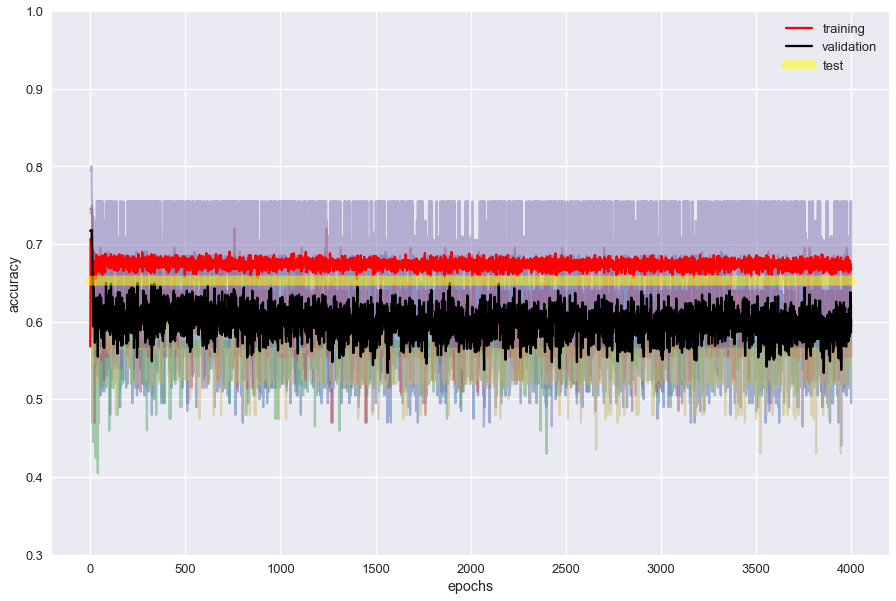

In [53]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
plt.ylim([0.3,1])
x = np.arange(len(histories[0][0].history['val_categorical_accuracy']))
[plt.plot(x,h.history['val_categorical_accuracy'],alpha=.5) for h in histories[0]];
plt.plot(x,np.mean([h.history['categorical_accuracy'] for h in histories[0]],axis=0),c='red', label='training')
plt.plot(x,np.mean([h.history['val_categorical_accuracy'] for h in histories[0]],axis=0),c='black', label='validation')
plt.plot(x,[0.653]*4000, c='yellow', linewidth=10, alpha=.5, label='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

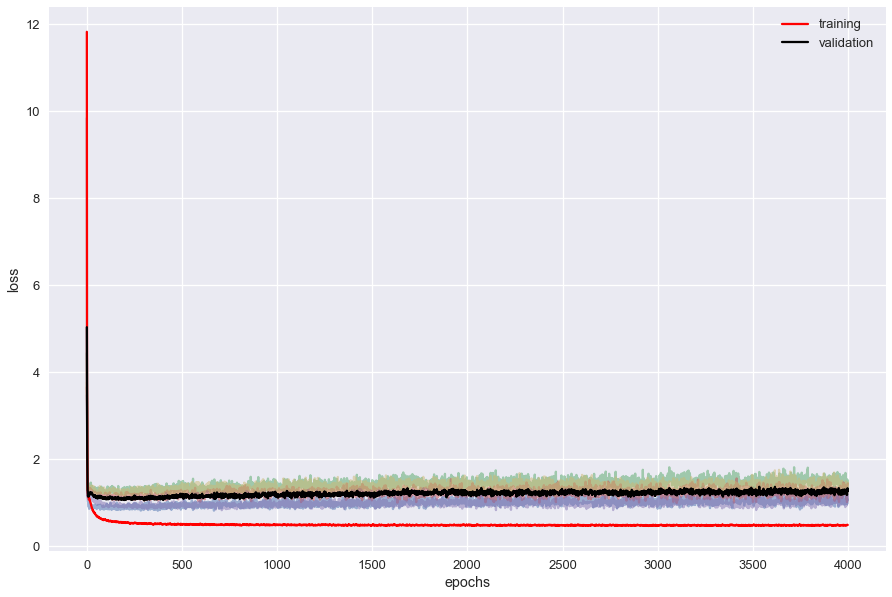

In [36]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
[plt.plot(np.arange(4000),h.history['val_loss'],alpha=.5) for h in histories[0]];
plt.plot(np.arange(4000),np.mean([h.history['loss'] for h in histories[0]],axis=0),c='red', label='training')
plt.plot(np.arange(4000),np.mean([h.history['val_loss'] for h in histories[0]],axis=0),c='black', label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [ ]:
model = load_model('4000epoch_0,9dropout_woFC_wBI.h5', custom_objects={'seq_len': seq_len})

In [ ]:
# categorical accuracy (this is a bit skewed since it looks at the each link. 
#                       Since most of them are 0 paddings, accuracy is much higher than it really is...)
model.evaluate(X_test, Y_test)

In [54]:
X_test, Y_test = X[100:], Y[100:]

In [58]:
# Real Accuracy... (i.e. ratio of test samples that are completely correct predicted)
#                   not accounting for what has been predicted for the paddings

total_docs = len(Y_test)
total_links = sum([len(y[:i]) for y, i in zip(Y_test.argmax(-1), Y_test_ind)])

print('document accuracy', sum([np.array_equal(p[:i],y[:i]) for p,y,i in zip(np.argmax(histories[0][3].model.predict(X_test),-1), Y_test.argmax(-1), Y_test_ind)]) / total_docs)
print('link accuracy', sum([sum(p[:i] == y[:i]) for p,y,i in zip(np.argmax(histories[0][3].model.predict(X_test),-1),Y_test.argmax(-1), Y_test_ind)]) / total_links)

document accuracy 0.3333333333333333
link accuracy 0.46875


In [ ]:
sum([len(y[:i]) for y, i in zip(Y_test.argmax(-1), Y_test_ind)])

In [ ]:
sum([np.array_equal(p,y) for p,y in zip(np.argmax(model.predict(X_test),-1),Y_test.argmax(-1))])

In [ ]:
# compare predictions on training set with training labels
list(zip(models[-1].predict(X_train).argmax(-1), Y_train.argmax(-1)))

In [ ]:
list(zip(model.predict(X_test).argmax(-1), Y_test.argmax(-1)))

In [ ]:
plot_model(model, to_file='model_withoutloop.png')

In [ ]:
!open 'model_withoutloop.png'